In [1]:
# Basics
import os
import datetime as dt
import json

# Plots, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# FB Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.serialize import model_to_json, model_from_json

#import tensorflow as tf
#from tensorflow.keras import models, layers, optimizers, metrics
#from tensorflow.keras.layers.experimental.preprocessing import Normalization

In [2]:
sns.set()

# Get the Data
___

## Load the Data

In [3]:
path = "../raw_data/"

In [4]:
teste = os.path.join(path, "item_categories.csv")
teste

'../raw_data/item_categories.csv'

In [5]:
categories_ = pd.read_csv(os.path.join(path, "item_categories.csv"))
items_ = pd.read_csv(os.path.join(path, "items.csv"))
sales_ = pd.read_csv(os.path.join(path, "sales_train.csv"))
shops_ = pd.read_csv(os.path.join(path, "shops.csv"))
test_ = pd.read_csv(os.path.join(path, "test.csv"))
sample_ = pd.read_csv(os.path.join(path, "sample_submission.csv"))

In [126]:
categories_df = categories_.copy()
items_df = items_.copy()
shops_df = shops_.copy()
sales_df = sales_.copy()
test_df = test_.copy()
sample_df = sample_.copy()

## Merge and Clean the Data

In [127]:
# column type to datetime
sales_df["date"] = pd.to_datetime(sales_df.date, dayfirst=True)

# rename item_category_id to cat_id
categories_df.rename(columns={'item_category_id': 'cat_id'}, inplace=True)
items_df.rename(columns={'item_category_id': 'cat_id'}, inplace=True)
sales_df.rename(columns={'item_category_id': 'cat_id'}, inplace=True)

# merge test_df with item_df on item_id
test_df = test_df.merge(items_df[['item_id', 'cat_id']], on='item_id')

# merge items_df with sales_df on item_id
sales_df = sales_df.merge(items_df[['item_id', 'cat_id']], on='item_id')

# chage types
sales_df['item_cnt_day'] = sales_df['item_cnt_day'].astype('int32')
sales_df['date_block_num'] = sales_df['date_block_num'].astype('int32')
sales_df['shop_id'] = sales_df['shop_id'].astype('int32')
sales_df['item_id'] = sales_df['item_id'].astype('int32')
sales_df['cat_id'] = sales_df['cat_id'].astype('int32')
sales_df['item_price'] = sales_df['item_price'].astype('float32')

# create final price column and remove negative values
sales_df['final_price'] = sales_df.item_cnt_day * sales_df.item_price
sales_df['final_price'] = sales_df['final_price'].astype('float32')
sales_df.loc[sales_df['final_price'] < 0, ['final_price']] = 0

# sort by date
sales_df.sort_values("date", inplace=True)

## Look at the Data

In [8]:
sales_df

date  date_block_num  shop_id  item_id   item_price  \
400417  2013-01-01               0       51     6622   347.000000   
130157  2013-01-01               0        7     1524  2999.000000   
867737  2013-01-01               0       19    18721   149.000000   
1004082 2013-01-01               0       54    15133   170.000000   
1004086 2013-01-01               0       41    15133   170.000000   
...            ...             ...      ...      ...          ...   
1788495 2015-10-31              33       58     3734  3399.000000   
2715396 2015-10-31              33       58    17748   288.149994   
1502745 2015-10-31              33       26    20949     5.000000   
2931438 2015-10-31              33       46     7223  3999.000000   
2922155 2015-10-31              33       31     3352  2999.000000   

         item_cnt_day  cat_id  final_price  
400417              1      30   347.000000  
130157              1      29  2999.000000  
867737              1      40   149.000000  
1004082             1      67   170.000000  
1004086             1      67   170.000000  
...               ...     ...          ...  
1788495             1      23  3399.000000  
2715396             1      70   288.149994  
1502745             3      71    15.000000  
2931438             1      20  3999.000000  
2922155             1      23  2999.000000  

[2935849 rows x 8 columns]

In [9]:
sales_df.dtypes

date              datetime64[ns]
date_block_num             int32
shop_id                    int32
item_id                    int32
item_price               float32
item_cnt_day               int32
cat_id                     int32
final_price              float32
dtype: object

In [135]:
sales_df.describe()

date_block_num       shop_id       item_id    item_price  item_cnt_day  \
count    2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06   
mean     1.456991e+01  3.300173e+01  1.019723e+04  8.908533e+02  1.242641e+00   
std      9.422988e+00  1.622697e+01  6.324297e+03  1.729800e+03  2.618834e+00   
min      0.000000e+00  0.000000e+00  0.000000e+00 -1.000000e+00 -2.200000e+01   
25%      7.000000e+00  2.200000e+01  4.476000e+03  2.490000e+02  1.000000e+00   
50%      1.400000e+01  3.100000e+01  9.343000e+03  3.990000e+02  1.000000e+00   
75%      2.300000e+01  4.700000e+01  1.568400e+04  9.990000e+02  1.000000e+00   
max      3.300000e+01  5.900000e+01  2.216900e+04  3.079800e+05  2.169000e+03   

             cat_id   final_price  
count  2.935849e+06  2.935849e+06  
mean   4.000138e+01  1.161455e+03  
std    1.710076e+01  5.680839e+03  
min    0.000000e+00  0.000000e+00  
25%    2.800000e+01  2.490000e+02  
50%    4.000000e+01  4.490000e+02  
75%    5.500000e+01  1.078200e+03  
max    8.300000e+01  1.829990e+06

In [ ]:
categories_df = categories_.copy()
items_df = items_.copy()
shops_df = shops_.copy()
sales_df = sales_.copy()
test_df = test_.copy()
sample_df = sample_.copy()

In [149]:
print(
    f"Shop id Shape: {shops_df.shape}",
    f"Categories id Shape: {categories_df.shape}",
    f"Items id Shape: {items_df.shape}",
    f"Test Shape: {test_df.shape}",
    sep="\n"
)

Shop id Shape: (60, 2)
Categories id Shape: (84, 2)
Items id Shape: (22170, 3)
Test Shape: (214200, 4)


## First time run parameter

In [11]:
# Frequency analysis in days
# d: days
# w: weeks
# m: months
freq_analysis = 'd'

# Load the models from local directory
LOADED = False
SAVED = True
PATH_MODELS = '../prophet_models/'

In [58]:
# Saved files names:
# Print models name im PATH directory
"""
prophet_shops_id_sales.json
prophet_shops_id_values.json
prophet_cats_id_sales.json
prophet_cats_id_values.json
"""

! ls ../prophet_models/

prophet_cats_id_sales.json   prophet_shops_id_sales.json
prophet_cats_id_values.json  prophet_shops_id_values.json


# Sorting the Data
___

## Sort and Plot Functions

In [17]:
# sort the Data Frame by "types" to be used in the analysis
def sort_sales(df: pd.core.frame.DataFrame, name: str, feature: str) -> pd.core.frame.DataFrame:
    """
    Sort the Data Frame by "type(name)" to be used in the analysis.
    df: Data Frame.
    name: shop, cat, item.
    feature: item_cnt_day, final_price.
    """
    
    df_feature = pd.DataFrame()

    for id in range(df.shape[0]):
        name_id = f'{name}_id_{id}'
        df = sales_df[sales_df[f'{name}_id'] == id]
        df = df.resample(freq_analysis, on='date').sum()[[feature]]
        df.rename(columns = {feature:name_id}, inplace=True)
        df_feature = pd.concat([df_feature, df], axis=1)

    return df_feature

In [433]:
# bar plot function
def bar_plot_func(df: pd.core.frame.DataFrame, xlabel="", ylabel="", start=0) -> None:
    """
    Bar plot the data.
    data: dictionary with the values.
    """
    df = df.sum().sort_values(ascending=False)
    df = df.iloc[start:80+start]
    plt.figure(figsize=(12, 5))
    sns.barplot(x=df.index, y=df.values, order=df.index)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tick_params(axis='x', labelsize=6, rotation=90)
    plt.tick_params(axis='y', labelsize=10)
    plt.show()

In [19]:
# line plot function
def line_plot_func(df: pd.core.frame.DataFrame, number=2, sample: list=[], ylabel="") -> None:
    """
    Line plot the data.
    df: data frame to be ploted.
    number: number of randon samples.
    sample: a list with itens to be ploted, override number.
    """
    plt.figure(figsize=(12, 7))
    if sample:
        sns.lineplot(df.loc[:,sample])
    else:
        sns.lineplot(data=df.sample(number, axis=1))
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.tick_params(axis='x', labelsize=10, rotation=45)
    plt.tick_params(axis='y', labelsize=10)
    plt.legend(fontsize=10)
    plt.show()

## Group by Shop

### Number of Sales (file name _shops\_sales_)

In [24]:
shops_sales = sort_sales(shops_df, "shop", "item_cnt_day")
shops_sales.head()

shop_id_0  shop_id_1  shop_id_2  shop_id_3  shop_id_4  shop_id_5  \
date                                                                           
2013-01-01        NaN        NaN         24        NaN        NaN        NaN   
2013-01-02        NaN        NaN         76       64.0      166.0        NaN   
2013-01-03      203.0      204.0         96       43.0      142.0        NaN   
2013-01-04      352.0       39.0         80       44.0      132.0        NaN   
2013-01-05      292.0      200.0         72       29.0      116.0        NaN   

            shop_id_6  shop_id_7  shop_id_8  shop_id_9  ...  shop_id_50  \
date                                                    ...               
2013-01-01        NaN         89       50.0        NaN  ...         NaN   
2013-01-02      173.0        208      138.0        NaN  ...       231.0   
2013-01-03      187.0        158      121.0        NaN  ...       236.0   
2013-01-04      187.0        117      106.0        NaN  ...       206.0   
2013-01-05      144.0        125       99.0        NaN  ...       155.0   

            shop_id_51  shop_id_52  shop_id_53  shop_id_54  shop_id_55  \
date                                                                     
2013-01-01       136.0         NaN         NaN       415.0         NaN   
2013-01-02       147.0       119.0       149.0       709.0         NaN   
2013-01-03       146.0       100.0       116.0       586.0         NaN   
2013-01-04       121.0       115.0       104.0       495.0         NaN   
2013-01-05        88.0        62.0       141.0       495.0         NaN   

            shop_id_56  shop_id_57  shop_id_58  shop_id_59  
date                                                        
2013-01-01         NaN         NaN         NaN         NaN  
2013-01-02       375.0         NaN         NaN       155.0  
2013-01-03       244.0         NaN         NaN       158.0  
2013-01-04       171.0         NaN         NaN        92.0  
2013-01-05       191.0         NaN         NaN       101.0  

[5 rows x 60 columns]

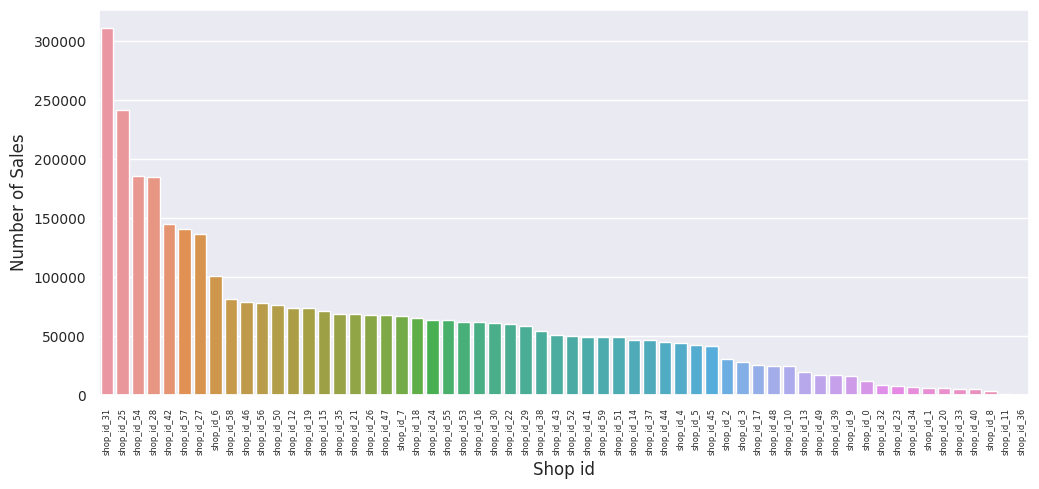

In [393]:
bar_plot_func(shops_sales, "Shop id", "Number of Sales")

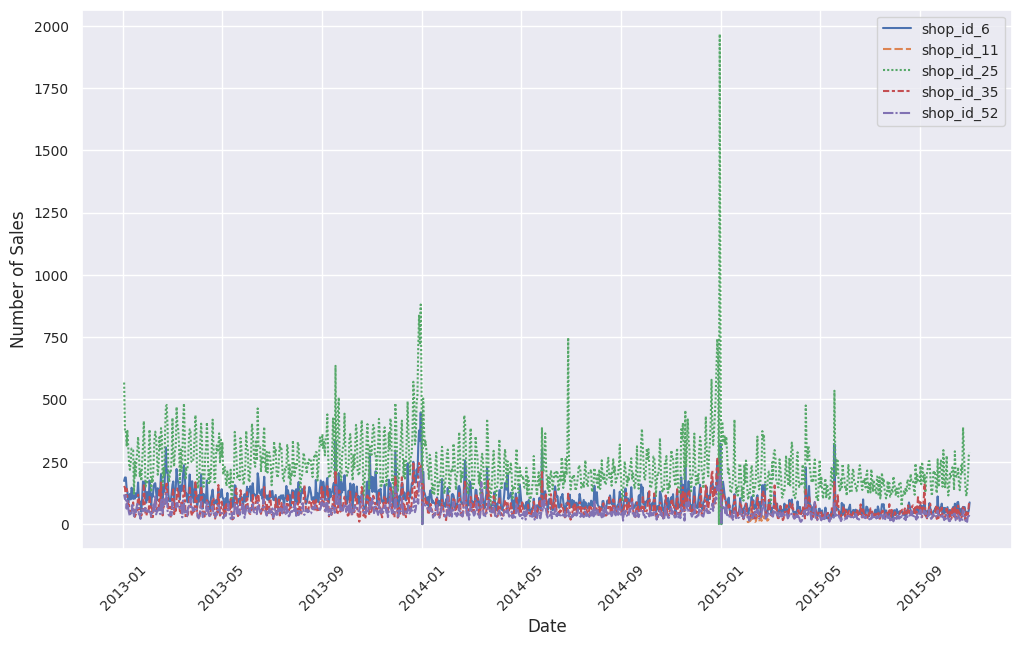

In [26]:
line_plot_func(shops_sales, number=5, ylabel="Number of Sales")

### Value of Sales (file name _shops\_values_)

In [27]:
shops_values = sort_sales(shops_df, "shop", "final_price")
shops_values.head()

shop_id_0  shop_id_1      shop_id_2  shop_id_3  shop_id_4  \
date                                                                    
2013-01-01        NaN        NaN   31886.000000        NaN        NaN   
2013-01-02        NaN        NaN   78307.007812    37305.0   122971.0   
2013-01-03   110588.0   108409.0  110521.000000    58891.0   102697.0   
2013-01-04   231122.0    45079.0   62854.000000    23231.0    88356.0   
2013-01-05   167500.0   103025.0   50181.000000    21771.0    52292.0   

            shop_id_5  shop_id_6  shop_id_7  shop_id_8  shop_id_9  ...  \
date                                                               ...   
2013-01-01        NaN        NaN    59993.0    44516.0        NaN  ...   
2013-01-02        NaN   147318.0   147332.0    97050.0        NaN  ...   
2013-01-03        NaN   133219.0   124552.0    73278.0        NaN  ...   
2013-01-04        NaN   123014.0    90173.0    80960.0        NaN  ...   
2013-01-05        NaN   107611.0   101877.0    61110.0        NaN  ...   

            shop_id_50  shop_id_51  shop_id_52  shop_id_53  shop_id_54  \
date                                                                     
2013-01-01         NaN     41411.0         NaN         NaN    319356.0   
2013-01-02    189892.0     56035.0     82783.0    105339.0    520884.0   
2013-01-03    169269.0     31080.0     76037.0     76952.5    377069.0   
2013-01-04    173310.0     37426.0     72385.0     98032.0    287218.0   
2013-01-05    143939.0     47338.0     28667.0     92861.0    401106.0   

            shop_id_55  shop_id_56  shop_id_57  shop_id_58  shop_id_59  
date                                                                    
2013-01-01         NaN         NaN         NaN         NaN         NaN  
2013-01-02         NaN    227756.0         NaN         NaN    146080.0  
2013-01-03         NaN    168691.0         NaN         NaN    156443.0  
2013-01-04         NaN    101474.0         NaN         NaN     84128.0  
2013-01-05         NaN     94114.0         NaN         NaN    103285.0  

[5 rows x 60 columns]

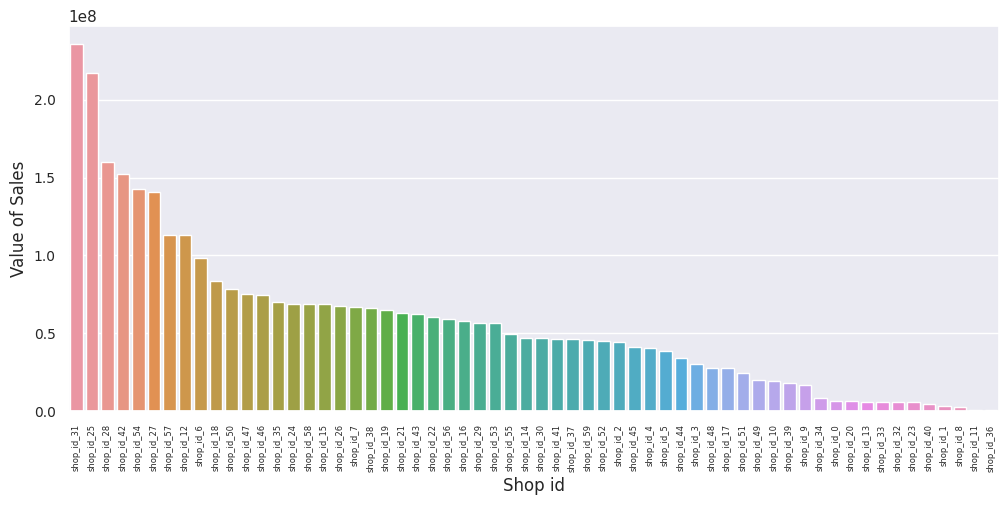

In [394]:
bar_plot_func(shops_values, "Shop id", "Value of Sales")

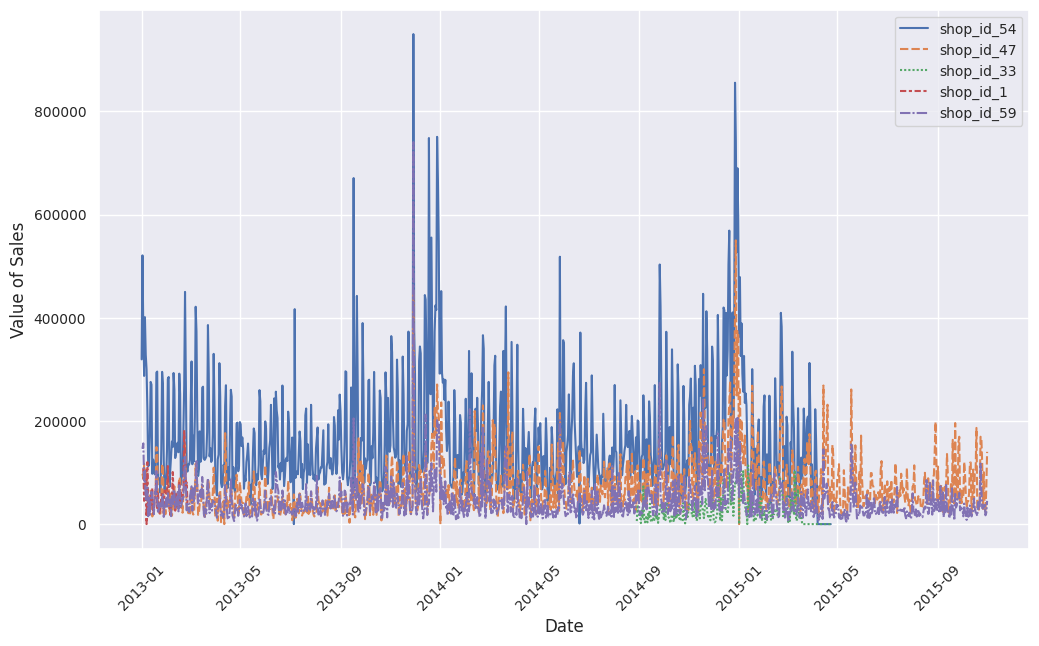

In [29]:
line_plot_func(shops_values, number=5, ylabel="Value of Sales")

## Group by Category

### Number of Sales  (file name _cats\_sales_)

In [30]:
cats_sales = sort_sales(categories_df, "cat", "item_cnt_day")
cats_sales.head()

cat_id_0  cat_id_1  cat_id_2  cat_id_3  cat_id_4  cat_id_5  \
date                                                                     
2013-01-01       NaN       NaN      30.0         7      10.0        12   
2013-01-02       NaN       NaN     116.0        41      18.0        58   
2013-01-03       NaN       NaN      84.0        32      17.0        56   
2013-01-04       NaN       NaN      77.0        24      19.0        33   
2013-01-05       NaN       NaN      79.0        25      15.0        46   

            cat_id_6  cat_id_7  cat_id_8  cat_id_9  ...  cat_id_74  cat_id_75  \
date                                                ...                         
2013-01-01        13       NaN       NaN       NaN  ...        NaN         17   
2013-01-02        64       NaN       NaN       NaN  ...        NaN         95   
2013-01-03        47       NaN       NaN       NaN  ...        NaN        126   
2013-01-04        43       NaN       NaN       NaN  ...        NaN        167   
2013-01-05        40       NaN       NaN       NaN  ...        NaN        110   

            cat_id_76  cat_id_77  cat_id_78  cat_id_79  cat_id_80  cat_id_81  \
date                                                                           
2013-01-01        NaN          4        NaN          1        NaN        1.0   
2013-01-02        NaN         31        NaN          7        NaN        9.0   
2013-01-03        NaN         30        NaN          1        NaN        7.0   
2013-01-04        NaN         16        NaN          7        NaN        8.0   
2013-01-05        NaN         18        NaN          7        NaN        7.0   

            cat_id_82  cat_id_83  
date                              
2013-01-01       16.0         35  
2013-01-02       71.0        113  
2013-01-03       41.0         64  
2013-01-04       62.0         32  
2013-01-05       57.0         38  

[5 rows x 84 columns]

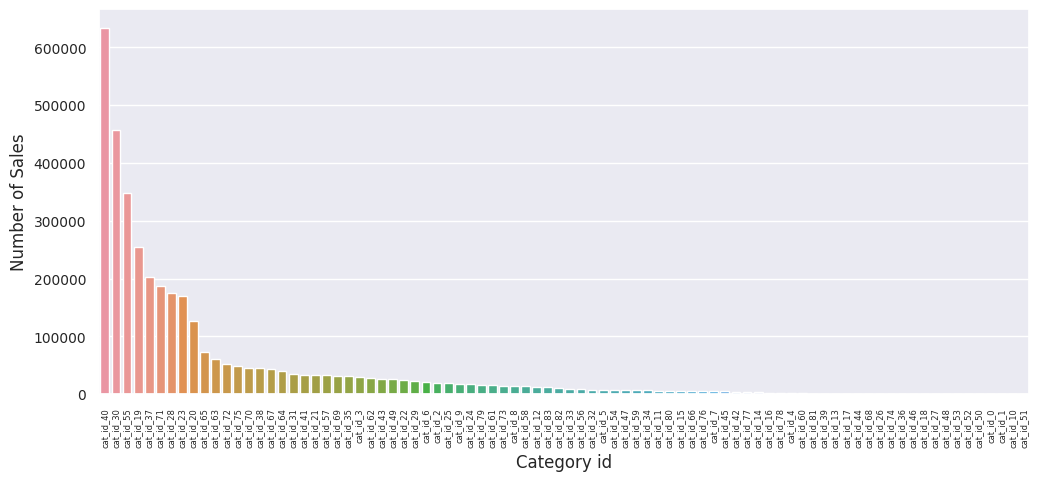

In [31]:
bar_plot_func(cats_sales, "Category id", "Number of Sales")

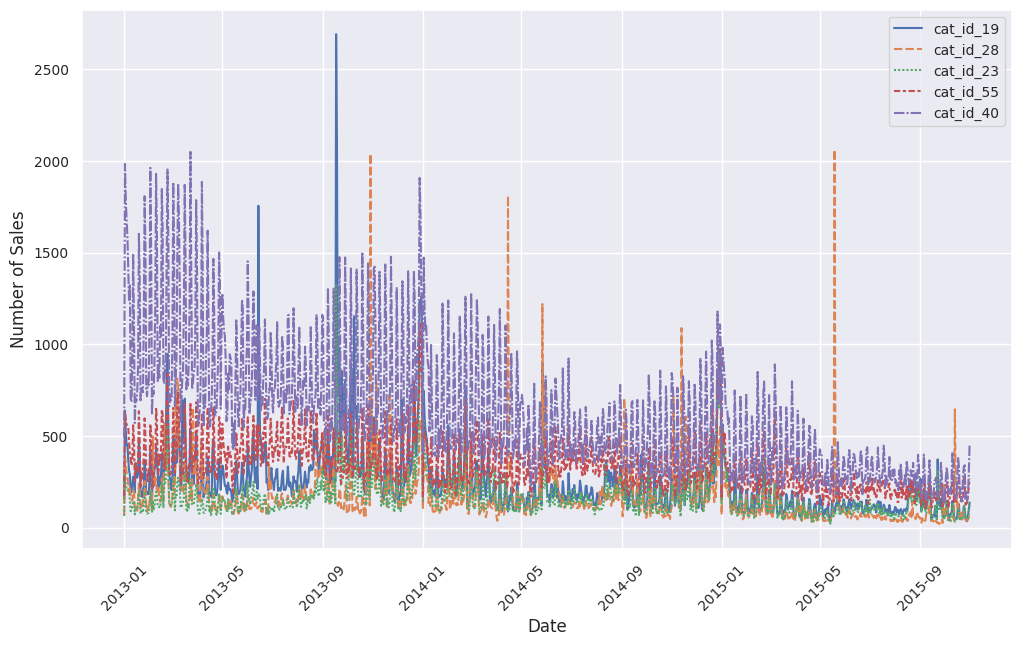

In [285]:
sample_id = ['cat_id_19', 'cat_id_28', 'cat_id_23', 'cat_id_55', 'cat_id_40']
line_plot_func(cats_sales, sample=sample_id, ylabel="Number of Sales")

### Value of Sales (file name _cats\_values_)

In [33]:
cats_values = sort_sales(categories_df, "cat", "final_price")
cats_values.head()

cat_id_0  cat_id_1       cat_id_2      cat_id_3  cat_id_4  \
date                                                                    
2013-01-01       NaN       NaN   59210.679688   3235.660156    5353.0   
2013-01-02       NaN       NaN  223635.234375  20455.240234   22371.0   
2013-01-03       NaN       NaN  166675.000000  15711.000000   20409.0   
2013-01-04       NaN       NaN  146496.515625  11205.000000   18681.5   
2013-01-05       NaN       NaN  142757.015625  11447.000000   14820.0   

                cat_id_5  cat_id_6  cat_id_7  cat_id_8  cat_id_9  ...  \
date                                                              ...   
2013-01-01   8647.299805   20769.0       NaN       NaN       NaN  ...   
2013-01-02  47024.078125  120656.5       NaN       NaN       NaN  ...   
2013-01-03  58698.320312   62046.5       NaN       NaN       NaN  ...   
2013-01-04  34044.699219   71060.0       NaN       NaN       NaN  ...   
2013-01-05  46100.101562   55896.0       NaN       NaN       NaN  ...   

            cat_id_74      cat_id_75  cat_id_76  cat_id_77  cat_id_78  \
date                                                                    
2013-01-01        NaN   32224.500000        NaN      696.0        NaN   
2013-01-02        NaN  188437.000000        NaN     5554.0        NaN   
2013-01-03        NaN  210710.796875        NaN     5693.0        NaN   
2013-01-04        NaN  262702.000000        NaN     2985.0        NaN   
2013-01-05        NaN  157989.703125        NaN     3792.0        NaN   

            cat_id_79  cat_id_80  cat_id_81  cat_id_82     cat_id_83  
date                                                                  
2013-01-01      499.0        NaN       79.0      447.0   2580.000000  
2013-01-02     3593.0        NaN     1871.0     2522.0  10122.870117  
2013-01-03      599.0        NaN      951.0     1023.0   5546.000000  
2013-01-04     3393.0        NaN     1568.0     1814.0   3013.000000  
2013-01-05     3623.0        NaN     1989.0     1662.0   3294.000000  

[5 rows x 84 columns]

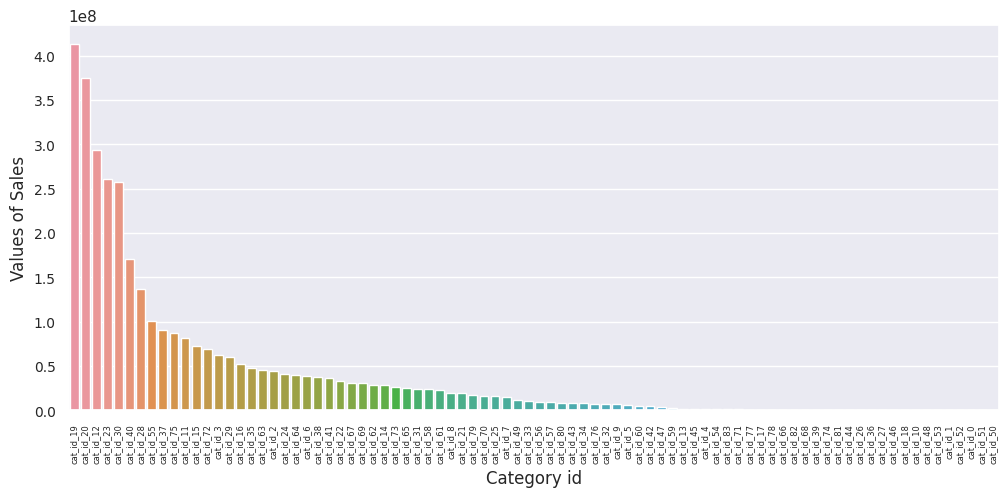

In [34]:
bar_plot_func(cats_values, "Category id", "Values of Sales")

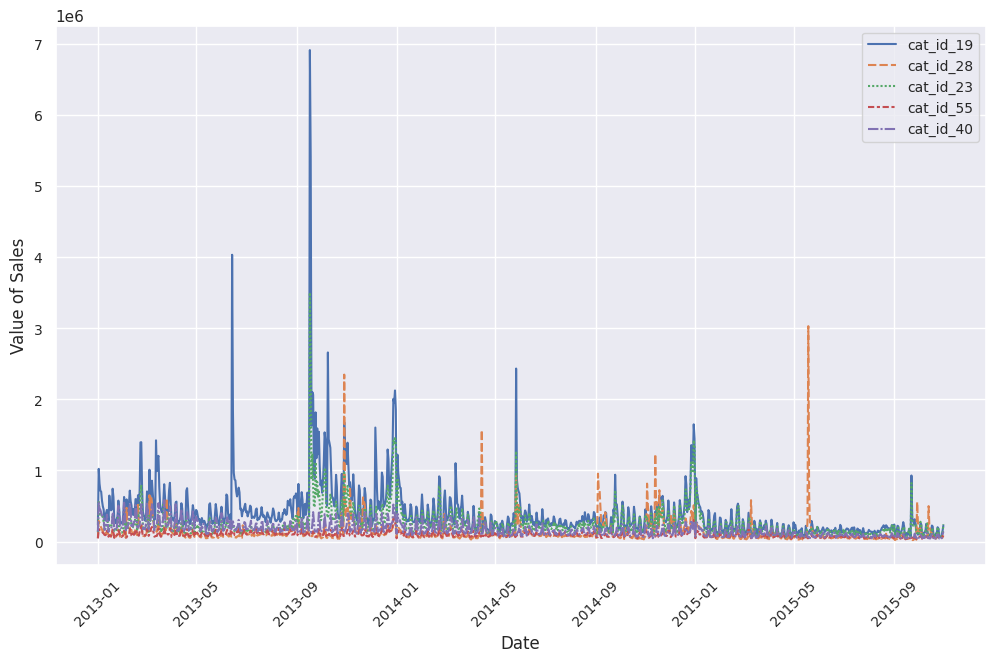

In [35]:
sample_id = ['cat_id_19', 'cat_id_28', 'cat_id_23', 'cat_id_55', 'cat_id_40']
line_plot_func(cats_values, sample=sample_id, ylabel="Value of Sales")

## Group by item

### Cleaning the data with the _test\_df_ Data Frame as base line

First we will remove the categories that don't show in the _test\_df_, to reduce the amount of data. The amount of data is to big, and will make analysis difficult. And those shops, categories and items have really small number on the sales.

In [191]:
unique_shops = np.sort(test_df['shop_id'].unique())
unique_shops, len(unique_shops)

(array([ 2,  3,  4,  5,  6,  7, 10, 12, 14, 15, 16, 18, 19, 21, 22, 24, 25,
        26, 28, 31, 34, 35, 36, 37, 38, 39, 41, 42, 44, 45, 46, 47, 48, 49,
        50, 52, 53, 55, 56, 57, 58, 59]),
 42)

In [192]:
unique_cats = np.sort(test_df['cat_id'].unique())
unique_cats, len(unique_cats)

(array([ 0,  2,  3,  5,  6,  7,  9, 11, 12, 15, 16, 19, 20, 21, 22, 23, 24,
        25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43,
        44, 45, 47, 49, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 67, 69,
        70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 83]),
 62)

In [193]:
unique_item = np.sort(test_df['item_id'].unique())
unique_item, len(unique_item)

(array([   30,    31,    32, ..., 22164, 22166, 22167]), 5100)

In [224]:
sales_clean_df = sales_df[
    sales_df['shop_id'].isin(unique_shops)
    & sales_df['cat_id'].isin(unique_cats)
    & sales_df['item_id'].isin(unique_item)
]
sales_clean_df

date  date_block_num  shop_id  item_id   item_price  \
1005087 2013-01-01               0       14    15438   599.000000   
128444  2013-01-01               0       41     1523   799.000000   
128357  2013-01-01               0       28     1523   799.000000   
128396  2013-01-01               0       14     1523   799.000000   
760355  2013-01-01               0       15     8685   199.000000   
...            ...             ...      ...      ...          ...   
1788495 2015-10-31              33       58     3734  3399.000000   
2715396 2015-10-31              33       58    17748   288.149994   
1502745 2015-10-31              33       26    20949     5.000000   
2931438 2015-10-31              33       46     7223  3999.000000   
2922155 2015-10-31              33       31     3352  2999.000000   

         item_cnt_day  cat_id  final_price  
1005087             1      63   599.000000  
128444              1      21   799.000000  
128357              1      21   799.000000  
128396              1      21   799.000000  
760355              1      55   199.000000  
...               ...     ...          ...  
1788495             1      23  3399.000000  
2715396             1      70   288.149994  
1502745             3      71    15.000000  
2931438             1      20  3999.000000  
2922155             1      23  2999.000000  

[1224439 rows x 8 columns]

In [227]:
print(
    f"sales_df Rows: {sales_df.shape[0]}",
    f"sales_clean_df Reows: {sales_clean_df.shape[0]}",
    sep='\n'
)

sales_df Rows: 2935849
sales_clean_df Reows: 1224439


### Number of Sales (file name _items\_sales_)

In [312]:
items_sales = pd.pivot_table(
    sales_clean_df, values='item_cnt_day',
    index=['item_id'], columns=['date'],
    aggfunc=np.sum 
)
items_sales.fillna(0, inplace=True)
items_sales = items_sales.T

In [372]:
items_sales.head()

item_id     30     31     32     33     38     42     45     51     53     \
date                                                                        
2013-01-01    0.0    0.0    4.0    0.0    0.0    0.0    0.0    0.0    0.0   
2013-01-02    0.0    0.0   12.0    3.0    0.0    0.0    1.0    0.0    1.0   
2013-01-03    0.0    0.0   15.0    1.0    0.0    0.0    1.0    2.0    1.0   
2013-01-04    0.0    0.0   11.0    2.0    0.0    0.0    0.0    0.0    0.0   
2013-01-05    0.0    0.0   14.0    4.0    0.0    0.0    0.0    1.0    0.0   

item_id     57     ...  22111  22118  22139  22145  22154  22162  22163  \
date               ...                                                    
2013-01-01    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2013-01-02    0.0  ...    0.0    0.0    1.0    0.0    3.0    0.0    0.0   
2013-01-03    0.0  ...    1.0    0.0    2.0    0.0    1.0    0.0    0.0   
2013-01-04    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2013-01-05    0.0  ...    0.0    0.0    1.0    0.0    1.0    0.0    0.0   

item_id     22164  22166  22167  
date                             
2013-01-01    0.0    0.0    0.0  
2013-01-02    0.0    0.0    0.0  
2013-01-03    0.0    0.0    0.0  
2013-01-04    0.0    0.0    0.0  
2013-01-05    0.0    0.0    0.0  

[5 rows x 4716 columns]

In [404]:
items_sales.sum().sort_values(ascending=False)

item_id
20949    154077.0
2808      13955.0
3732      13582.0
17717     13553.0
5822      12268.0
           ...   
12400         1.0
21001         1.0
21007         1.0
21010         1.0
5959          1.0
Length: 4716, dtype: float64

<AxesSubplot: ylabel='Percent'>

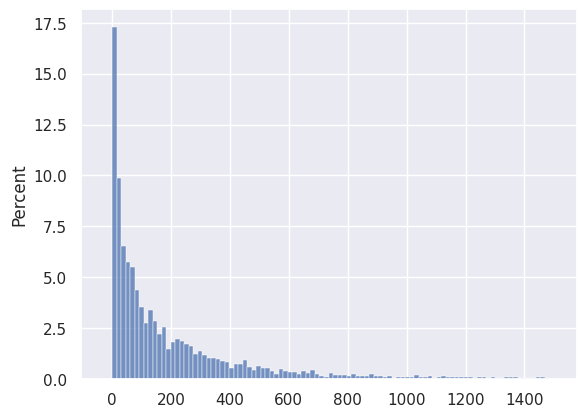

In [489]:
xxx = items_sales.sum().sort_values(ascending=False)
sns.histplot(xxx, stat='percent', bins=100, binrange=(-30, 1_500))
#plt.xlim(left=-100, right=1_500)
#plt.ylim(top=900)

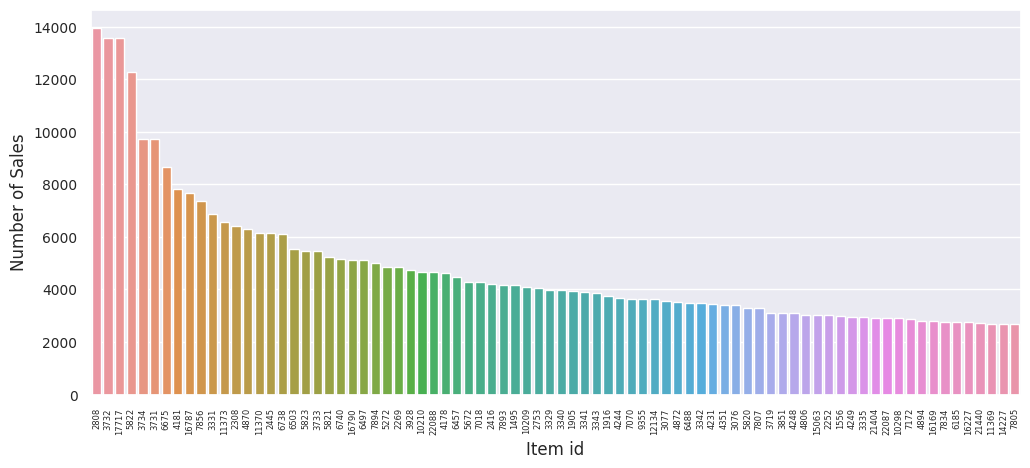

In [458]:
bar_plot_func(items_sales, "Item id", "Number of Sales", start=1)

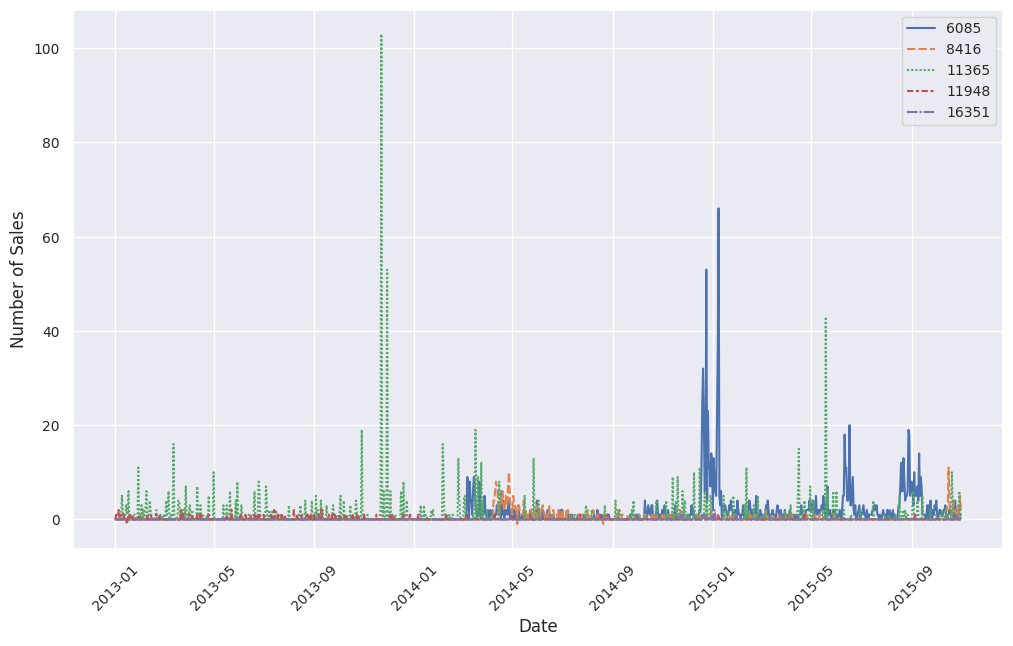

In [327]:
line_plot_func(items_sales, number=5, ylabel=f"Number of Sales")

### Values of Sales (file name _items\_values_)

In [328]:
items_values = pd.pivot_table(
    sales_clean_df, values='final_price',
    index=['item_id'], columns=['date'],
    aggfunc=np.sum 
)
items_values.fillna(0, inplace=True)
items_values = items_values.T

In [330]:
items_values.head()

item_id     30     31           32      33     38     42     45     51     \
date                                                                        
2013-01-01    0.0    0.0  1395.439941     0.0    0.0    0.0    0.0    0.0   
2013-01-02    0.0    0.0  4186.870117  1497.0    0.0    0.0  299.0    0.0   
2013-01-03    0.0    0.0  5217.549805   499.0    0.0    0.0  299.0  498.0   
2013-01-04    0.0    0.0  3839.000000   998.0    0.0    0.0    0.0    0.0   
2013-01-05    0.0    0.0  4886.000000  1996.0    0.0    0.0    0.0  249.0   

item_id     53     57     ...  22111  22118        22139  22145   22154  \
date                      ...                                             
2013-01-01    0.0    0.0  ...    0.0    0.0     0.000000    0.0     0.0   
2013-01-02  299.0    0.0  ...    0.0    0.0   791.119995    0.0  2997.0   
2013-01-03  299.0    0.0  ...  349.0    0.0  1998.000000    0.0   999.0   
2013-01-04    0.0    0.0  ...    0.0    0.0     0.000000    0.0     0.0   
2013-01-05    0.0    0.0  ...    0.0    0.0   899.369995    0.0   999.0   

item_id     22162  22163  22164  22166  22167  
date                                           
2013-01-01    0.0    0.0    0.0    0.0    0.0  
2013-01-02    0.0    0.0    0.0    0.0    0.0  
2013-01-03    0.0    0.0    0.0    0.0    0.0  
2013-01-04    0.0    0.0    0.0    0.0    0.0  
2013-01-05    0.0    0.0    0.0    0.0    0.0  

[5 rows x 4716 columns]

In [403]:
items_values.sum().sort_values(ascending=False)

item_id
6675     185097376.0
3732      35825964.0
3734      26103438.0
3731      19258302.0
3733      18826444.0
            ...     
18707          149.0
8247           149.0
342            144.0
4491            99.0
180             80.0
Length: 4716, dtype: float32

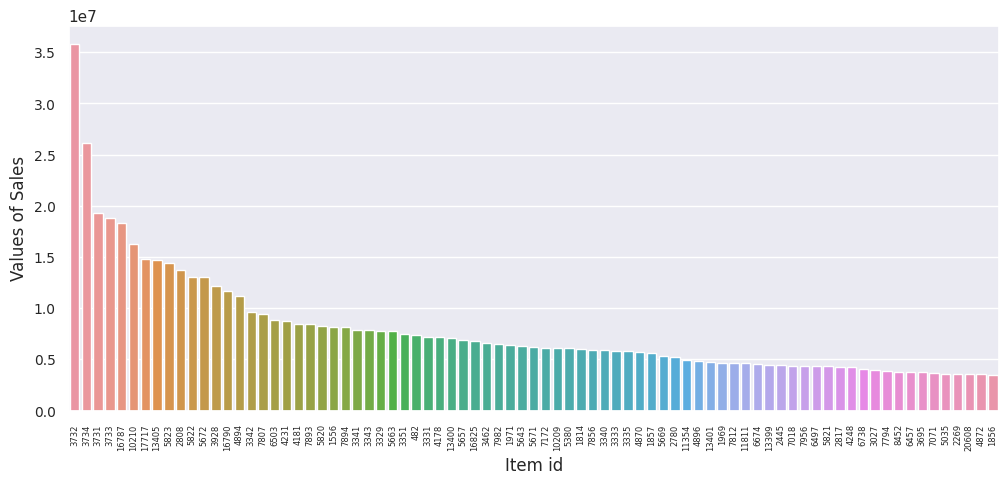

In [400]:
bar_plot_func(items_values, "Item id", "Values of Sales", start=1)

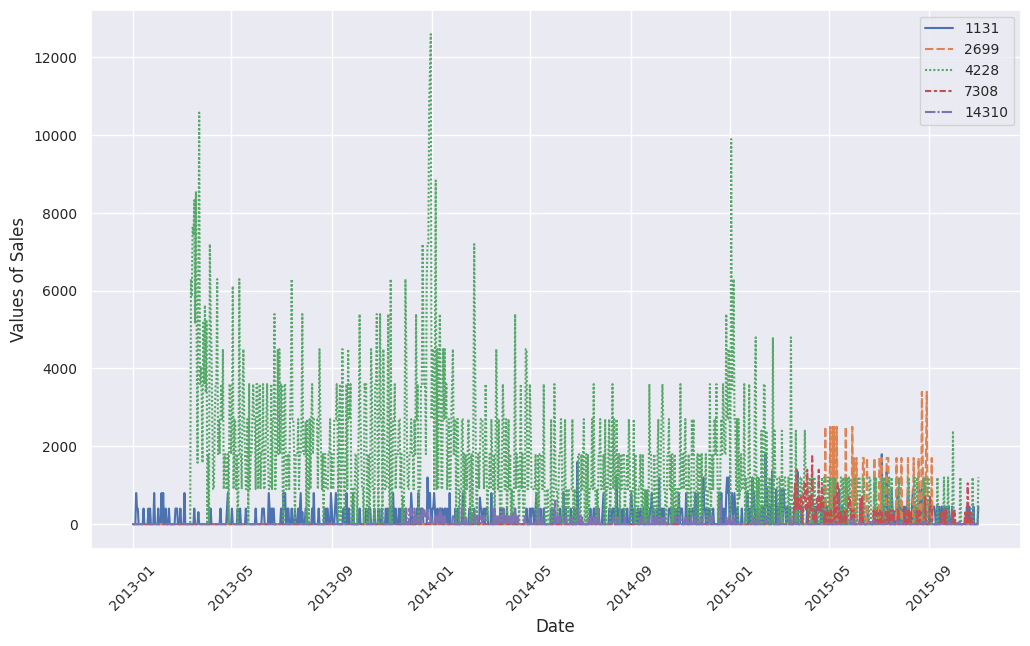

In [336]:
line_plot_func(items_values, number=5, ylabel=f"Values of Sales")

## Group  Categories by Shop

### Number of Sales (file name _cats_shops_sales_)

In [241]:
cats_shops_sales = pd.pivot_table(
    sales_clean_df, values='item_cnt_day',
    index=['shop_id', 'cat_id'], columns=['date'],
    aggfunc=np.sum 
)
cats_shops_sales.fillna(0, inplace=True)
cats_shops_sales = cats_shops_sales.T

In [301]:
cats_shops_sales.head()

shop_id      2                                                ...   59       \
cat_id       2    3    5    6    7    11   12   15   16   19  ...   67   69   
date                                                          ...             
2013-01-01  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2013-01-02  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  2.0  0.0   
2013-01-03  2.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  2.0  ...  1.0 -2.0   
2013-01-04  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  3.0  0.0   
2013-01-05  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  ...  1.0  0.0   

shop_id                                             
cat_id       70   71   72   73   75   77   79   83  
date                                                
2013-01-01  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2013-01-02  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2013-01-03  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
2013-01-04  0.0  0.0  0.0  0.0  3.0  0.0  0.0  0.0  
2013-01-05  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  

[5 rows x 2008 columns]

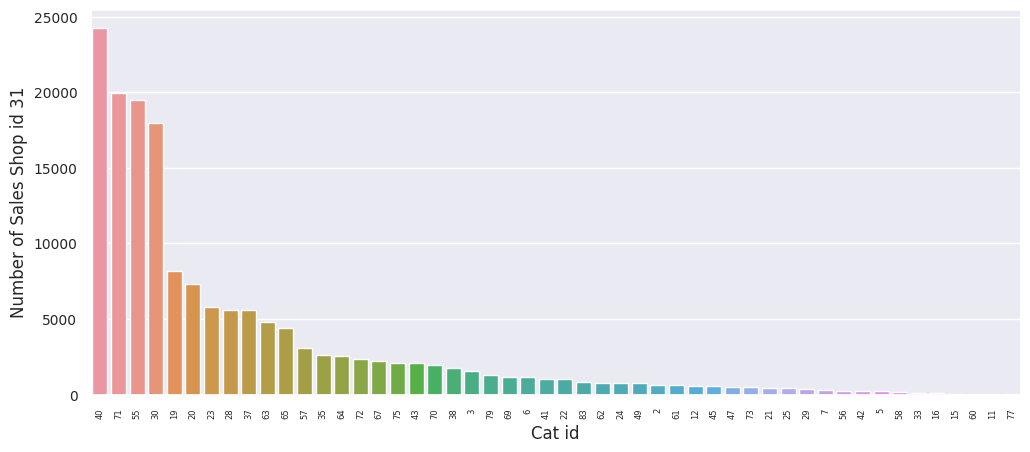

In [405]:
shop_id = 31
bar_plot_func(cats_shops_sales[shop_id], "Cat id", f"Number of Sales Shop id {shop_id}")

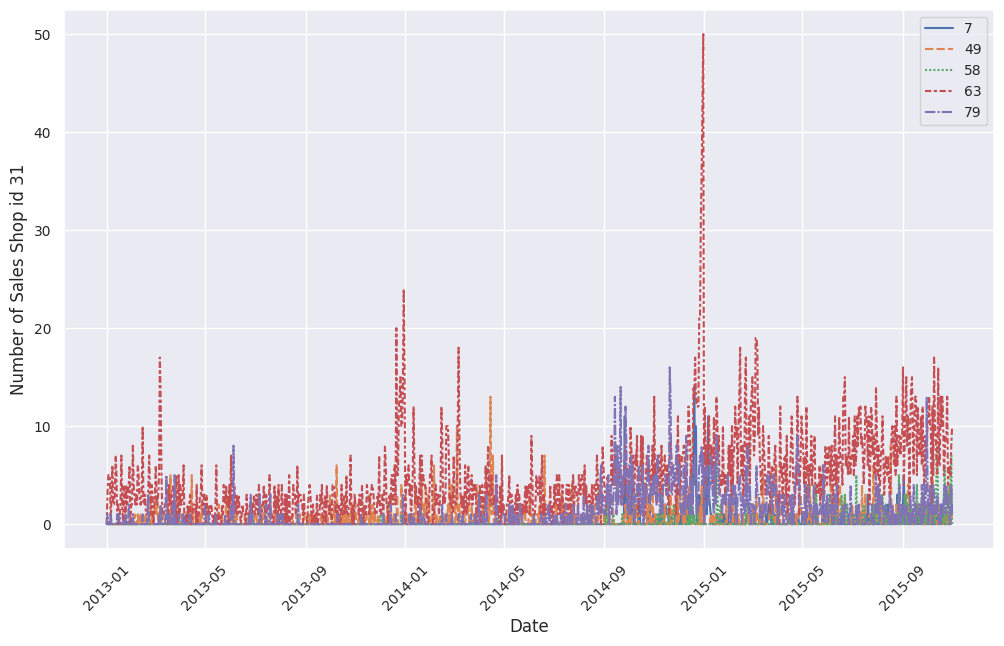

In [299]:
line_plot_func(cats_shops_sales[shop_id], number=5, ylabel=f"Number of Sales Shop id {shop_id}")

### Number of Sales (file name cats_shops_values)

In [302]:
cats_shops_values = pd.pivot_table(
    sales_clean_df, values='final_price',
    index=['shop_id', 'cat_id'], columns=['date'],
    aggfunc=np.sum 
)
cats_shops_values.fillna(0, inplace=True)
cats_shops_values = cats_shops_values.T

In [304]:
cats_shops_values.head()

shop_id         2                                                             \
cat_id          2    3           5       6    7    11   12   15   16      19   
date                                                                           
2013-01-01     0.0  0.0    0.000000     0.0  0.0  0.0  0.0  0.0  0.0     0.0   
2013-01-02  3180.0  0.0    0.000000     0.0  0.0  0.0  0.0  0.0  0.0  1199.0   
2013-01-03  3180.0  0.0  489.299988  1990.0  0.0  0.0  0.0  0.0  0.0  1798.0   
2013-01-04     0.0  0.0  699.000000     0.0  0.0  0.0  0.0  0.0  0.0     0.0   
2013-01-05  1590.0  0.0    0.000000     0.0  0.0  0.0  0.0  0.0  0.0  2698.0   

shop_id     ...      59                                                   
cat_id      ...      67   69   70   71   72   73      75   77   79    83  
date        ...                                                           
2013-01-01  ...     0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0   0.0  
2013-01-02  ...  1298.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0   0.0  
2013-01-03  ...   299.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  79.0  
2013-01-04  ...  1670.0  0.0  0.0  0.0  0.0  0.0  3450.0  0.0  0.0   0.0  
2013-01-05  ...   949.0  0.0  0.0  0.0  0.0  0.0  3500.0  0.0  0.0   0.0  

[5 rows x 2008 columns]

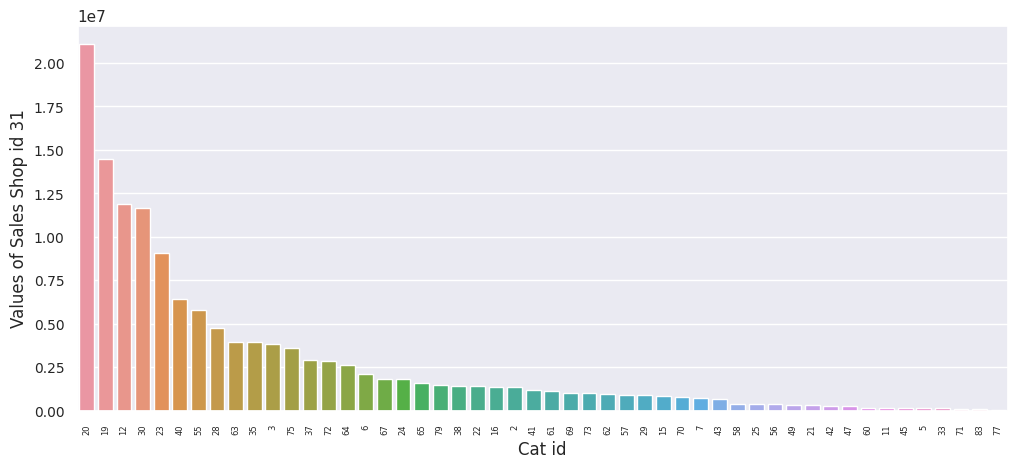

In [406]:
shop_id = 31
bar_plot_func(cats_shops_values[shop_id], "Cat id", f"Values of Sales Shop id {shop_id}")

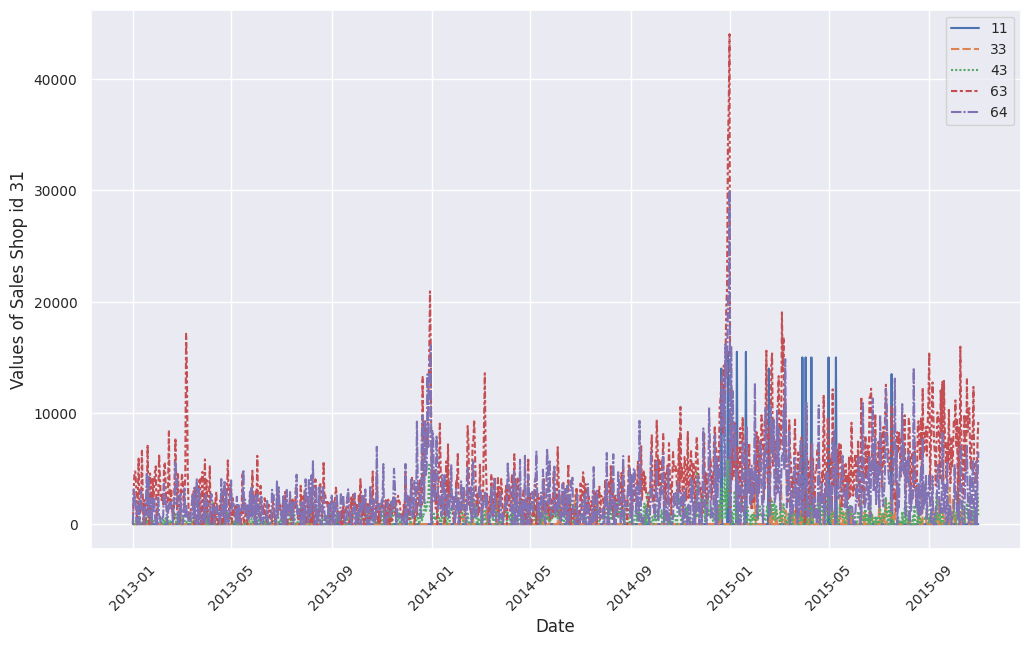

In [332]:
line_plot_func(cats_shops_values[shop_id], number=5, ylabel=f"Values of Sales Shop id {shop_id}")

## Total

### Files names: _total_sales_df and total_values_df_

In [36]:
total_sales_df = sales_df.resample(freq_analysis, on="date").sum()[['item_cnt_day']]
total_values_df = sales_df.resample(freq_analysis, on="date").sum()[['final_price']]

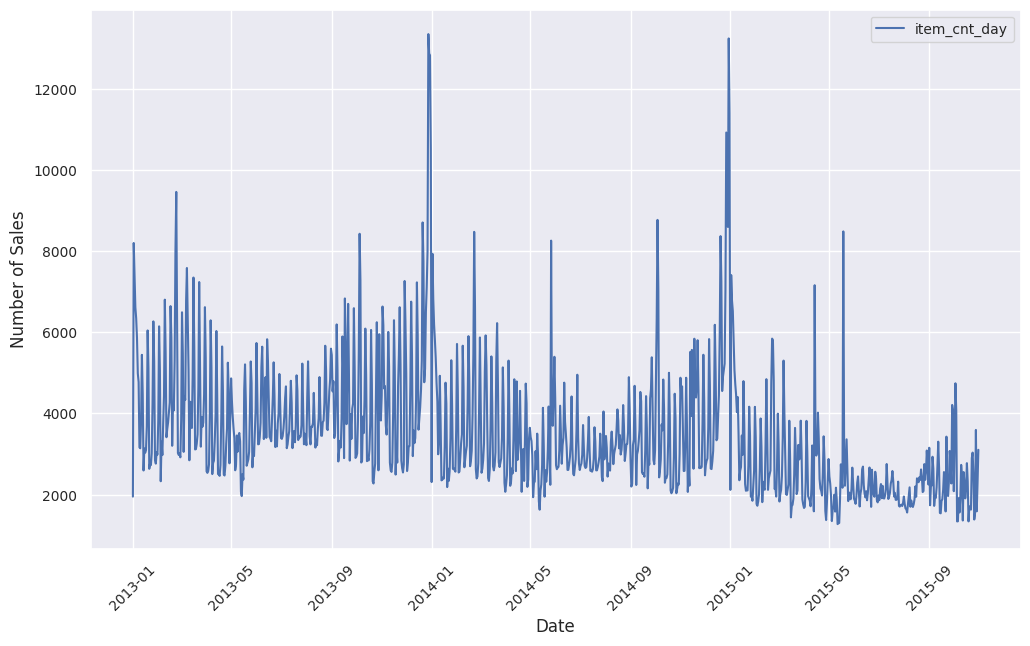

In [37]:
line_plot_func(total_sales_df, 1, ylabel="Number of Sales")

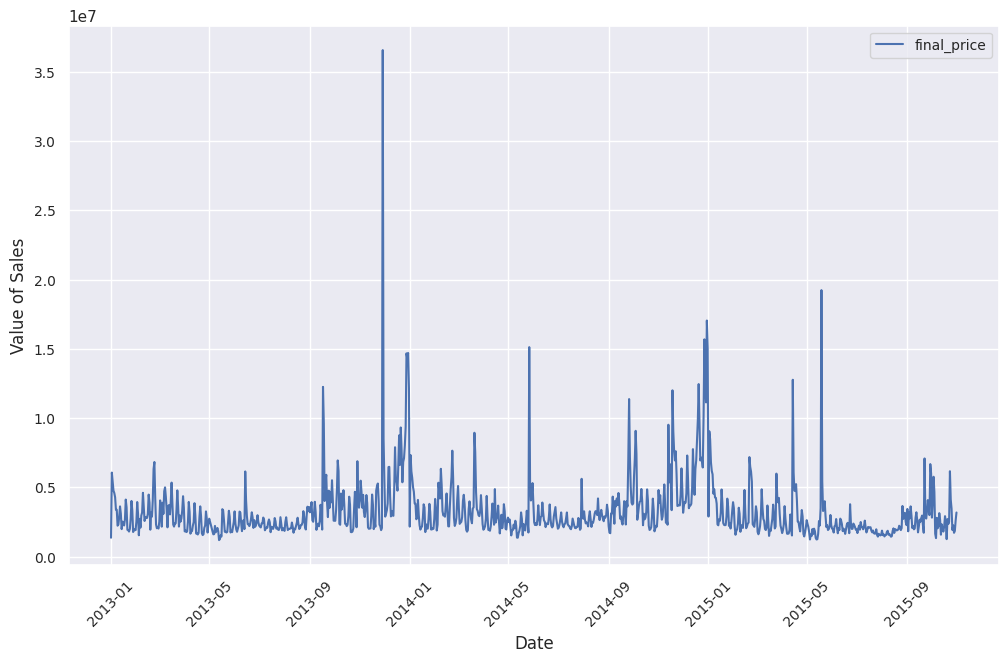

In [38]:
line_plot_func(total_values_df, 1, ylabel="Value of Sales")

# Model Prophet
___

## Model Functions

In [39]:
# plot graph with train test and predict
def plot_forecast(prophet_dict: dict, test=True, pred=True, lower=False, upper=False, left=None, right=None) -> None:
    """
    Plot the train, test and forecast data.
    prophet_dict: prophet_model dictionary
    test, pred, lower, upper: turn on and off the plots.
    left, right: sets the x-axis limits, in date format.
    """
    plt.figure(figsize=(15, 8))
    
    # plots
    plt.plot(prophet_dict['train']['ds'], prophet_dict['train']['y'], label="Train")
    if test:
        plt.plot(prophet_dict['test']['ds'], prophet_dict['test']['y'], label="Test")
    if pred:
        plt.plot(
            prophet_dict['forecast'][-prophet_dict['horizon']:]['ds'],
            prophet_dict['forecast'][-prophet_dict['horizon']:]['yhat'],
            label="Pred")
    if lower:
        plt.plot(
            prophet_dict['forecast'][-prophet_dict['horizon']:]['ds'],
            prophet_dict['forecast'][-prophet_dict['horizon']:]['yhat_lower'],
            label="Lower")
    if upper:
        plt.plot(prophet_dict['forecast'][-prophet_dict['horizon']:]['ds'],
                 prophet_dict['forecast'][-prophet_dict['horizon']:]['yhat_upper'],
                 label="Upper")
    
    # x and y axis limits
    if left is not None:
        left = dt.datetime.strptime(left, '%Y-%m').date()
    if right is not None:
        right = dt.datetime.strptime(right, '%Y-%m').date()
    plt.xlim(left=left, right=right)    
    
    plt.legend(loc="best")
    plt.show()

In [40]:
# function to split the data between train and test
def set_train_data(df, split, frequency):
    """
    Split the Data Frame between train and test, if there is no need for test use split=1.
    df: Data Frame
    split: size (%) of the train data
    frequency: month, week, day
    """
    
    # Rename Columns to Prophet format
    df = df.reset_index()
    df.columns = ['ds', 'y']
    
    # Set size train and test df
    shape = df.shape[0]
    train_size = int(shape * split)
    train = df.iloc[:train_size]
    test = df.iloc[train_size:]
    
    # Set the horizin to predict
    horizon_dict = {'m': 2, 'w': 8, 'd':62} # two month, four weeks, 62 days
    horizon = (horizon_dict[frequency]) + (shape - train_size)
    return train, test, horizon

In [41]:
# fit the Prophet model
def prophet_model(df, split=0.90, seas_scale=10, inter_w=0.80, freq='d') -> dict:
    """
    Fit the whole model with FB Prophet.
    ------------------------------------
    data: the data to be used.
    split: Split between train and test, if there is no need for test use split=1.
    (seas_scale) seasonality_prior_scale:
        Larger values allow the model to fit larger seasonal fluctuations,
        smaller values dampen the seasonality.
    (inter_w) interval_width:
        Float, width of the uncertainty intervals provided for the forecast.
        Uses the MAP estimate of the extrapolated generative model.
    freq: Used to create the frequency (day, week, month), of train, test, forecast and horizon
    """
    # Split the data
    train_df, test_df, horizon = set_train_data(df, split, freq)
    
    # Prophet model fit
    model = prophet_fit(train_df, seas_scale, inter_w)
    
    # future prediction
    forecast = future_preds(model, horizon, freq)
    
    # dict with model, split data and forecast
    prophet_dict = {'model':model,
        'forecast':forecast,
        'train':train_df,
        'test':test_df,
        'horizon':horizon
    }
    
    return prophet_dict

In [42]:
# fit loaded Prophet model
def prophet_loaded_model(df, model, split=1, freq='d') -> dict:
    """
    Fit the whole model with FB Prophet.
    ------------------------------------
    df: the data to be used.
    model: loaded Prophet model.
    """
    # Split the data
    train_df, test_df, horizon = set_train_data(df, split, freq)
    
    # future prediction
    forecast = future_preds(model, horizon, freq)
    
    # dict with model, split data and forecast
    prophet_dict = {'model':model,
        'forecast':forecast,
        'train':train_df,
        'horizon':horizon
    }
    
    return prophet_dict

In [43]:
# Prophet model
def prophet_fit(train_df, seas_scale, inter_w):
    model = Prophet(
        seasonality_mode='multiplicative', # or 'additive'
        seasonality_prior_scale=seas_scale, # default 10, smaller values dampen the seasonality
        interval_width=inter_w, # deaful 0.8, if mcmc < 0 will be integrated over all model parameters
        growth='linear', # is the default
        #yearly_seasonality=False, # default 'auto'
        #weekly_seasonality=True, # default 'auto'
        #daily_seasonality=False, # default 'auto'
        mcmc_samples=0, # default 0, if greater than 0, will do full Bayesian inference
    )
    return model.fit(train_df)    

In [44]:
# make future predictions
def future_preds(model, horizon, freq):
    """
    Return the forecast for a given model, frequency and horizon
    """
    future = model.make_future_dataframe(periods=horizon, freq=freq, )
    forecast = model.predict(future)
    # forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    return forecast    

## Evaluate Model for Total Data of Shop and Category

### Fitting the Data and Making Future Predictions

In [45]:
# total_Shops_Number_sales
prophet_total_shops_sales = prophet_model(
    total_sales_df,
    split=0.90,
    seas_scale=10,
    inter_w=0.80,
    freq=freq_analysis
)

# total_Shops_Values
prophet_total_shops_values = prophet_model(
    total_values_df,
    split=0.90,
    seas_scale=10,
    inter_w=0.80,
    freq=freq_analysis
)

19:19:40 - cmdstanpy - INFO - Chain [1] start processing
19:19:40 - cmdstanpy - INFO - Chain [1] done processing
19:19:40 - cmdstanpy - INFO - Chain [1] start processing
19:19:40 - cmdstanpy - INFO - Chain [1] done processing


### Plotting the forecast test

#### Shops Total Number of Sales

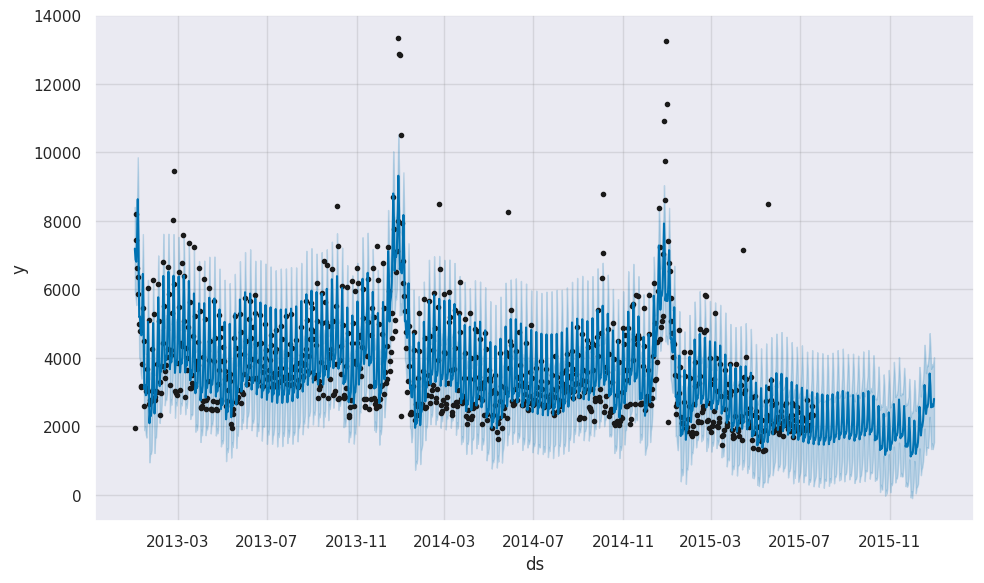

In [46]:
prophet_total_shops_sales['model'].plot(prophet_total_shops_sales['forecast']);

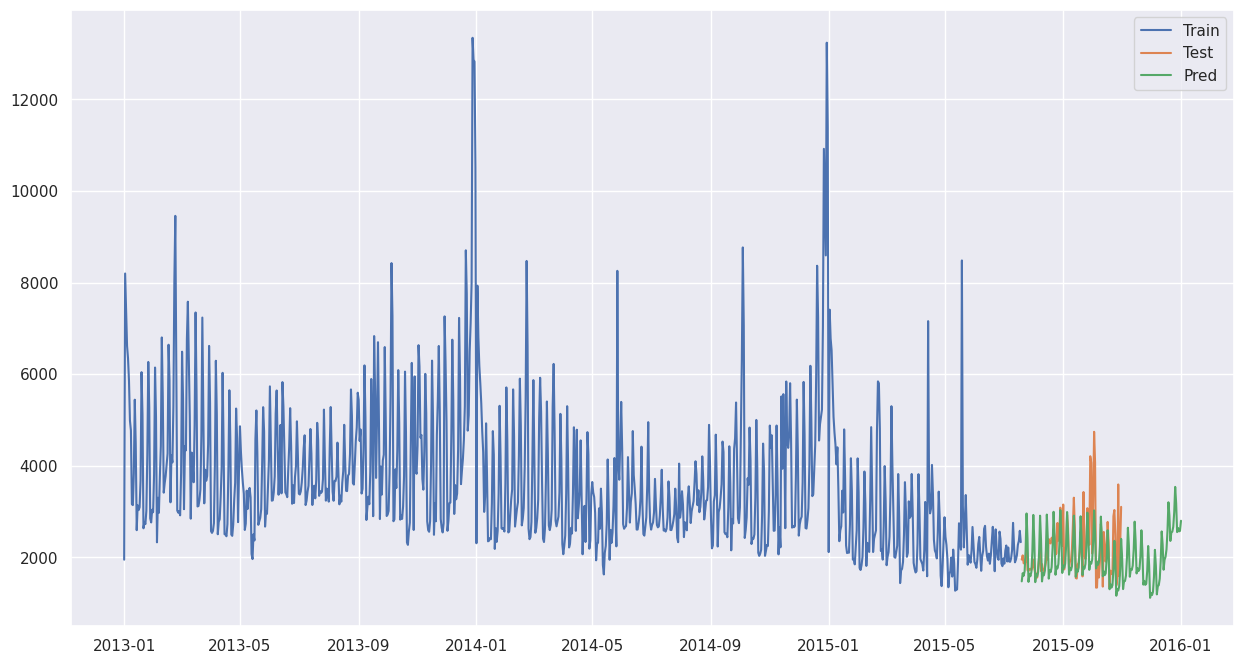

In [47]:
plot_forecast(prophet_total_shops_sales)

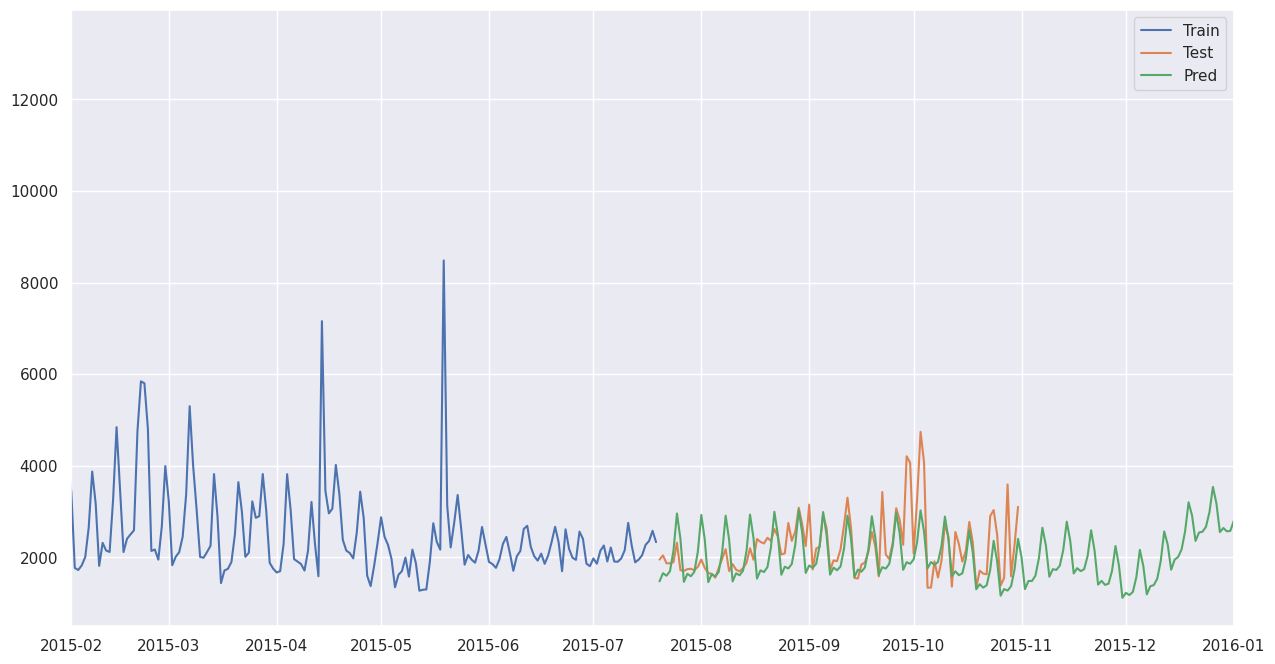

In [48]:
plot_forecast(prophet_total_shops_sales, left='2015-02', right='2016-01')

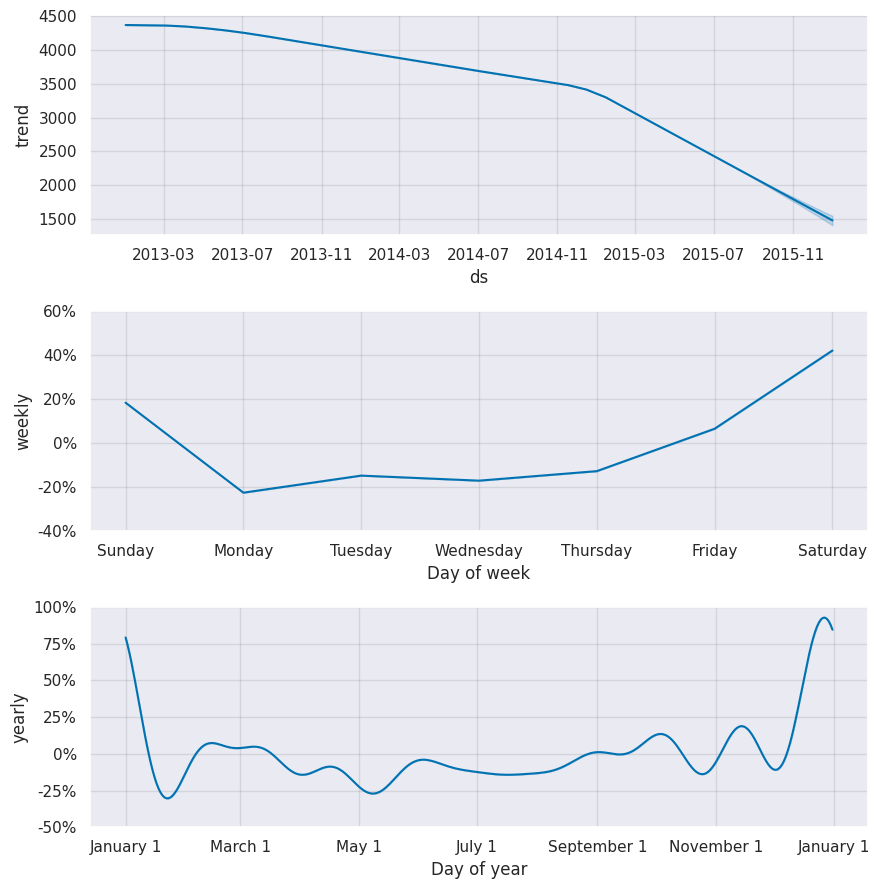

In [49]:
prophet_total_shops_sales['model'].plot_components(prophet_total_shops_sales['forecast']);

#### Shops Total Value of Sales

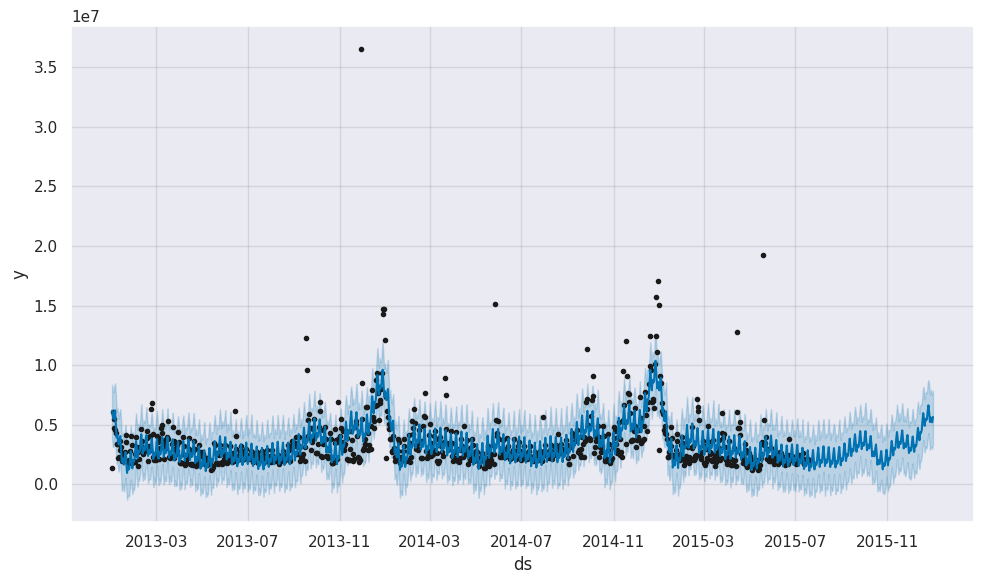

In [50]:
prophet_total_shops_values['model'].plot(prophet_total_shops_values['forecast']);

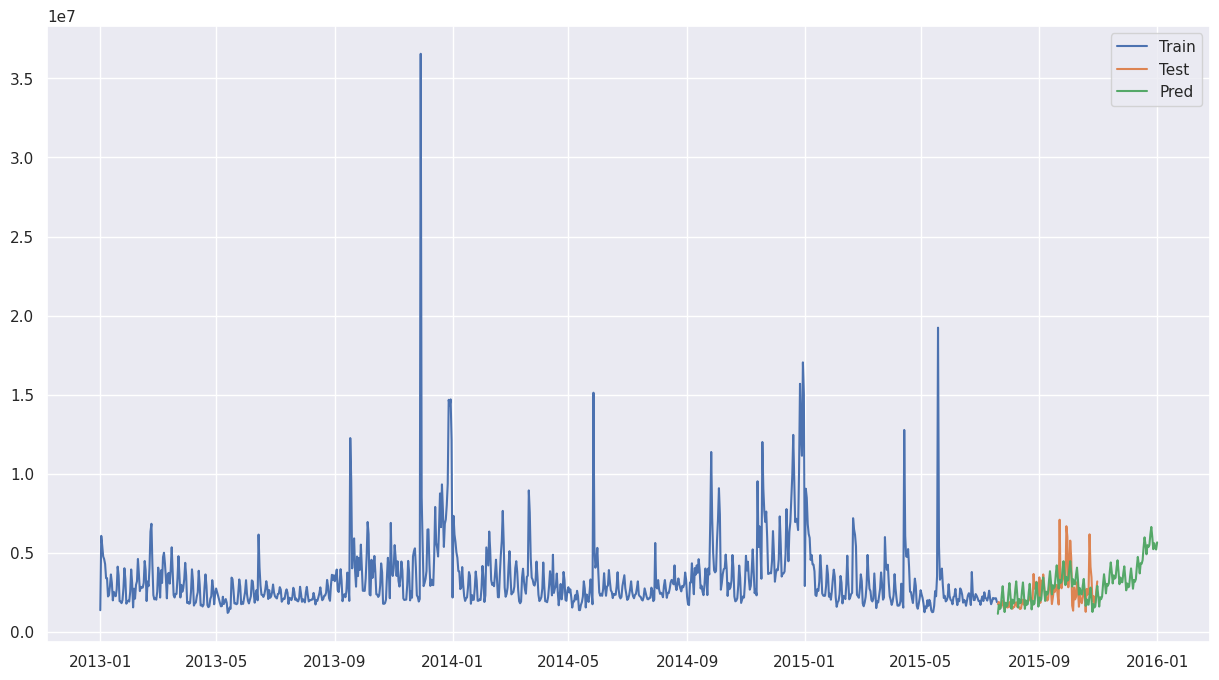

In [51]:
plot_forecast(prophet_total_shops_values)

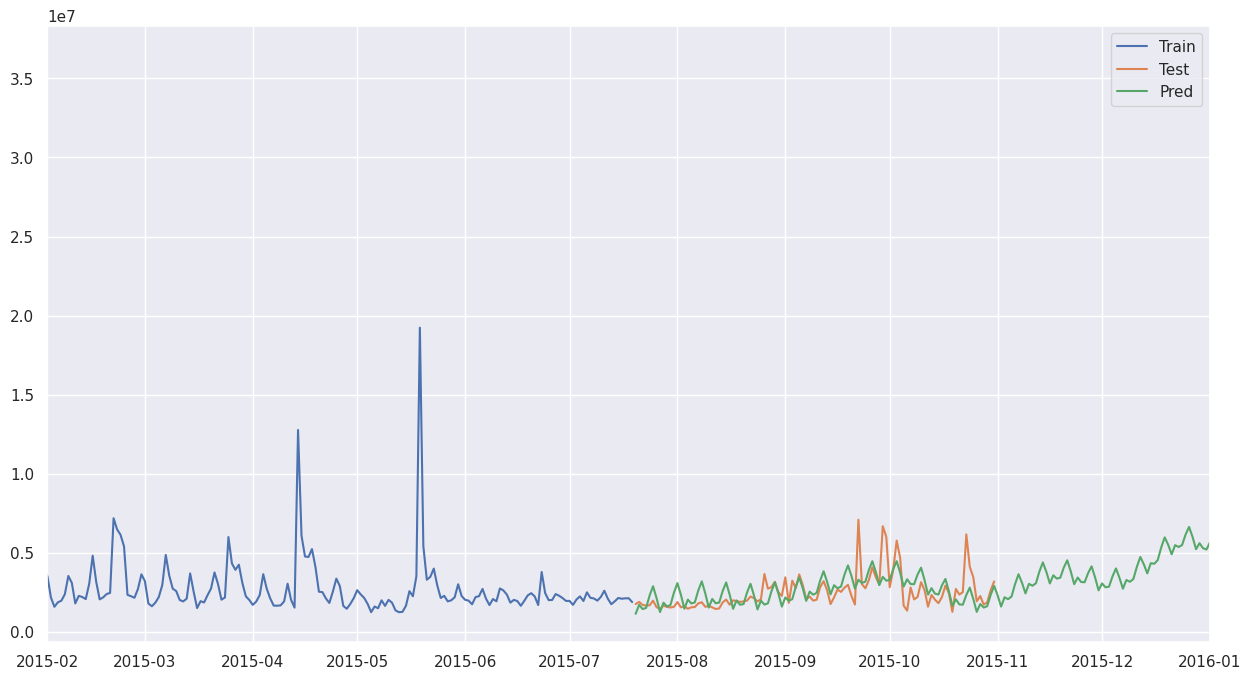

In [52]:
plot_forecast(prophet_total_shops_values, left='2015-02', right='2016-01')

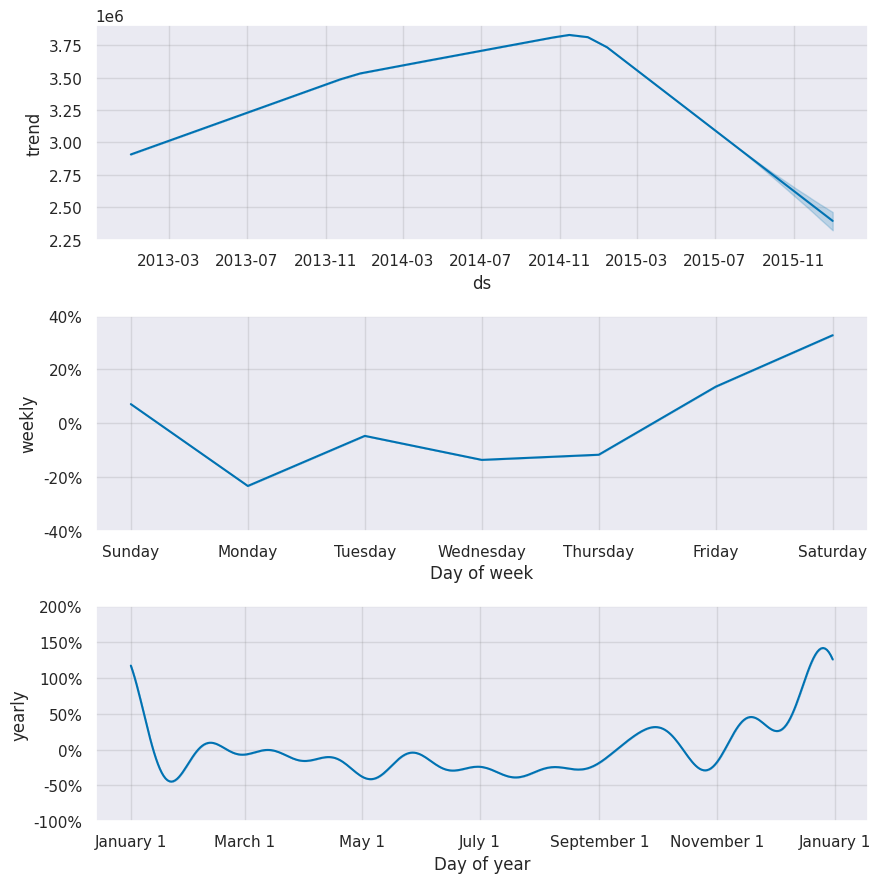

In [53]:
prophet_total_shops_values['model'].plot_components(prophet_total_shops_values['forecast']);

### Evaluating the model with cross-validation

In [54]:
# cross-validation for frequency daily
cv_results = cross_validation(
    model=prophet_total_shops_values['model'],
    initial='365.25 days', # one year
    horizon='31 days', # one month
    period='7 days'
)

  0%|          | 0/77 [00:00<?, ?it/s]

19:20:20 - cmdstanpy - INFO - Chain [1] start processing
19:20:20 - cmdstanpy - INFO - Chain [1] done processing
19:20:20 - cmdstanpy - INFO - Chain [1] start processing
19:20:20 - cmdstanpy - INFO - Chain [1] done processing
19:20:20 - cmdstanpy - INFO - Chain [1] start processing
19:20:20 - cmdstanpy - INFO - Chain [1] done processing
19:20:20 - cmdstanpy - INFO - Chain [1] start processing
19:20:20 - cmdstanpy - INFO - Chain [1] done processing
19:20:20 - cmdstanpy - INFO - Chain [1] start processing
19:20:21 - cmdstanpy - INFO - Chain [1] done processing
19:20:21 - cmdstanpy - INFO - Chain [1] start processing
19:20:21 - cmdstanpy - INFO - Chain [1] done processing
19:20:21 - cmdstanpy - INFO - Chain [1] start processing
19:20:21 - cmdstanpy - INFO - Chain [1] done processing
19:20:21 - cmdstanpy - INFO - Chain [1] start processing
19:20:21 - cmdstanpy - INFO - Chain [1] done processing
19:20:22 - cmdstanpy - INFO - Chain [1] start processing
19:20:22 - cmdstanpy - INFO - Chain [1]

19:20:38 - cmdstanpy - INFO - Chain [1] done processing
19:20:38 - cmdstanpy - INFO - Chain [1] start processing
19:20:38 - cmdstanpy - INFO - Chain [1] done processing
19:20:38 - cmdstanpy - INFO - Chain [1] start processing
19:20:38 - cmdstanpy - INFO - Chain [1] done processing
19:20:39 - cmdstanpy - INFO - Chain [1] start processing
19:20:39 - cmdstanpy - INFO - Chain [1] done processing
19:20:39 - cmdstanpy - INFO - Chain [1] start processing
19:20:39 - cmdstanpy - INFO - Chain [1] done processing


In [55]:
cv_results

ds          yhat    yhat_lower    yhat_upper           y  \
0    2014-01-03  1.342015e+07  1.094565e+07  1.573876e+07  6157385.00   
1    2014-01-04  1.372014e+07  1.133810e+07  1.626003e+07  5692653.00   
2    2014-01-05  1.200881e+07  9.493976e+06  1.439572e+07  5023962.00   
3    2014-01-06  9.763866e+06  7.169835e+06  1.212594e+07  4686706.00   
4    2014-01-07  1.050393e+07  8.061273e+06  1.305524e+07  3847043.00   
...         ...           ...           ...           ...         ...   
2382 2015-07-15  1.581451e+06 -6.942332e+05  3.851924e+06  2143850.50   
2383 2015-07-16  1.618025e+06 -6.438286e+05  3.743613e+06  2098436.75   
2384 2015-07-17  2.404855e+06 -3.112819e+04  4.704484e+06  2120300.25   
2385 2015-07-18  2.997321e+06  7.450540e+05  5.297616e+06  2127450.00   
2386 2015-07-19  2.163416e+06 -1.527292e+05  4.472834e+06  1884871.50   

         cutoff  
0    2014-01-02  
1    2014-01-02  
2    2014-01-02  
3    2014-01-02  
4    2014-01-02  
...         ...  
2382 2015-06-18  
2383 2015-06-18  
2384 2015-06-18  
2385 2015-06-18  
2386 2015-06-18  

[2387 rows x 6 columns]

In [56]:
df_p = performance_metrics(cv_results)
df_p

horizon           mse          rmse           mae      mape     mdape  \
0   4 days  2.005671e+12  1.416217e+06  9.547763e+05  0.268727  0.213400   
1   5 days  4.621689e+12  2.149811e+06  1.125786e+06  0.321750  0.246580   
2   6 days  5.008448e+12  2.237956e+06  1.198436e+06  0.358960  0.273054   
3   7 days  5.450523e+12  2.334635e+06  1.289077e+06  0.381271  0.293774   
4   8 days  3.533105e+12  1.879656e+06  1.228370e+06  0.383346  0.283996   
5   9 days  3.393559e+12  1.842162e+06  1.244552e+06  0.360049  0.266363   
6  10 days  3.173764e+12  1.781506e+06  1.191037e+06  0.329655  0.224198   
7  11 days  2.382294e+12  1.543468e+06  1.023985e+06  0.304783  0.205246   
8  12 days  4.902762e+12  2.214218e+06  1.167169e+06  0.355770  0.228508   
9  13 days  5.177450e+12  2.275401e+06  1.212554e+06  0.384889  0.274844   
10 14 days  5.437201e+12  2.331781e+06  1.270869e+06  0.392368  0.262090   
11 15 days  3.255611e+12  1.804331e+06  1.197508e+06  0.381536  0.276424   
12 16 days  2.974495e+12  1.724672e+06  1.213999e+06  0.356216  0.263664   
13 17 days  2.701893e+12  1.643744e+06  1.169449e+06  0.325975  0.248494   
14 18 days  2.028320e+12  1.424191e+06  1.006560e+06  0.303325  0.219082   
15 19 days  4.602970e+12  2.145453e+06  1.150203e+06  0.347776  0.235390   
16 20 days  4.968225e+12  2.228952e+06  1.201721e+06  0.377909  0.287074   
17 21 days  5.251552e+12  2.291627e+06  1.266227e+06  0.386581  0.278841   
18 22 days  3.056443e+12  1.748269e+06  1.186531e+06  0.378209  0.269745   
19 23 days  2.731470e+12  1.652716e+06  1.192547e+06  0.352033  0.256068   
20 24 days  2.485760e+12  1.576629e+06  1.148988e+06  0.323202  0.241930   
21 25 days  1.887867e+12  1.373997e+06  9.957435e+05  0.301552  0.224475   
22 26 days  4.544122e+12  2.131695e+06  1.155025e+06  0.350864  0.246399   
23 27 days  4.923368e+12  2.218866e+06  1.207851e+06  0.380932  0.263103   
24 28 days  5.226179e+12  2.286084e+06  1.273571e+06  0.390811  0.262715   
25 29 days  3.061877e+12  1.749822e+06  1.185850e+06  0.379091  0.264813   
26 30 days  2.779552e+12  1.667199e+06  1.198415e+06  0.354051  0.244532   
27 31 days  2.573446e+12  1.604196e+06  1.152312e+06  0.324811  0.236724   

       smape  coverage  
0   0.242152  0.934301  
1   0.291608  0.925516  
2   0.329206  0.906417  
3   0.338417  0.893430  
4   0.322787  0.878533  
5   0.293828  0.879297  
6   0.266236  0.892284  
7   0.259090  0.927807  
8   0.303051  0.908709  
9   0.333578  0.889228  
10  0.335347  0.868220  
11  0.317695  0.860581  
12  0.291424  0.870512  
13  0.267191  0.891520  
14  0.260641  0.927426  
15  0.302083  0.913293  
16  0.333772  0.893430  
17  0.337583  0.876241  
18  0.319517  0.869748  
19  0.290583  0.874714  
20  0.265898  0.895722  
21  0.260835  0.932391  
22  0.304868  0.900306  
23  0.336697  0.876623  
24  0.340254  0.855997  
25  0.319817  0.863636  
26  0.291446  0.870130  
27  0.265617  0.875095

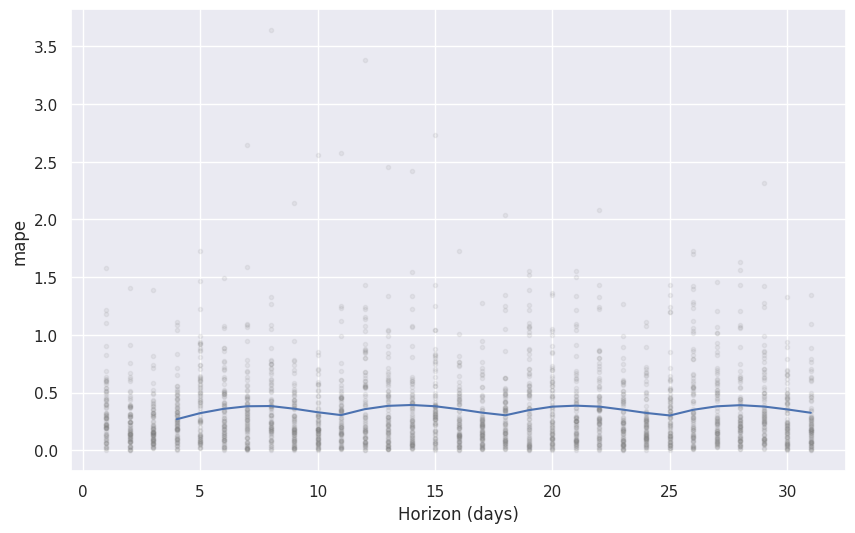

In [57]:
plot_cross_validation_metric(cv_results, metric='mape');

## Total Prediction (no train test split, _"split=1"_)

In [59]:
# total_Shops_Number_sales
prophet_total_shops_sales = prophet_model(
    total_sales_df,
    split=1,
    seas_scale=10,
    inter_w=0.80,
    freq=freq_analysis
)

# total_Shops_Values
prophet_total_shops_values = prophet_model(
    total_values_df,
    split=1,
    seas_scale=10,
    inter_w=0.80,
    freq=freq_analysis
)

19:21:45 - cmdstanpy - INFO - Chain [1] start processing
19:21:45 - cmdstanpy - INFO - Chain [1] done processing
19:21:45 - cmdstanpy - INFO - Chain [1] start processing
19:21:45 - cmdstanpy - INFO - Chain [1] done processing


In [60]:
def get_forecast_data(prophet_dict: dict):
    """
    Input is the dict return of the prophet_model function.
    Get the forecast for the predictions, by days (61), weeks (4) or month (2).
    """
    row_start = prophet_dict['train'].shape[0]+1
    df = prophet_dict['forecast'][row_start:][['ds', 'yhat']]
    
    day_pred = df[['ds']].join(df['yhat'].round(2))
    week_pred = day_pred.resample('w', on='ds').mean().round(2).head(8)
    month_pred = day_pred.resample('m', on='ds').mean().round(2).head(2)
    
    forecast = {
        'day': day_pred,
        'week': week_pred,
        'month': month_pred
    }
    
    return forecast

In [61]:
all_shops_sales_pred = get_forecast_data(prophet_total_shops_sales)
all_shops_values_pred = get_forecast_data(prophet_total_shops_values)

### Prediction (sales and values) for "only" the next month, all shops

In [62]:
# SALES
all_shops_sales_pred = all_shops_sales_pred['month']['yhat'][0]
all_shops_sales_pred

2091.6

In [63]:
# VALUES
all_shops_values_pred = all_shops_values_pred['month']['yhat'][0]
all_shops_values_pred

3225336.29

##  Shop Prediction

### Save and Load Models functions

In [74]:
# Save models to file
def save_model_data(prophet: dict, name: str, save=True):
    """
    Input is the prophet dict return of the prophet_model function.
    name: name of the file to be saved, in .json
    save: save the results in a external file
    Convert Prophet model to json file.
    Convert Data Frame to json file.
    Saves the model and all the data in the local /raw_data/prophet of the project
    Saves only the model in the /prophet_models, local and git repository.
    """
    if not save:
        return "=== Model Not Saved ==="
    
    print("=== Model Saved ===")
    models = {}
    id_dict = {}
    
    # loop over the ids and features to build a dict with json files
    for id in prophet:
        feature_dict = {}
        feature_dict['model'] = prophet[id]['model']
        feature_dict['forecast'] = prophet[id]['forecast'].copy()
        feature_dict['train'] = prophet[id]['train'].copy()
        feature_dict['test'] = prophet[id]['test'].copy()
        id_dict[id] = feature_dict
        
        # prophet model to json
        id_dict[id]['model'] = model_to_json(id_dict[id]['model'])
        
        # dict with all the models
        models[id] = id_dict[id]['model']
        
        # DF to json
        id_dict[id]['forecast'] = id_dict[id]['forecast'].to_json()
        id_dict[id]['train'] = id_dict[id]['train'].to_json()
        id_dict[id]['test'] = id_dict[id]['test'].to_json()
    
    # save model and data localy
    with open('../raw_data/prophet/' + name + '.json', 'w') as prophet_dict:
        json.dump(id_dict, prophet_dict)
    
    # save model on git repository dir
    with open('../prophet_models/' + name + '.json', 'w') as prophet_models:
        json.dump(models, prophet_models)
            
    pass

In [65]:
# Load models from file
def load_model(file_name: str, path=PATH_MODELS) -> dict:
    file_name = file_name + '.json'
    path = os.path.join(PATH_MODELS, file_name)

    with open(path, 'r') as prophet_models:
            models_json = json.load(prophet_models)

    models = {}
    for id in models_json:
        models[id] = model_from_json(models_json[id])
        
    return models

In [66]:
# Rum prophet or load model result
def run_load_model(df, load=False, model_name="", freq='d'):
    df_id_list = df.columns.to_list()
    prophet_id = {}    
    
    if load:
        print("=== Model Loaded from File ===")
        models = load_model(model_name)
        for id in df_id_list:
            df_ids = df[id].fillna(0)
            prophet_result = prophet_loaded_model(df_ids, models[id], freq=freq)
            prophet_id[id] = prophet_result        
        
        return prophet_id
    
    print("=== Running Prophet Model from Scratch ===")
    for id in df_id_list:
        df_ids = df[id].fillna(0)
        prophet_result = prophet_model(
            df=df_ids,
            split=1,
            seas_scale=10,
            inter_w=0.80,
            freq=freq_analysis
        )
        prophet_id[id] = prophet_result
    
    return prophet_id

### Sales

In [67]:
print(LOADED)

False


In [68]:
%%time
# initialize model for each shop id
prophet_shops_id_sales = run_load_model(
    df=shops_sales,
    load=LOADED,
    model_name="prophet_shops_id_sales",
    freq=freq_analysis)

19:23:21 - cmdstanpy - INFO - Chain [1] start processing


=== Running Prophet Model from Scratch ===


19:23:21 - cmdstanpy - INFO - Chain [1] done processing
19:23:22 - cmdstanpy - INFO - Chain [1] start processing
19:23:22 - cmdstanpy - INFO - Chain [1] done processing
19:23:22 - cmdstanpy - INFO - Chain [1] start processing
19:23:22 - cmdstanpy - INFO - Chain [1] done processing
19:23:23 - cmdstanpy - INFO - Chain [1] start processing
19:23:23 - cmdstanpy - INFO - Chain [1] done processing
19:23:23 - cmdstanpy - INFO - Chain [1] start processing
19:23:23 - cmdstanpy - INFO - Chain [1] done processing
19:23:24 - cmdstanpy - INFO - Chain [1] start processing
19:23:24 - cmdstanpy - INFO - Chain [1] done processing
19:23:24 - cmdstanpy - INFO - Chain [1] start processing
19:23:24 - cmdstanpy - INFO - Chain [1] done processing
19:23:25 - cmdstanpy - INFO - Chain [1] start processing
19:23:25 - cmdstanpy - INFO - Chain [1] done processing
19:23:25 - cmdstanpy - INFO - Chain [1] start processing
19:23:26 - cmdstanpy - INFO - Chain [1] done processing
19:23:26 - cmdstanpy - INFO - Chain [1] 

CPU times: user 32.4 s, sys: 35.1 s, total: 1min 7s
Wall time: 27.6 s


In [70]:
# get the prediction for "only" the next month for every shop
shops_id_sales_pred = {}
for shop in prophet_shops_id_sales:
    pred = prophet_shops_id_sales[shop]
    pred = get_forecast_data(pred)
    shops_id_sales_pred[shop] = pred['month']['yhat'][0]

<font size="5"> Total Sales for next month, sun of all shops </font>

In [71]:
all_shops_id_sales_pred = sum(list(shops_id_sales_pred.values()))
all_shops_id_sales_pred

2376.6200000000003

#### Save the data (on _raw\_data_) and model (on _git_) in json file

In [72]:
print(SAVED)

True


In [75]:
save_model_data(prophet_shops_id_sales, 'prophet_shops_id_sales', save=SAVED)

=== Model Saved ===


#### Plot example

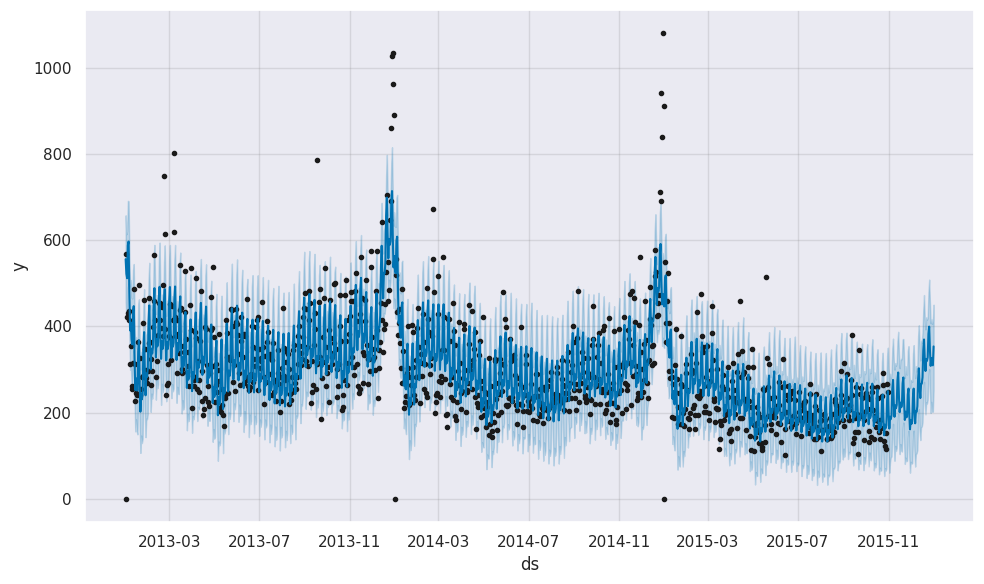

In [76]:
prophet_shops_id_sales['shop_id_31']['model'].plot(prophet_shops_id_sales['shop_id_31']['forecast']);

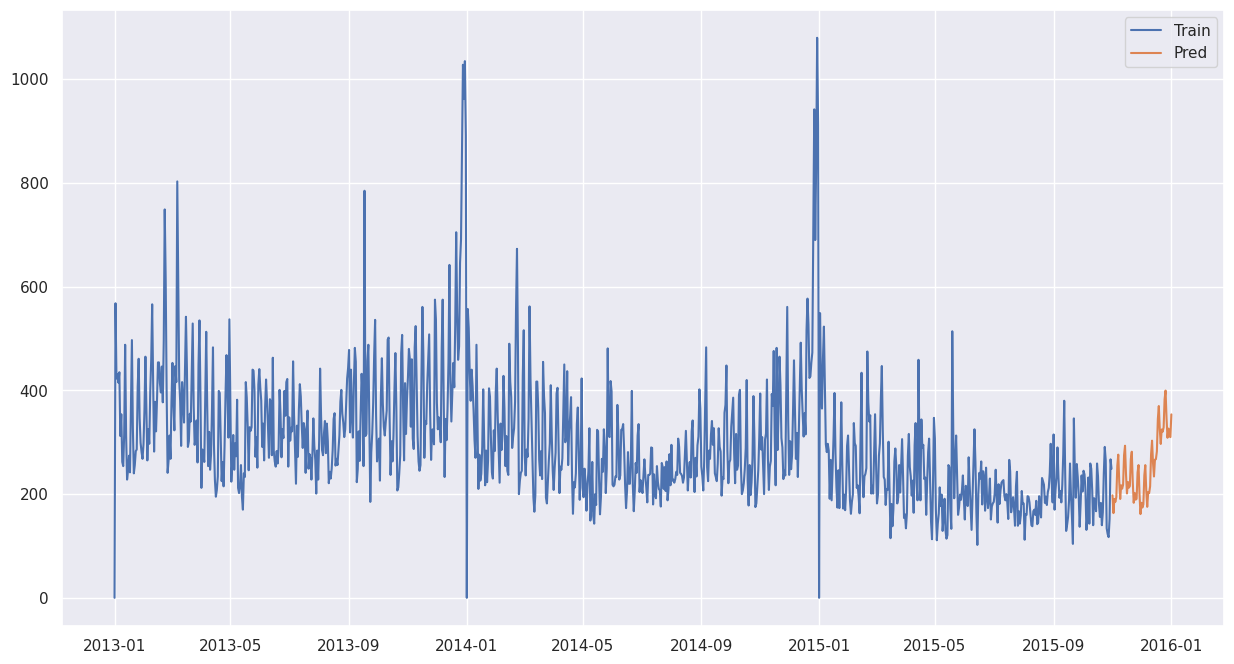

In [77]:
plot_forecast(prophet_shops_id_sales['shop_id_31'], test=False)

### Values

In [79]:
%%time
# initialize model for each shop id
prophet_shops_id_values = run_load_model(
    df=shops_values,
    load=LOADED,
    model_name="prophet_shops_id_values",
    freq=freq_analysis)

19:26:26 - cmdstanpy - INFO - Chain [1] start processing


=== Running Prophet Model from Scratch ===


19:26:26 - cmdstanpy - INFO - Chain [1] done processing
19:26:26 - cmdstanpy - INFO - Chain [1] start processing
19:26:26 - cmdstanpy - INFO - Chain [1] done processing
19:26:27 - cmdstanpy - INFO - Chain [1] start processing
19:26:27 - cmdstanpy - INFO - Chain [1] done processing
19:26:27 - cmdstanpy - INFO - Chain [1] start processing
19:26:27 - cmdstanpy - INFO - Chain [1] done processing
19:26:27 - cmdstanpy - INFO - Chain [1] start processing
19:26:28 - cmdstanpy - INFO - Chain [1] done processing
19:26:28 - cmdstanpy - INFO - Chain [1] start processing
19:26:28 - cmdstanpy - INFO - Chain [1] done processing
19:26:28 - cmdstanpy - INFO - Chain [1] start processing
19:26:28 - cmdstanpy - INFO - Chain [1] done processing
19:26:29 - cmdstanpy - INFO - Chain [1] start processing
19:26:29 - cmdstanpy - INFO - Chain [1] done processing
19:26:29 - cmdstanpy - INFO - Chain [1] start processing
19:26:29 - cmdstanpy - INFO - Chain [1] done processing
19:26:30 - cmdstanpy - INFO - Chain [1] 

CPU times: user 33.1 s, sys: 34.4 s, total: 1min 7s
Wall time: 26.7 s


In [80]:
# get the prediction for "only" the next month for every shop
shops_id_values_pred = {}
for shop in prophet_shops_id_values:
    pred = prophet_shops_id_values[shop]
    pred = get_forecast_data(pred)
    shops_id_values_pred[shop] = pred['month']['yhat'][0]

<font size="5"> Total Values for next month, sun of all shops </font>

In [81]:
all_shops_id_values_pred = sum(list(shops_id_values_pred.values()))
all_shops_id_values_pred

3395246.9699999997

#### Save the data (on raw_data) and model (on git) in json file

In [82]:
save_model_data(prophet_shops_id_values, 'prophet_shops_id_values', save=SAVED)

=== Model Saved ===


#### Plot example

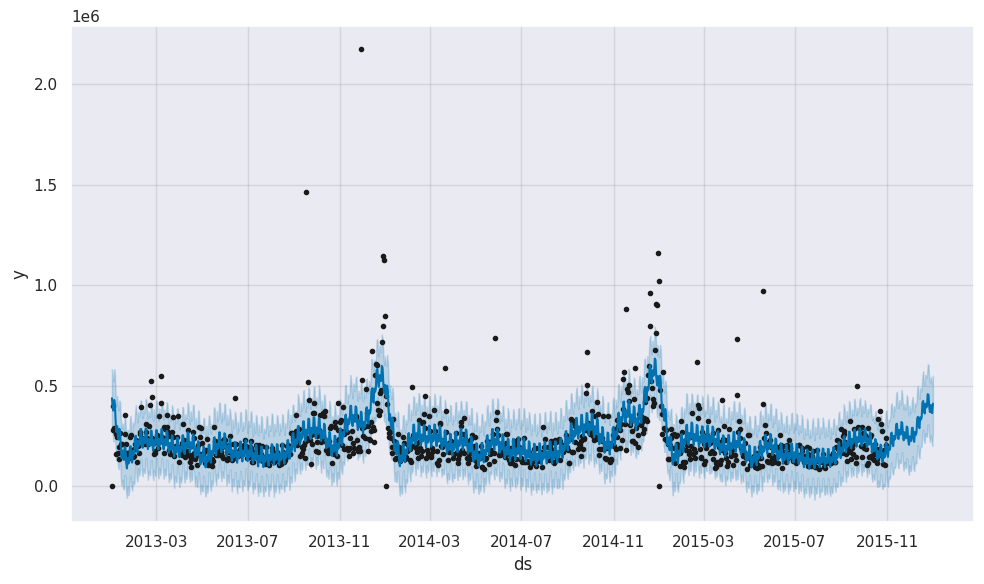

In [83]:
prophet_shops_id_values['shop_id_31']['model'].plot(prophet_shops_id_values['shop_id_31']['forecast']);

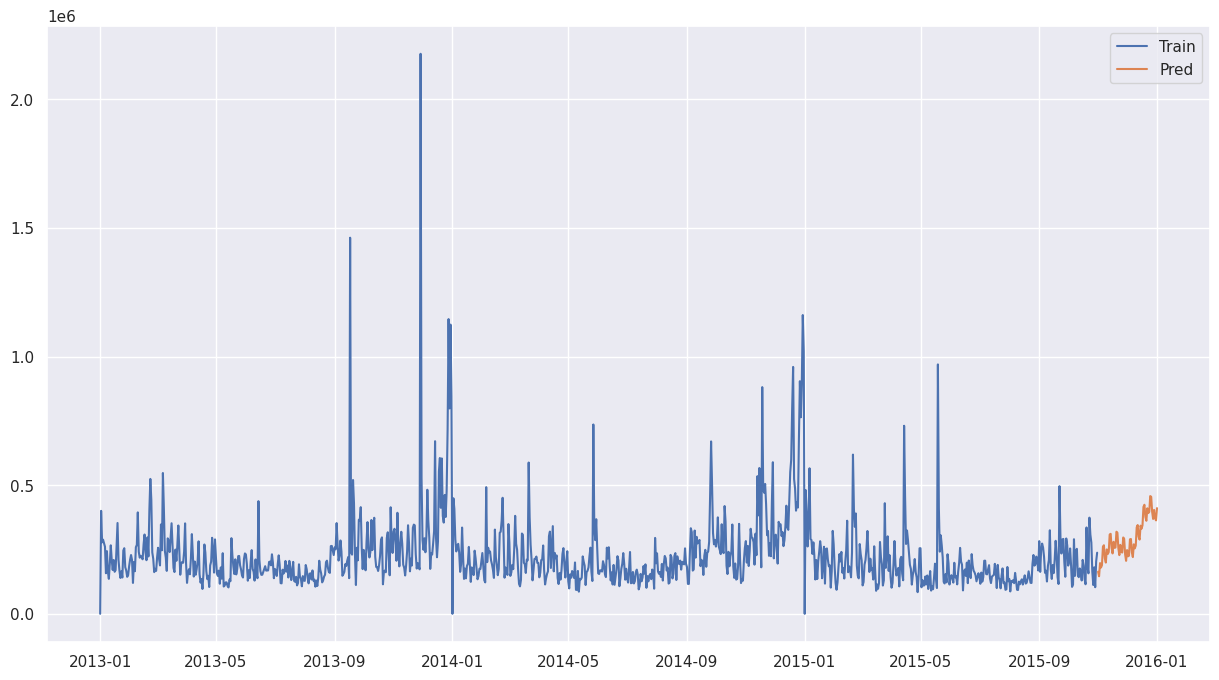

In [84]:
plot_forecast(prophet_shops_id_values['shop_id_31'], test=False)

## Category Prediction

### Sales

In [85]:
%%time
# initialize model for each category id
prophet_cats_id_sales = run_load_model(
    df=cats_sales,
    load=LOADED,
    model_name="prophet_cats_id_sales",
    freq=freq_analysis)

19:27:40 - cmdstanpy - INFO - Chain [1] start processing
19:27:40 - cmdstanpy - INFO - Chain [1] done processing


=== Running Prophet Model from Scratch ===


19:27:40 - cmdstanpy - INFO - Chain [1] start processing
19:27:40 - cmdstanpy - INFO - Chain [1] done processing
19:27:41 - cmdstanpy - INFO - Chain [1] start processing
19:27:41 - cmdstanpy - INFO - Chain [1] done processing
19:27:41 - cmdstanpy - INFO - Chain [1] start processing
19:27:41 - cmdstanpy - INFO - Chain [1] done processing
19:27:41 - cmdstanpy - INFO - Chain [1] start processing
19:27:41 - cmdstanpy - INFO - Chain [1] done processing
19:27:42 - cmdstanpy - INFO - Chain [1] start processing
19:27:42 - cmdstanpy - INFO - Chain [1] done processing
19:27:42 - cmdstanpy - INFO - Chain [1] start processing
19:27:42 - cmdstanpy - INFO - Chain [1] done processing
19:27:43 - cmdstanpy - INFO - Chain [1] start processing
19:27:43 - cmdstanpy - INFO - Chain [1] done processing
19:27:43 - cmdstanpy - INFO - Chain [1] start processing
19:27:43 - cmdstanpy - INFO - Chain [1] done processing
19:27:43 - cmdstanpy - INFO - Chain [1] start processing
19:27:44 - cmdstanpy - INFO - Chain [1]

19:28:14 - cmdstanpy - INFO - Chain [1] done processing
19:28:14 - cmdstanpy - INFO - Chain [1] start processing
19:28:14 - cmdstanpy - INFO - Chain [1] done processing
19:28:14 - cmdstanpy - INFO - Chain [1] start processing
19:28:15 - cmdstanpy - INFO - Chain [1] done processing
19:28:15 - cmdstanpy - INFO - Chain [1] start processing
19:28:15 - cmdstanpy - INFO - Chain [1] done processing
19:28:15 - cmdstanpy - INFO - Chain [1] start processing
19:28:15 - cmdstanpy - INFO - Chain [1] done processing
19:28:16 - cmdstanpy - INFO - Chain [1] start processing
19:28:16 - cmdstanpy - INFO - Chain [1] done processing
19:28:16 - cmdstanpy - INFO - Chain [1] start processing
19:28:16 - cmdstanpy - INFO - Chain [1] done processing
19:28:17 - cmdstanpy - INFO - Chain [1] start processing
19:28:17 - cmdstanpy - INFO - Chain [1] done processing
19:28:17 - cmdstanpy - INFO - Chain [1] start processing
19:28:17 - cmdstanpy - INFO - Chain [1] done processing
19:28:18 - cmdstanpy - INFO - Chain [1] 

CPU times: user 45.9 s, sys: 49.2 s, total: 1min 35s
Wall time: 38.9 s


In [86]:
# get the prediction for "only" the next month for every category
cats_id_sales_pred = {}
for cat in prophet_cats_id_sales:
    pred = prophet_cats_id_sales[cat]
    pred = get_forecast_data(pred)
    cats_id_sales_pred[cat] = pred['month']['yhat'][0]

<font size="5"> Total Sales for next month, sun of all categories </font>

In [87]:
all_cats_id_sales_pred = sum(list(cats_id_sales_pred.values())).round(2)
all_cats_id_sales_pred

2595.8

#### Save the data (on raw_data) and model (on git) in json file

In [88]:
save_model_data(prophet_cats_id_sales, 'prophet_cats_id_sales', save=SAVED)

=== Model Saved ===


#### Plot Example

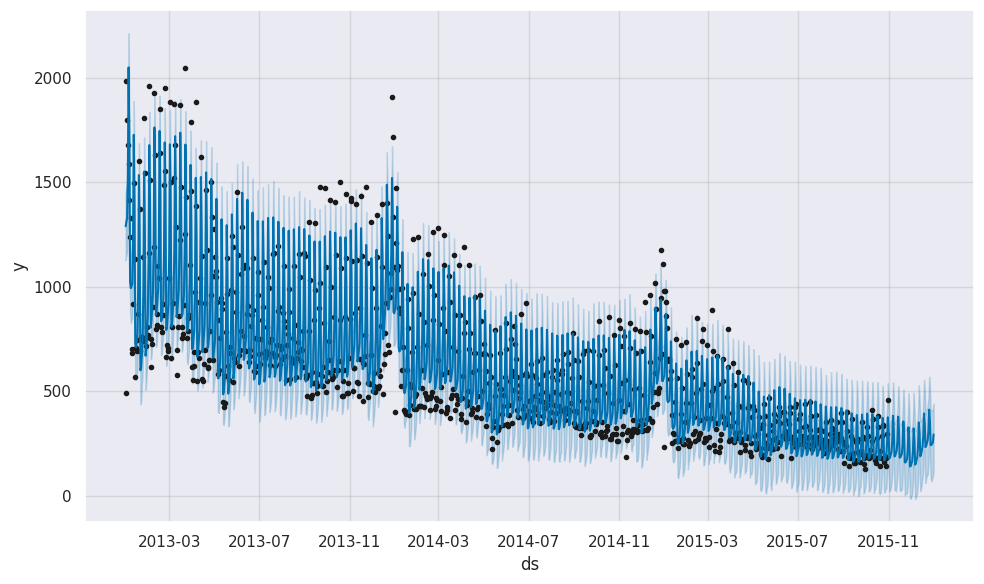

In [89]:
prophet_cats_id_sales['cat_id_40']['model'].plot(prophet_cats_id_sales['cat_id_40']['forecast']);

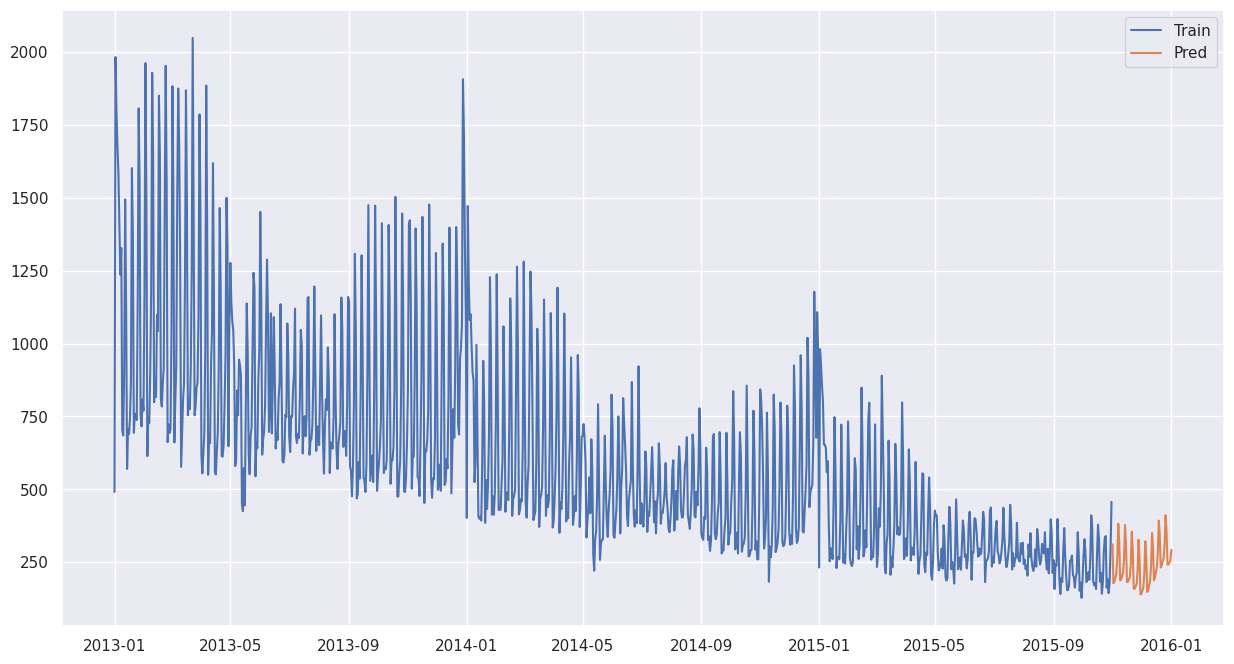

In [90]:
plot_forecast(prophet_cats_id_sales['cat_id_40'], test=False)

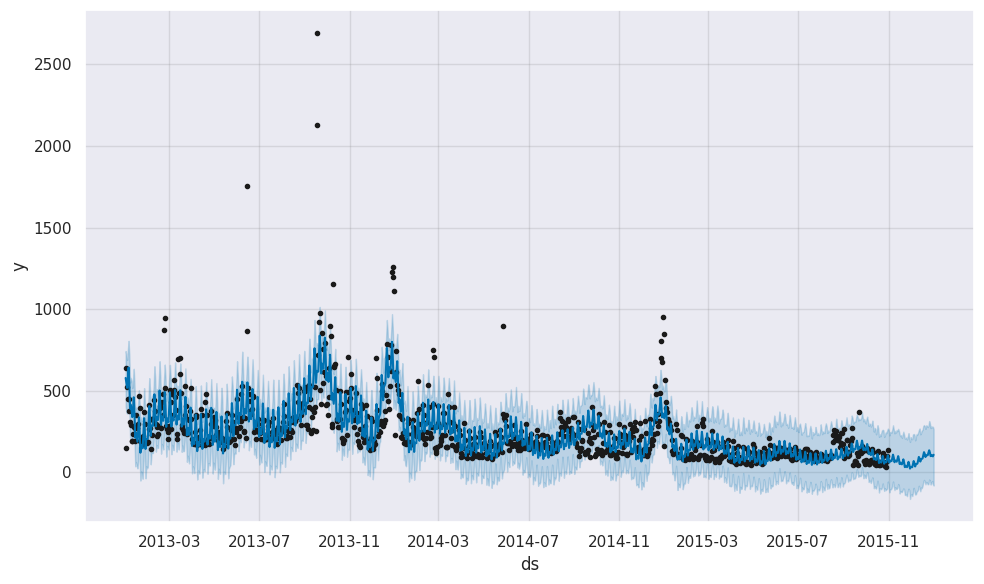

In [91]:
prophet_cats_id_sales['cat_id_19']['model'].plot(prophet_cats_id_sales['cat_id_19']['forecast']);

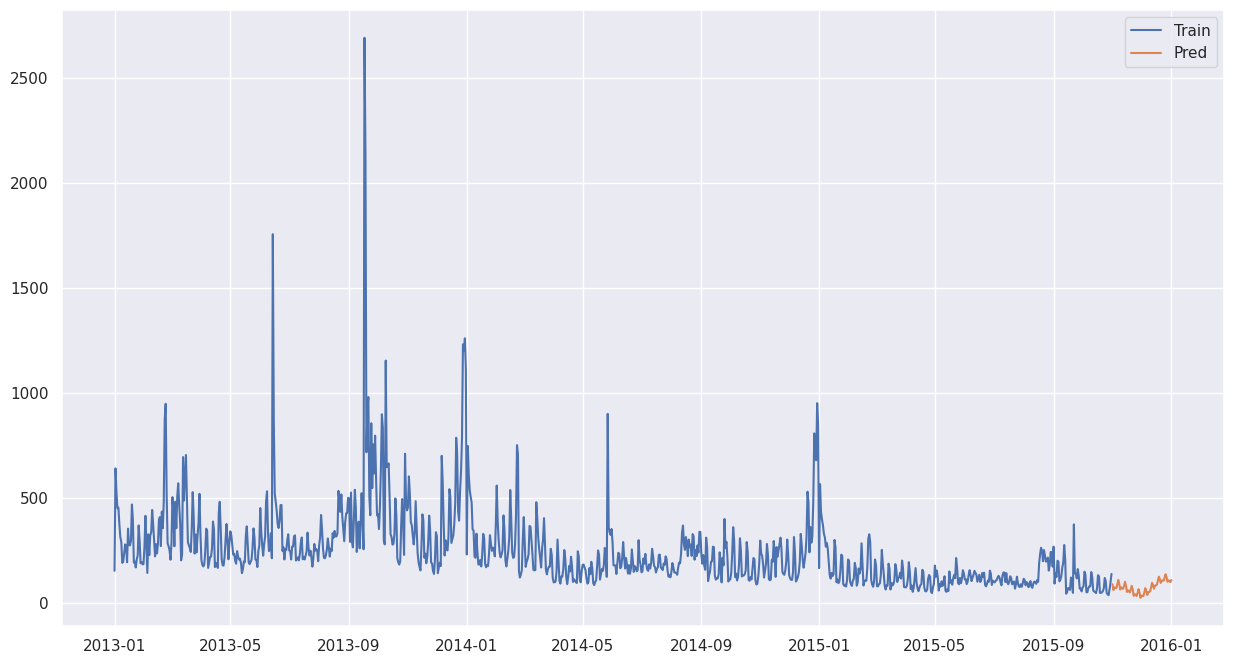

In [92]:
plot_forecast(prophet_cats_id_sales['cat_id_19'], test=False)

### Values

In [93]:
%%time
# initialize model for each category id
prophet_cats_id_values = run_load_model(
    df=cats_values,
    load=LOADED,
    model_name="prophet_cats_id_values",
    freq=freq_analysis)

19:29:22 - cmdstanpy - INFO - Chain [1] start processing


=== Running Prophet Model from Scratch ===


19:29:22 - cmdstanpy - INFO - Chain [1] done processing
19:29:23 - cmdstanpy - INFO - Chain [1] start processing
19:29:23 - cmdstanpy - INFO - Chain [1] done processing
19:29:23 - cmdstanpy - INFO - Chain [1] start processing
19:29:23 - cmdstanpy - INFO - Chain [1] done processing
19:29:24 - cmdstanpy - INFO - Chain [1] start processing
19:29:24 - cmdstanpy - INFO - Chain [1] done processing
19:29:24 - cmdstanpy - INFO - Chain [1] start processing
19:29:24 - cmdstanpy - INFO - Chain [1] done processing
19:29:25 - cmdstanpy - INFO - Chain [1] start processing
19:29:25 - cmdstanpy - INFO - Chain [1] done processing
19:29:25 - cmdstanpy - INFO - Chain [1] start processing
19:29:25 - cmdstanpy - INFO - Chain [1] done processing
19:29:25 - cmdstanpy - INFO - Chain [1] start processing
19:29:26 - cmdstanpy - INFO - Chain [1] done processing
19:29:26 - cmdstanpy - INFO - Chain [1] start processing
19:29:26 - cmdstanpy - INFO - Chain [1] done processing
19:29:26 - cmdstanpy - INFO - Chain [1] 

19:29:58 - cmdstanpy - INFO - Chain [1] done processing
19:29:59 - cmdstanpy - INFO - Chain [1] start processing
19:29:59 - cmdstanpy - INFO - Chain [1] done processing
19:29:59 - cmdstanpy - INFO - Chain [1] start processing
19:29:59 - cmdstanpy - INFO - Chain [1] done processing
19:30:00 - cmdstanpy - INFO - Chain [1] start processing
19:30:00 - cmdstanpy - INFO - Chain [1] done processing
19:30:00 - cmdstanpy - INFO - Chain [1] start processing
19:30:00 - cmdstanpy - INFO - Chain [1] done processing
19:30:01 - cmdstanpy - INFO - Chain [1] start processing
19:30:01 - cmdstanpy - INFO - Chain [1] done processing
19:30:01 - cmdstanpy - INFO - Chain [1] start processing
19:30:01 - cmdstanpy - INFO - Chain [1] done processing
19:30:02 - cmdstanpy - INFO - Chain [1] start processing
19:30:02 - cmdstanpy - INFO - Chain [1] done processing
19:30:02 - cmdstanpy - INFO - Chain [1] start processing
19:30:02 - cmdstanpy - INFO - Chain [1] done processing
19:30:03 - cmdstanpy - INFO - Chain [1] 

CPU times: user 46.5 s, sys: 47.4 s, total: 1min 33s
Wall time: 41.3 s


In [94]:
# get the prediction for "only" the next month for every category
cats_id_values_pred = {}
for cat in prophet_cats_id_values:
    pred = prophet_cats_id_values[cat]
    pred = get_forecast_data(pred)
    cats_id_values_pred[cat] = pred['month']['yhat'][0]

<font size="5"> Total Values for next month, sun of all categories </font>

In [95]:
all_cats_id_values_pred = sum(list(cats_id_values_pred.values())).round(2)
all_cats_id_values_pred

3577287.16

#### Save the data (on raw_data) and model (on git) in json file

In [96]:
save_model_data(prophet_cats_id_values, 'prophet_cats_id_values', save=SAVED)

=== Model Saved ===


#### Plot Example

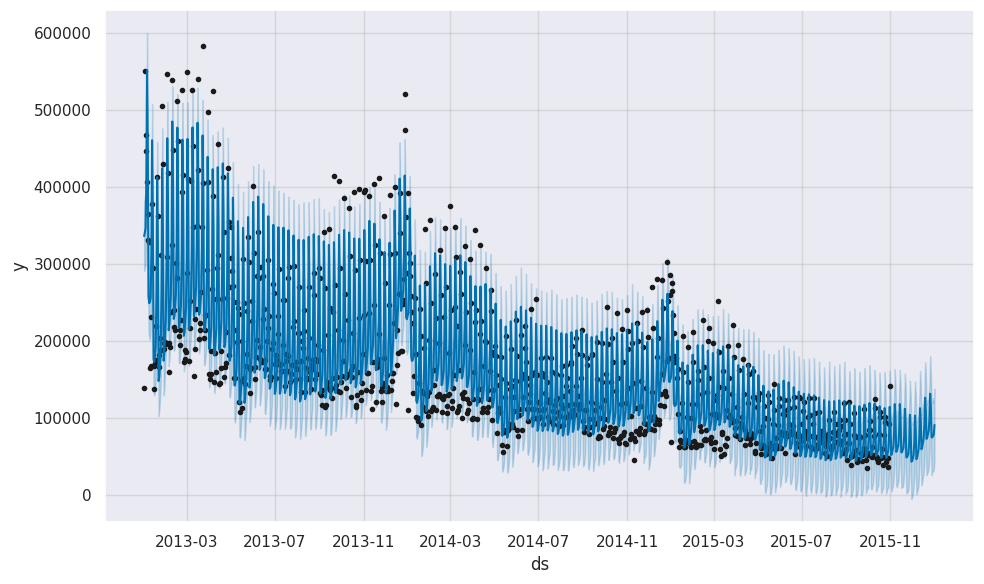

In [97]:
prophet_cats_id_values['cat_id_40']['model'].plot(prophet_cats_id_values['cat_id_40']['forecast']);

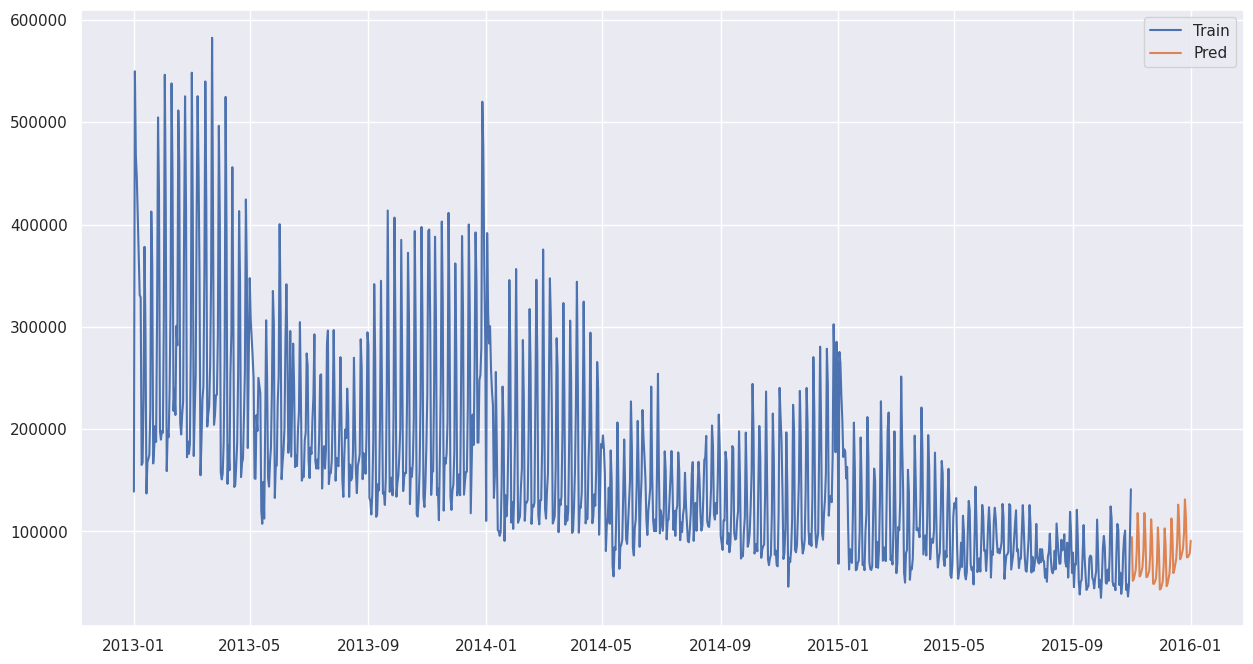

In [98]:
plot_forecast(prophet_cats_id_values['cat_id_40'], test=False)

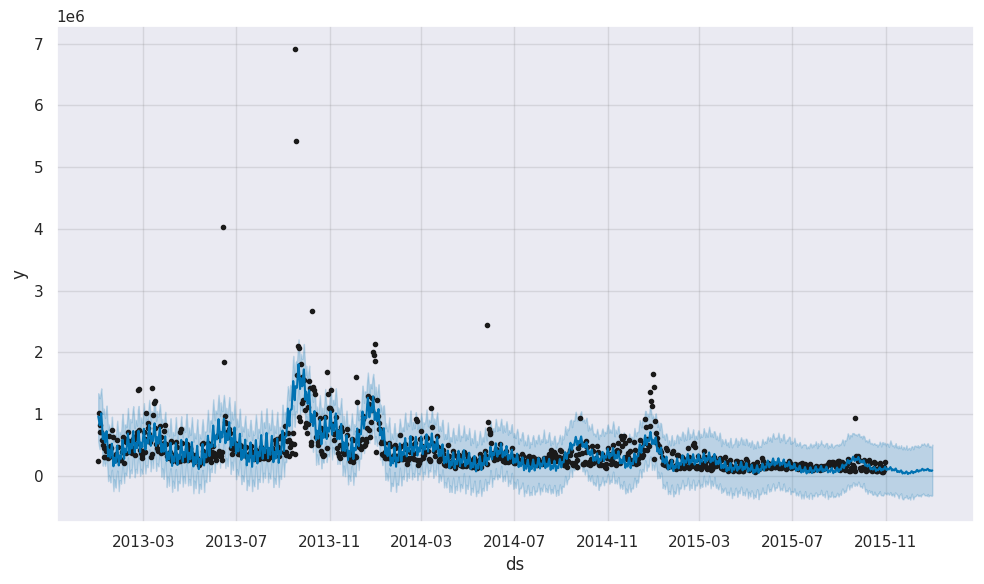

In [99]:
prophet_cats_id_values['cat_id_19']['model'].plot(prophet_cats_id_values['cat_id_19']['forecast']);

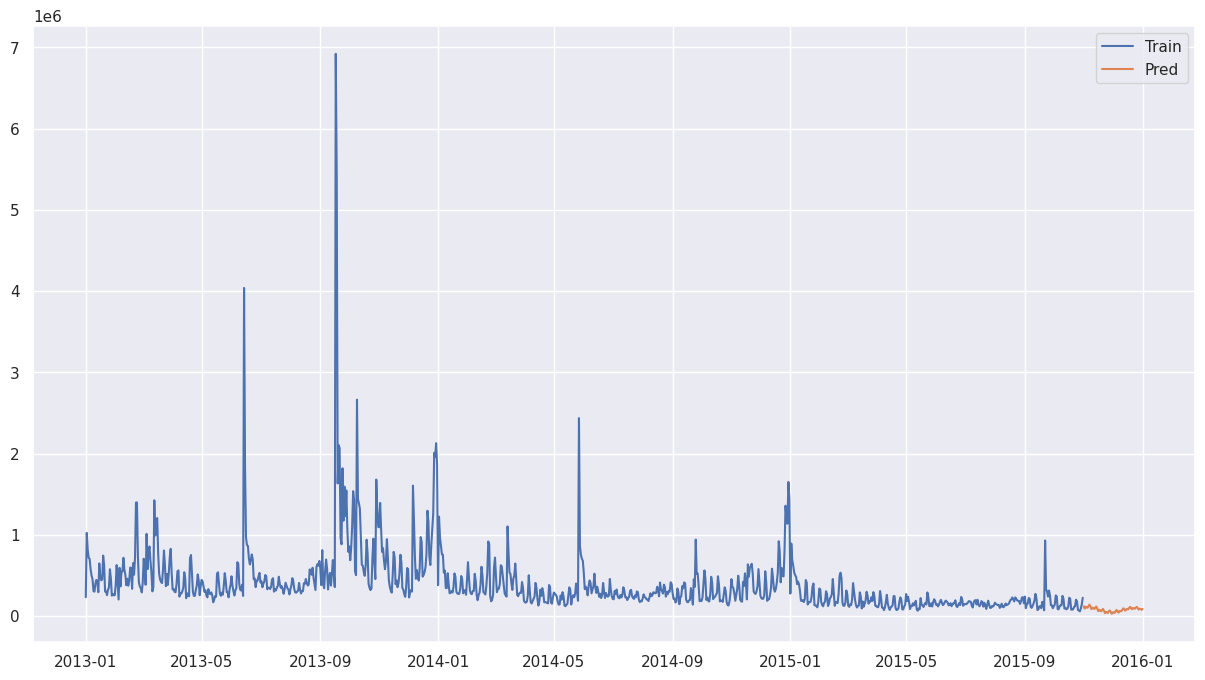

In [100]:
plot_forecast(prophet_cats_id_values['cat_id_19'], test=False)

## Item Prediction

### Sales

In [412]:
%%time
# initialize model for each category id
prophet_items_id_sales = run_load_model(
    df=items_sales,
    load=LOADED,
    model_name="prophet_items_id_sales",
    freq=freq_analysis)

23:35:00 - cmdstanpy - INFO - Chain [1] start processing
23:35:00 - cmdstanpy - INFO - Chain [1] done processing


=== Running Prophet Model from Scratch ===


23:35:00 - cmdstanpy - INFO - Chain [1] start processing
23:35:00 - cmdstanpy - INFO - Chain [1] done processing
23:35:01 - cmdstanpy - INFO - Chain [1] start processing
23:35:01 - cmdstanpy - INFO - Chain [1] done processing
23:35:01 - cmdstanpy - INFO - Chain [1] start processing
23:35:01 - cmdstanpy - INFO - Chain [1] done processing
23:35:02 - cmdstanpy - INFO - Chain [1] start processing
23:35:02 - cmdstanpy - INFO - Chain [1] done processing
23:35:02 - cmdstanpy - INFO - Chain [1] start processing
23:35:02 - cmdstanpy - INFO - Chain [1] done processing
23:35:03 - cmdstanpy - INFO - Chain [1] start processing
23:35:03 - cmdstanpy - INFO - Chain [1] done processing
23:35:03 - cmdstanpy - INFO - Chain [1] start processing
23:35:03 - cmdstanpy - INFO - Chain [1] done processing
23:35:04 - cmdstanpy - INFO - Chain [1] start processing
23:35:04 - cmdstanpy - INFO - Chain [1] done processing
23:35:04 - cmdstanpy - INFO - Chain [1] start processing
23:35:04 - cmdstanpy - INFO - Chain [1]

23:35:33 - cmdstanpy - INFO - Chain [1] done processing
23:35:33 - cmdstanpy - INFO - Chain [1] start processing
23:35:33 - cmdstanpy - INFO - Chain [1] done processing
23:35:33 - cmdstanpy - INFO - Chain [1] start processing
23:35:34 - cmdstanpy - INFO - Chain [1] done processing
23:35:34 - cmdstanpy - INFO - Chain [1] start processing
23:35:34 - cmdstanpy - INFO - Chain [1] done processing
23:35:34 - cmdstanpy - INFO - Chain [1] start processing
23:35:34 - cmdstanpy - INFO - Chain [1] done processing
23:35:35 - cmdstanpy - INFO - Chain [1] start processing
23:35:35 - cmdstanpy - INFO - Chain [1] done processing
23:35:36 - cmdstanpy - INFO - Chain [1] start processing
23:35:36 - cmdstanpy - INFO - Chain [1] done processing
23:35:36 - cmdstanpy - INFO - Chain [1] start processing
23:35:36 - cmdstanpy - INFO - Chain [1] done processing
23:35:36 - cmdstanpy - INFO - Chain [1] start processing
23:35:36 - cmdstanpy - INFO - Chain [1] done processing
23:35:37 - cmdstanpy - INFO - Chain [1] 

23:36:07 - cmdstanpy - INFO - Chain [1] done processing
23:36:08 - cmdstanpy - INFO - Chain [1] start processing
23:36:08 - cmdstanpy - INFO - Chain [1] done processing
23:36:08 - cmdstanpy - INFO - Chain [1] start processing
23:36:08 - cmdstanpy - INFO - Chain [1] done processing
23:36:08 - cmdstanpy - INFO - Chain [1] start processing
23:36:08 - cmdstanpy - INFO - Chain [1] done processing
23:36:09 - cmdstanpy - INFO - Chain [1] start processing
23:36:09 - cmdstanpy - INFO - Chain [1] done processing
23:36:09 - cmdstanpy - INFO - Chain [1] start processing
23:36:10 - cmdstanpy - INFO - Chain [1] done processing
23:36:10 - cmdstanpy - INFO - Chain [1] start processing
23:36:10 - cmdstanpy - INFO - Chain [1] done processing
23:36:11 - cmdstanpy - INFO - Chain [1] start processing
23:36:11 - cmdstanpy - INFO - Chain [1] done processing
23:36:11 - cmdstanpy - INFO - Chain [1] start processing
23:36:11 - cmdstanpy - INFO - Chain [1] done processing
23:36:12 - cmdstanpy - INFO - Chain [1] 

23:36:41 - cmdstanpy - INFO - Chain [1] done processing
23:36:41 - cmdstanpy - INFO - Chain [1] start processing
23:36:41 - cmdstanpy - INFO - Chain [1] done processing
23:36:41 - cmdstanpy - INFO - Chain [1] start processing
23:36:41 - cmdstanpy - INFO - Chain [1] done processing
23:36:42 - cmdstanpy - INFO - Chain [1] start processing
23:36:42 - cmdstanpy - INFO - Chain [1] done processing
23:36:42 - cmdstanpy - INFO - Chain [1] start processing
23:36:42 - cmdstanpy - INFO - Chain [1] done processing
23:36:43 - cmdstanpy - INFO - Chain [1] start processing
23:36:43 - cmdstanpy - INFO - Chain [1] done processing
23:36:43 - cmdstanpy - INFO - Chain [1] start processing
23:36:43 - cmdstanpy - INFO - Chain [1] done processing
23:36:44 - cmdstanpy - INFO - Chain [1] start processing
23:36:44 - cmdstanpy - INFO - Chain [1] done processing
23:36:44 - cmdstanpy - INFO - Chain [1] start processing
23:36:45 - cmdstanpy - INFO - Chain [1] done processing
23:36:45 - cmdstanpy - INFO - Chain [1] 

23:37:16 - cmdstanpy - INFO - Chain [1] done processing
23:37:16 - cmdstanpy - INFO - Chain [1] start processing
23:37:16 - cmdstanpy - INFO - Chain [1] done processing
23:37:17 - cmdstanpy - INFO - Chain [1] start processing
23:37:17 - cmdstanpy - INFO - Chain [1] done processing
23:37:18 - cmdstanpy - INFO - Chain [1] start processing
23:37:18 - cmdstanpy - INFO - Chain [1] done processing
23:37:18 - cmdstanpy - INFO - Chain [1] start processing
23:37:18 - cmdstanpy - INFO - Chain [1] done processing
23:37:18 - cmdstanpy - INFO - Chain [1] start processing
23:37:18 - cmdstanpy - INFO - Chain [1] done processing
23:37:19 - cmdstanpy - INFO - Chain [1] start processing
23:37:19 - cmdstanpy - INFO - Chain [1] done processing
23:37:19 - cmdstanpy - INFO - Chain [1] start processing
23:37:19 - cmdstanpy - INFO - Chain [1] done processing
23:37:19 - cmdstanpy - INFO - Chain [1] start processing
23:37:20 - cmdstanpy - INFO - Chain [1] done processing
23:37:20 - cmdstanpy - INFO - Chain [1] 

23:37:53 - cmdstanpy - INFO - Chain [1] done processing
23:37:53 - cmdstanpy - INFO - Chain [1] start processing
23:37:53 - cmdstanpy - INFO - Chain [1] done processing
23:37:53 - cmdstanpy - INFO - Chain [1] start processing
23:37:54 - cmdstanpy - INFO - Chain [1] done processing
23:37:54 - cmdstanpy - INFO - Chain [1] start processing
23:37:54 - cmdstanpy - INFO - Chain [1] done processing
23:37:54 - cmdstanpy - INFO - Chain [1] start processing
23:37:54 - cmdstanpy - INFO - Chain [1] done processing
23:37:55 - cmdstanpy - INFO - Chain [1] start processing
23:37:55 - cmdstanpy - INFO - Chain [1] done processing
23:37:55 - cmdstanpy - INFO - Chain [1] start processing
23:37:55 - cmdstanpy - INFO - Chain [1] done processing
23:37:56 - cmdstanpy - INFO - Chain [1] start processing
23:37:56 - cmdstanpy - INFO - Chain [1] done processing
23:37:56 - cmdstanpy - INFO - Chain [1] start processing
23:37:57 - cmdstanpy - INFO - Chain [1] done processing
23:37:57 - cmdstanpy - INFO - Chain [1] 

23:38:28 - cmdstanpy - INFO - Chain [1] done processing
23:38:28 - cmdstanpy - INFO - Chain [1] start processing
23:38:29 - cmdstanpy - INFO - Chain [1] done processing
23:38:29 - cmdstanpy - INFO - Chain [1] start processing
23:38:29 - cmdstanpy - INFO - Chain [1] done processing
23:38:30 - cmdstanpy - INFO - Chain [1] start processing
23:38:30 - cmdstanpy - INFO - Chain [1] done processing
23:38:30 - cmdstanpy - INFO - Chain [1] start processing
23:38:30 - cmdstanpy - INFO - Chain [1] done processing
23:38:31 - cmdstanpy - INFO - Chain [1] start processing
23:38:31 - cmdstanpy - INFO - Chain [1] done processing
23:38:32 - cmdstanpy - INFO - Chain [1] start processing
23:38:32 - cmdstanpy - INFO - Chain [1] done processing
23:38:32 - cmdstanpy - INFO - Chain [1] start processing
23:38:32 - cmdstanpy - INFO - Chain [1] done processing
23:38:32 - cmdstanpy - INFO - Chain [1] start processing
23:38:32 - cmdstanpy - INFO - Chain [1] done processing
23:38:33 - cmdstanpy - INFO - Chain [1] 

23:39:03 - cmdstanpy - INFO - Chain [1] done processing
23:39:04 - cmdstanpy - INFO - Chain [1] start processing
23:39:04 - cmdstanpy - INFO - Chain [1] done processing
23:39:04 - cmdstanpy - INFO - Chain [1] start processing
23:39:04 - cmdstanpy - INFO - Chain [1] done processing
23:39:05 - cmdstanpy - INFO - Chain [1] start processing
23:39:05 - cmdstanpy - INFO - Chain [1] done processing
23:39:05 - cmdstanpy - INFO - Chain [1] start processing
23:39:06 - cmdstanpy - INFO - Chain [1] done processing
23:39:06 - cmdstanpy - INFO - Chain [1] start processing
23:39:06 - cmdstanpy - INFO - Chain [1] done processing
23:39:06 - cmdstanpy - INFO - Chain [1] start processing
23:39:06 - cmdstanpy - INFO - Chain [1] done processing
23:39:07 - cmdstanpy - INFO - Chain [1] start processing
23:39:07 - cmdstanpy - INFO - Chain [1] done processing
23:39:07 - cmdstanpy - INFO - Chain [1] start processing
23:39:07 - cmdstanpy - INFO - Chain [1] done processing
23:39:08 - cmdstanpy - INFO - Chain [1] 

23:39:41 - cmdstanpy - INFO - Chain [1] done processing
23:39:41 - cmdstanpy - INFO - Chain [1] start processing
23:39:41 - cmdstanpy - INFO - Chain [1] done processing
23:39:41 - cmdstanpy - INFO - Chain [1] start processing
23:39:41 - cmdstanpy - INFO - Chain [1] done processing
23:39:42 - cmdstanpy - INFO - Chain [1] start processing
23:39:42 - cmdstanpy - INFO - Chain [1] done processing
23:39:43 - cmdstanpy - INFO - Chain [1] start processing
23:39:43 - cmdstanpy - INFO - Chain [1] done processing
23:39:43 - cmdstanpy - INFO - Chain [1] start processing
23:39:43 - cmdstanpy - INFO - Chain [1] done processing
23:39:43 - cmdstanpy - INFO - Chain [1] start processing
23:39:44 - cmdstanpy - INFO - Chain [1] done processing
23:39:44 - cmdstanpy - INFO - Chain [1] start processing
23:39:44 - cmdstanpy - INFO - Chain [1] done processing
23:39:44 - cmdstanpy - INFO - Chain [1] start processing
23:39:44 - cmdstanpy - INFO - Chain [1] done processing
23:39:45 - cmdstanpy - INFO - Chain [1] 

23:40:16 - cmdstanpy - INFO - Chain [1] done processing
23:40:17 - cmdstanpy - INFO - Chain [1] start processing
23:40:17 - cmdstanpy - INFO - Chain [1] done processing
23:40:17 - cmdstanpy - INFO - Chain [1] start processing
23:40:17 - cmdstanpy - INFO - Chain [1] done processing
23:40:17 - cmdstanpy - INFO - Chain [1] start processing
23:40:18 - cmdstanpy - INFO - Chain [1] done processing
23:40:18 - cmdstanpy - INFO - Chain [1] start processing
23:40:18 - cmdstanpy - INFO - Chain [1] done processing
23:40:18 - cmdstanpy - INFO - Chain [1] start processing
23:40:19 - cmdstanpy - INFO - Chain [1] done processing
23:40:19 - cmdstanpy - INFO - Chain [1] start processing
23:40:20 - cmdstanpy - INFO - Chain [1] done processing
23:40:20 - cmdstanpy - INFO - Chain [1] start processing
23:40:20 - cmdstanpy - INFO - Chain [1] done processing
23:40:20 - cmdstanpy - INFO - Chain [1] start processing
23:40:20 - cmdstanpy - INFO - Chain [1] done processing
23:40:21 - cmdstanpy - INFO - Chain [1] 

23:40:54 - cmdstanpy - INFO - Chain [1] done processing
23:40:54 - cmdstanpy - INFO - Chain [1] start processing
23:40:54 - cmdstanpy - INFO - Chain [1] done processing
23:40:54 - cmdstanpy - INFO - Chain [1] start processing
23:40:54 - cmdstanpy - INFO - Chain [1] done processing
23:40:55 - cmdstanpy - INFO - Chain [1] start processing
23:40:55 - cmdstanpy - INFO - Chain [1] done processing
23:40:55 - cmdstanpy - INFO - Chain [1] start processing
23:40:55 - cmdstanpy - INFO - Chain [1] done processing
23:40:56 - cmdstanpy - INFO - Chain [1] start processing
23:40:56 - cmdstanpy - INFO - Chain [1] done processing
23:40:56 - cmdstanpy - INFO - Chain [1] start processing
23:40:56 - cmdstanpy - INFO - Chain [1] done processing
23:40:57 - cmdstanpy - INFO - Chain [1] start processing
23:40:57 - cmdstanpy - INFO - Chain [1] done processing
23:40:57 - cmdstanpy - INFO - Chain [1] start processing
23:40:57 - cmdstanpy - INFO - Chain [1] done processing
23:40:58 - cmdstanpy - INFO - Chain [1] 

23:41:30 - cmdstanpy - INFO - Chain [1] done processing
23:41:30 - cmdstanpy - INFO - Chain [1] start processing
23:41:30 - cmdstanpy - INFO - Chain [1] done processing
23:41:31 - cmdstanpy - INFO - Chain [1] start processing
23:41:31 - cmdstanpy - INFO - Chain [1] done processing
23:41:31 - cmdstanpy - INFO - Chain [1] start processing
23:41:32 - cmdstanpy - INFO - Chain [1] done processing
23:41:32 - cmdstanpy - INFO - Chain [1] start processing
23:41:32 - cmdstanpy - INFO - Chain [1] done processing
23:41:32 - cmdstanpy - INFO - Chain [1] start processing
23:41:32 - cmdstanpy - INFO - Chain [1] done processing
23:41:33 - cmdstanpy - INFO - Chain [1] start processing
23:41:33 - cmdstanpy - INFO - Chain [1] done processing
23:41:33 - cmdstanpy - INFO - Chain [1] start processing
23:41:33 - cmdstanpy - INFO - Chain [1] done processing
23:41:34 - cmdstanpy - INFO - Chain [1] start processing
23:41:34 - cmdstanpy - INFO - Chain [1] done processing
23:41:34 - cmdstanpy - INFO - Chain [1] 

23:42:05 - cmdstanpy - INFO - Chain [1] done processing
23:42:05 - cmdstanpy - INFO - Chain [1] start processing
23:42:05 - cmdstanpy - INFO - Chain [1] done processing
23:42:06 - cmdstanpy - INFO - Chain [1] start processing
23:42:06 - cmdstanpy - INFO - Chain [1] done processing
23:42:06 - cmdstanpy - INFO - Chain [1] start processing
23:42:06 - cmdstanpy - INFO - Chain [1] done processing
23:42:07 - cmdstanpy - INFO - Chain [1] start processing
23:42:07 - cmdstanpy - INFO - Chain [1] done processing
23:42:07 - cmdstanpy - INFO - Chain [1] start processing
23:42:07 - cmdstanpy - INFO - Chain [1] done processing
23:42:08 - cmdstanpy - INFO - Chain [1] start processing
23:42:08 - cmdstanpy - INFO - Chain [1] done processing
23:42:09 - cmdstanpy - INFO - Chain [1] start processing
23:42:09 - cmdstanpy - INFO - Chain [1] done processing
23:42:09 - cmdstanpy - INFO - Chain [1] start processing
23:42:09 - cmdstanpy - INFO - Chain [1] done processing
23:42:09 - cmdstanpy - INFO - Chain [1] 

23:42:42 - cmdstanpy - INFO - Chain [1] done processing
23:42:42 - cmdstanpy - INFO - Chain [1] start processing
23:42:42 - cmdstanpy - INFO - Chain [1] done processing
23:42:43 - cmdstanpy - INFO - Chain [1] start processing
23:42:43 - cmdstanpy - INFO - Chain [1] done processing
23:42:43 - cmdstanpy - INFO - Chain [1] start processing
23:42:43 - cmdstanpy - INFO - Chain [1] done processing
23:42:44 - cmdstanpy - INFO - Chain [1] start processing
23:42:44 - cmdstanpy - INFO - Chain [1] done processing
23:42:45 - cmdstanpy - INFO - Chain [1] start processing
23:42:45 - cmdstanpy - INFO - Chain [1] done processing
23:42:45 - cmdstanpy - INFO - Chain [1] start processing
23:42:45 - cmdstanpy - INFO - Chain [1] done processing
23:42:45 - cmdstanpy - INFO - Chain [1] start processing
23:42:46 - cmdstanpy - INFO - Chain [1] done processing
23:42:46 - cmdstanpy - INFO - Chain [1] start processing
23:42:46 - cmdstanpy - INFO - Chain [1] done processing
23:42:46 - cmdstanpy - INFO - Chain [1] 

23:43:17 - cmdstanpy - INFO - Chain [1] done processing
23:43:18 - cmdstanpy - INFO - Chain [1] start processing
23:43:18 - cmdstanpy - INFO - Chain [1] done processing
23:43:18 - cmdstanpy - INFO - Chain [1] start processing
23:43:18 - cmdstanpy - INFO - Chain [1] done processing
23:43:18 - cmdstanpy - INFO - Chain [1] start processing
23:43:18 - cmdstanpy - INFO - Chain [1] done processing
23:43:19 - cmdstanpy - INFO - Chain [1] start processing
23:43:19 - cmdstanpy - INFO - Chain [1] done processing
23:43:19 - cmdstanpy - INFO - Chain [1] start processing
23:43:19 - cmdstanpy - INFO - Chain [1] done processing
23:43:20 - cmdstanpy - INFO - Chain [1] start processing
23:43:20 - cmdstanpy - INFO - Chain [1] done processing
23:43:20 - cmdstanpy - INFO - Chain [1] start processing
23:43:20 - cmdstanpy - INFO - Chain [1] done processing
23:43:20 - cmdstanpy - INFO - Chain [1] start processing
23:43:20 - cmdstanpy - INFO - Chain [1] done processing
23:43:21 - cmdstanpy - INFO - Chain [1] 

23:43:56 - cmdstanpy - INFO - Chain [1] done processing
23:43:57 - cmdstanpy - INFO - Chain [1] start processing
23:43:57 - cmdstanpy - INFO - Chain [1] done processing
23:43:57 - cmdstanpy - INFO - Chain [1] start processing
23:43:57 - cmdstanpy - INFO - Chain [1] done processing
23:43:58 - cmdstanpy - INFO - Chain [1] start processing
23:43:58 - cmdstanpy - INFO - Chain [1] done processing
23:43:58 - cmdstanpy - INFO - Chain [1] start processing
23:43:58 - cmdstanpy - INFO - Chain [1] done processing
23:43:59 - cmdstanpy - INFO - Chain [1] start processing
23:43:59 - cmdstanpy - INFO - Chain [1] done processing
23:43:59 - cmdstanpy - INFO - Chain [1] start processing
23:43:59 - cmdstanpy - INFO - Chain [1] done processing
23:44:00 - cmdstanpy - INFO - Chain [1] start processing
23:44:00 - cmdstanpy - INFO - Chain [1] done processing
23:44:00 - cmdstanpy - INFO - Chain [1] start processing
23:44:00 - cmdstanpy - INFO - Chain [1] done processing
23:44:01 - cmdstanpy - INFO - Chain [1] 

23:44:35 - cmdstanpy - INFO - Chain [1] done processing
23:44:35 - cmdstanpy - INFO - Chain [1] start processing
23:44:35 - cmdstanpy - INFO - Chain [1] done processing
23:44:36 - cmdstanpy - INFO - Chain [1] start processing
23:44:36 - cmdstanpy - INFO - Chain [1] done processing
23:44:36 - cmdstanpy - INFO - Chain [1] start processing
23:44:36 - cmdstanpy - INFO - Chain [1] done processing
23:44:37 - cmdstanpy - INFO - Chain [1] start processing
23:44:37 - cmdstanpy - INFO - Chain [1] done processing
23:44:37 - cmdstanpy - INFO - Chain [1] start processing
23:44:37 - cmdstanpy - INFO - Chain [1] done processing
23:44:38 - cmdstanpy - INFO - Chain [1] start processing
23:44:38 - cmdstanpy - INFO - Chain [1] done processing
23:44:38 - cmdstanpy - INFO - Chain [1] start processing
23:44:38 - cmdstanpy - INFO - Chain [1] done processing
23:44:39 - cmdstanpy - INFO - Chain [1] start processing
23:44:39 - cmdstanpy - INFO - Chain [1] done processing
23:44:40 - cmdstanpy - INFO - Chain [1] 

23:45:13 - cmdstanpy - INFO - Chain [1] done processing
23:45:13 - cmdstanpy - INFO - Chain [1] start processing
23:45:14 - cmdstanpy - INFO - Chain [1] done processing
23:45:14 - cmdstanpy - INFO - Chain [1] start processing
23:45:14 - cmdstanpy - INFO - Chain [1] done processing
23:45:15 - cmdstanpy - INFO - Chain [1] start processing
23:45:15 - cmdstanpy - INFO - Chain [1] done processing
23:45:15 - cmdstanpy - INFO - Chain [1] start processing
23:45:15 - cmdstanpy - INFO - Chain [1] done processing
23:45:16 - cmdstanpy - INFO - Chain [1] start processing
23:45:16 - cmdstanpy - INFO - Chain [1] done processing
23:45:16 - cmdstanpy - INFO - Chain [1] start processing
23:45:16 - cmdstanpy - INFO - Chain [1] done processing
23:45:16 - cmdstanpy - INFO - Chain [1] start processing
23:45:17 - cmdstanpy - INFO - Chain [1] done processing
23:45:17 - cmdstanpy - INFO - Chain [1] start processing
23:45:17 - cmdstanpy - INFO - Chain [1] done processing
23:45:17 - cmdstanpy - INFO - Chain [1] 

23:45:51 - cmdstanpy - INFO - Chain [1] done processing
23:45:52 - cmdstanpy - INFO - Chain [1] start processing
23:45:52 - cmdstanpy - INFO - Chain [1] done processing
23:45:52 - cmdstanpy - INFO - Chain [1] start processing
23:45:52 - cmdstanpy - INFO - Chain [1] done processing
23:45:53 - cmdstanpy - INFO - Chain [1] start processing
23:45:53 - cmdstanpy - INFO - Chain [1] done processing
23:45:53 - cmdstanpy - INFO - Chain [1] start processing
23:45:53 - cmdstanpy - INFO - Chain [1] done processing
23:45:53 - cmdstanpy - INFO - Chain [1] start processing
23:45:53 - cmdstanpy - INFO - Chain [1] done processing
23:45:54 - cmdstanpy - INFO - Chain [1] start processing
23:45:54 - cmdstanpy - INFO - Chain [1] done processing
23:45:54 - cmdstanpy - INFO - Chain [1] start processing
23:45:54 - cmdstanpy - INFO - Chain [1] done processing
23:45:55 - cmdstanpy - INFO - Chain [1] start processing
23:45:55 - cmdstanpy - INFO - Chain [1] done processing
23:45:55 - cmdstanpy - INFO - Chain [1] 

23:46:29 - cmdstanpy - INFO - Chain [1] done processing
23:46:30 - cmdstanpy - INFO - Chain [1] start processing
23:46:30 - cmdstanpy - INFO - Chain [1] done processing
23:46:30 - cmdstanpy - INFO - Chain [1] start processing
23:46:30 - cmdstanpy - INFO - Chain [1] done processing
23:46:31 - cmdstanpy - INFO - Chain [1] start processing
23:46:31 - cmdstanpy - INFO - Chain [1] done processing
23:46:31 - cmdstanpy - INFO - Chain [1] start processing
23:46:32 - cmdstanpy - INFO - Chain [1] done processing
23:46:32 - cmdstanpy - INFO - Chain [1] start processing
23:46:32 - cmdstanpy - INFO - Chain [1] done processing
23:46:32 - cmdstanpy - INFO - Chain [1] start processing
23:46:32 - cmdstanpy - INFO - Chain [1] done processing
23:46:33 - cmdstanpy - INFO - Chain [1] start processing
23:46:33 - cmdstanpy - INFO - Chain [1] done processing
23:46:33 - cmdstanpy - INFO - Chain [1] start processing
23:46:33 - cmdstanpy - INFO - Chain [1] done processing
23:46:34 - cmdstanpy - INFO - Chain [1] 

23:47:08 - cmdstanpy - INFO - Chain [1] done processing
23:47:08 - cmdstanpy - INFO - Chain [1] start processing
23:47:09 - cmdstanpy - INFO - Chain [1] done processing
23:47:09 - cmdstanpy - INFO - Chain [1] start processing
23:47:09 - cmdstanpy - INFO - Chain [1] done processing
23:47:09 - cmdstanpy - INFO - Chain [1] start processing
23:47:09 - cmdstanpy - INFO - Chain [1] done processing
23:47:10 - cmdstanpy - INFO - Chain [1] start processing
23:47:10 - cmdstanpy - INFO - Chain [1] done processing
23:47:11 - cmdstanpy - INFO - Chain [1] start processing
23:47:11 - cmdstanpy - INFO - Chain [1] done processing
23:47:11 - cmdstanpy - INFO - Chain [1] start processing
23:47:11 - cmdstanpy - INFO - Chain [1] done processing
23:47:12 - cmdstanpy - INFO - Chain [1] start processing
23:47:12 - cmdstanpy - INFO - Chain [1] done processing
23:47:12 - cmdstanpy - INFO - Chain [1] start processing
23:47:12 - cmdstanpy - INFO - Chain [1] done processing
23:47:12 - cmdstanpy - INFO - Chain [1] 

23:47:47 - cmdstanpy - INFO - Chain [1] done processing
23:47:48 - cmdstanpy - INFO - Chain [1] start processing
23:47:48 - cmdstanpy - INFO - Chain [1] done processing
23:47:48 - cmdstanpy - INFO - Chain [1] start processing
23:47:48 - cmdstanpy - INFO - Chain [1] done processing
23:47:48 - cmdstanpy - INFO - Chain [1] start processing
23:47:48 - cmdstanpy - INFO - Chain [1] done processing
23:47:49 - cmdstanpy - INFO - Chain [1] start processing
23:47:49 - cmdstanpy - INFO - Chain [1] done processing
23:47:49 - cmdstanpy - INFO - Chain [1] start processing
23:47:49 - cmdstanpy - INFO - Chain [1] done processing
23:47:50 - cmdstanpy - INFO - Chain [1] start processing
23:47:50 - cmdstanpy - INFO - Chain [1] done processing
23:47:50 - cmdstanpy - INFO - Chain [1] start processing
23:47:50 - cmdstanpy - INFO - Chain [1] done processing
23:47:50 - cmdstanpy - INFO - Chain [1] start processing
23:47:51 - cmdstanpy - INFO - Chain [1] done processing
23:47:52 - cmdstanpy - INFO - Chain [1] 

23:48:23 - cmdstanpy - INFO - Chain [1] done processing
23:48:24 - cmdstanpy - INFO - Chain [1] start processing
23:48:24 - cmdstanpy - INFO - Chain [1] done processing
23:48:24 - cmdstanpy - INFO - Chain [1] start processing
23:48:24 - cmdstanpy - INFO - Chain [1] done processing
23:48:25 - cmdstanpy - INFO - Chain [1] start processing
23:48:25 - cmdstanpy - INFO - Chain [1] done processing
23:48:26 - cmdstanpy - INFO - Chain [1] start processing
23:48:26 - cmdstanpy - INFO - Chain [1] done processing
23:48:26 - cmdstanpy - INFO - Chain [1] start processing
23:48:26 - cmdstanpy - INFO - Chain [1] done processing
23:48:27 - cmdstanpy - INFO - Chain [1] start processing
23:48:27 - cmdstanpy - INFO - Chain [1] done processing
23:48:27 - cmdstanpy - INFO - Chain [1] start processing
23:48:27 - cmdstanpy - INFO - Chain [1] done processing
23:48:27 - cmdstanpy - INFO - Chain [1] start processing
23:48:28 - cmdstanpy - INFO - Chain [1] done processing
23:48:28 - cmdstanpy - INFO - Chain [1] 

23:49:01 - cmdstanpy - INFO - Chain [1] done processing
23:49:02 - cmdstanpy - INFO - Chain [1] start processing
23:49:02 - cmdstanpy - INFO - Chain [1] done processing
23:49:02 - cmdstanpy - INFO - Chain [1] start processing
23:49:02 - cmdstanpy - INFO - Chain [1] done processing
23:49:03 - cmdstanpy - INFO - Chain [1] start processing
23:49:03 - cmdstanpy - INFO - Chain [1] done processing
23:49:03 - cmdstanpy - INFO - Chain [1] start processing
23:49:03 - cmdstanpy - INFO - Chain [1] done processing
23:49:03 - cmdstanpy - INFO - Chain [1] start processing
23:49:03 - cmdstanpy - INFO - Chain [1] done processing
23:49:04 - cmdstanpy - INFO - Chain [1] start processing
23:49:04 - cmdstanpy - INFO - Chain [1] done processing
23:49:04 - cmdstanpy - INFO - Chain [1] start processing
23:49:04 - cmdstanpy - INFO - Chain [1] done processing
23:49:05 - cmdstanpy - INFO - Chain [1] start processing
23:49:05 - cmdstanpy - INFO - Chain [1] done processing
23:49:05 - cmdstanpy - INFO - Chain [1] 

23:49:39 - cmdstanpy - INFO - Chain [1] done processing
23:49:39 - cmdstanpy - INFO - Chain [1] start processing
23:49:39 - cmdstanpy - INFO - Chain [1] done processing
23:49:40 - cmdstanpy - INFO - Chain [1] start processing
23:49:40 - cmdstanpy - INFO - Chain [1] done processing
23:49:40 - cmdstanpy - INFO - Chain [1] start processing
23:49:40 - cmdstanpy - INFO - Chain [1] done processing
23:49:41 - cmdstanpy - INFO - Chain [1] start processing
23:49:41 - cmdstanpy - INFO - Chain [1] done processing
23:49:41 - cmdstanpy - INFO - Chain [1] start processing
23:49:41 - cmdstanpy - INFO - Chain [1] done processing
23:49:42 - cmdstanpy - INFO - Chain [1] start processing
23:49:42 - cmdstanpy - INFO - Chain [1] done processing
23:49:43 - cmdstanpy - INFO - Chain [1] start processing
23:49:43 - cmdstanpy - INFO - Chain [1] done processing
23:49:43 - cmdstanpy - INFO - Chain [1] start processing
23:49:43 - cmdstanpy - INFO - Chain [1] done processing
23:49:43 - cmdstanpy - INFO - Chain [1] 

23:50:15 - cmdstanpy - INFO - Chain [1] done processing
23:50:15 - cmdstanpy - INFO - Chain [1] start processing
23:50:16 - cmdstanpy - INFO - Chain [1] done processing
23:50:16 - cmdstanpy - INFO - Chain [1] start processing
23:50:16 - cmdstanpy - INFO - Chain [1] done processing
23:50:17 - cmdstanpy - INFO - Chain [1] start processing
23:50:17 - cmdstanpy - INFO - Chain [1] done processing
23:50:17 - cmdstanpy - INFO - Chain [1] start processing
23:50:17 - cmdstanpy - INFO - Chain [1] done processing
23:50:18 - cmdstanpy - INFO - Chain [1] start processing
23:50:18 - cmdstanpy - INFO - Chain [1] done processing
23:50:19 - cmdstanpy - INFO - Chain [1] start processing
23:50:19 - cmdstanpy - INFO - Chain [1] done processing
23:50:19 - cmdstanpy - INFO - Chain [1] start processing
23:50:19 - cmdstanpy - INFO - Chain [1] done processing
23:50:19 - cmdstanpy - INFO - Chain [1] start processing
23:50:19 - cmdstanpy - INFO - Chain [1] done processing
23:50:20 - cmdstanpy - INFO - Chain [1] 

23:50:53 - cmdstanpy - INFO - Chain [1] done processing
23:50:53 - cmdstanpy - INFO - Chain [1] start processing
23:50:54 - cmdstanpy - INFO - Chain [1] done processing
23:50:54 - cmdstanpy - INFO - Chain [1] start processing
23:50:54 - cmdstanpy - INFO - Chain [1] done processing
23:50:54 - cmdstanpy - INFO - Chain [1] start processing
23:50:54 - cmdstanpy - INFO - Chain [1] done processing
23:50:56 - cmdstanpy - INFO - Chain [1] start processing
23:50:56 - cmdstanpy - INFO - Chain [1] done processing
23:50:56 - cmdstanpy - INFO - Chain [1] start processing
23:50:56 - cmdstanpy - INFO - Chain [1] done processing
23:50:56 - cmdstanpy - INFO - Chain [1] start processing
23:50:56 - cmdstanpy - INFO - Chain [1] done processing
23:50:57 - cmdstanpy - INFO - Chain [1] start processing
23:50:57 - cmdstanpy - INFO - Chain [1] done processing
23:50:57 - cmdstanpy - INFO - Chain [1] start processing
23:50:57 - cmdstanpy - INFO - Chain [1] done processing
23:50:58 - cmdstanpy - INFO - Chain [1] 

23:51:30 - cmdstanpy - INFO - Chain [1] done processing
23:51:31 - cmdstanpy - INFO - Chain [1] start processing
23:51:31 - cmdstanpy - INFO - Chain [1] done processing
23:51:31 - cmdstanpy - INFO - Chain [1] start processing
23:51:31 - cmdstanpy - INFO - Chain [1] done processing
23:51:32 - cmdstanpy - INFO - Chain [1] start processing
23:51:32 - cmdstanpy - INFO - Chain [1] done processing
23:51:33 - cmdstanpy - INFO - Chain [1] start processing
23:51:33 - cmdstanpy - INFO - Chain [1] done processing
23:51:33 - cmdstanpy - INFO - Chain [1] start processing
23:51:33 - cmdstanpy - INFO - Chain [1] done processing
23:51:33 - cmdstanpy - INFO - Chain [1] start processing
23:51:34 - cmdstanpy - INFO - Chain [1] done processing
23:51:34 - cmdstanpy - INFO - Chain [1] start processing
23:51:34 - cmdstanpy - INFO - Chain [1] done processing
23:51:34 - cmdstanpy - INFO - Chain [1] start processing
23:51:34 - cmdstanpy - INFO - Chain [1] done processing
23:51:35 - cmdstanpy - INFO - Chain [1] 

23:52:08 - cmdstanpy - INFO - Chain [1] done processing
23:52:08 - cmdstanpy - INFO - Chain [1] start processing
23:52:08 - cmdstanpy - INFO - Chain [1] done processing
23:52:09 - cmdstanpy - INFO - Chain [1] start processing
23:52:09 - cmdstanpy - INFO - Chain [1] done processing
23:52:10 - cmdstanpy - INFO - Chain [1] start processing
23:52:10 - cmdstanpy - INFO - Chain [1] done processing
23:52:10 - cmdstanpy - INFO - Chain [1] start processing
23:52:10 - cmdstanpy - INFO - Chain [1] done processing
23:52:11 - cmdstanpy - INFO - Chain [1] start processing
23:52:11 - cmdstanpy - INFO - Chain [1] done processing
23:52:11 - cmdstanpy - INFO - Chain [1] start processing
23:52:12 - cmdstanpy - INFO - Chain [1] done processing
23:52:12 - cmdstanpy - INFO - Chain [1] start processing
23:52:12 - cmdstanpy - INFO - Chain [1] done processing
23:52:12 - cmdstanpy - INFO - Chain [1] start processing
23:52:12 - cmdstanpy - INFO - Chain [1] done processing
23:52:13 - cmdstanpy - INFO - Chain [1] 

23:52:45 - cmdstanpy - INFO - Chain [1] done processing
23:52:46 - cmdstanpy - INFO - Chain [1] start processing
23:52:46 - cmdstanpy - INFO - Chain [1] done processing
23:52:46 - cmdstanpy - INFO - Chain [1] start processing
23:52:46 - cmdstanpy - INFO - Chain [1] done processing
23:52:47 - cmdstanpy - INFO - Chain [1] start processing
23:52:47 - cmdstanpy - INFO - Chain [1] done processing
23:52:47 - cmdstanpy - INFO - Chain [1] start processing
23:52:47 - cmdstanpy - INFO - Chain [1] done processing
23:52:48 - cmdstanpy - INFO - Chain [1] start processing
23:52:48 - cmdstanpy - INFO - Chain [1] done processing
23:52:49 - cmdstanpy - INFO - Chain [1] start processing
23:52:49 - cmdstanpy - INFO - Chain [1] done processing
23:52:49 - cmdstanpy - INFO - Chain [1] start processing
23:52:49 - cmdstanpy - INFO - Chain [1] done processing
23:52:50 - cmdstanpy - INFO - Chain [1] start processing
23:52:50 - cmdstanpy - INFO - Chain [1] done processing
23:52:50 - cmdstanpy - INFO - Chain [1] 

23:53:27 - cmdstanpy - INFO - Chain [1] done processing
23:53:27 - cmdstanpy - INFO - Chain [1] start processing
23:53:28 - cmdstanpy - INFO - Chain [1] done processing
23:53:28 - cmdstanpy - INFO - Chain [1] start processing
23:53:28 - cmdstanpy - INFO - Chain [1] done processing
23:53:28 - cmdstanpy - INFO - Chain [1] start processing
23:53:28 - cmdstanpy - INFO - Chain [1] done processing
23:53:29 - cmdstanpy - INFO - Chain [1] start processing
23:53:29 - cmdstanpy - INFO - Chain [1] done processing
23:53:29 - cmdstanpy - INFO - Chain [1] start processing
23:53:29 - cmdstanpy - INFO - Chain [1] done processing
23:53:30 - cmdstanpy - INFO - Chain [1] start processing
23:53:30 - cmdstanpy - INFO - Chain [1] done processing
23:53:31 - cmdstanpy - INFO - Chain [1] start processing
23:53:31 - cmdstanpy - INFO - Chain [1] done processing
23:53:31 - cmdstanpy - INFO - Chain [1] start processing
23:53:32 - cmdstanpy - INFO - Chain [1] done processing
23:53:32 - cmdstanpy - INFO - Chain [1] 

23:54:04 - cmdstanpy - INFO - Chain [1] done processing
23:54:04 - cmdstanpy - INFO - Chain [1] start processing
23:54:04 - cmdstanpy - INFO - Chain [1] done processing
23:54:05 - cmdstanpy - INFO - Chain [1] start processing
23:54:05 - cmdstanpy - INFO - Chain [1] done processing
23:54:05 - cmdstanpy - INFO - Chain [1] start processing
23:54:05 - cmdstanpy - INFO - Chain [1] done processing
23:54:06 - cmdstanpy - INFO - Chain [1] start processing
23:54:06 - cmdstanpy - INFO - Chain [1] done processing
23:54:06 - cmdstanpy - INFO - Chain [1] start processing
23:54:06 - cmdstanpy - INFO - Chain [1] done processing
23:54:07 - cmdstanpy - INFO - Chain [1] start processing
23:54:07 - cmdstanpy - INFO - Chain [1] done processing
23:54:07 - cmdstanpy - INFO - Chain [1] start processing
23:54:07 - cmdstanpy - INFO - Chain [1] done processing
23:54:08 - cmdstanpy - INFO - Chain [1] start processing
23:54:08 - cmdstanpy - INFO - Chain [1] done processing
23:54:09 - cmdstanpy - INFO - Chain [1] 

23:54:41 - cmdstanpy - INFO - Chain [1] done processing
23:54:42 - cmdstanpy - INFO - Chain [1] start processing
23:54:42 - cmdstanpy - INFO - Chain [1] done processing
23:54:43 - cmdstanpy - INFO - Chain [1] start processing
23:54:43 - cmdstanpy - INFO - Chain [1] done processing
23:54:43 - cmdstanpy - INFO - Chain [1] start processing
23:54:43 - cmdstanpy - INFO - Chain [1] done processing
23:54:43 - cmdstanpy - INFO - Chain [1] start processing
23:54:43 - cmdstanpy - INFO - Chain [1] done processing
23:54:44 - cmdstanpy - INFO - Chain [1] start processing
23:54:44 - cmdstanpy - INFO - Chain [1] done processing
23:54:44 - cmdstanpy - INFO - Chain [1] start processing
23:54:44 - cmdstanpy - INFO - Chain [1] done processing
23:54:45 - cmdstanpy - INFO - Chain [1] start processing
23:54:45 - cmdstanpy - INFO - Chain [1] done processing
23:54:45 - cmdstanpy - INFO - Chain [1] start processing
23:54:45 - cmdstanpy - INFO - Chain [1] done processing
23:54:46 - cmdstanpy - INFO - Chain [1] 

23:55:18 - cmdstanpy - INFO - Chain [1] done processing
23:55:19 - cmdstanpy - INFO - Chain [1] start processing
23:55:19 - cmdstanpy - INFO - Chain [1] done processing
23:55:19 - cmdstanpy - INFO - Chain [1] start processing
23:55:19 - cmdstanpy - INFO - Chain [1] done processing
23:55:20 - cmdstanpy - INFO - Chain [1] start processing
23:55:20 - cmdstanpy - INFO - Chain [1] done processing
23:55:20 - cmdstanpy - INFO - Chain [1] start processing
23:55:20 - cmdstanpy - INFO - Chain [1] done processing
23:55:22 - cmdstanpy - INFO - Chain [1] start processing
23:55:22 - cmdstanpy - INFO - Chain [1] done processing
23:55:22 - cmdstanpy - INFO - Chain [1] start processing
23:55:22 - cmdstanpy - INFO - Chain [1] done processing
23:55:23 - cmdstanpy - INFO - Chain [1] start processing
23:55:23 - cmdstanpy - INFO - Chain [1] done processing
23:55:23 - cmdstanpy - INFO - Chain [1] start processing
23:55:23 - cmdstanpy - INFO - Chain [1] done processing
23:55:23 - cmdstanpy - INFO - Chain [1] 

23:55:58 - cmdstanpy - INFO - Chain [1] done processing
23:55:58 - cmdstanpy - INFO - Chain [1] start processing
23:55:58 - cmdstanpy - INFO - Chain [1] done processing
23:55:58 - cmdstanpy - INFO - Chain [1] start processing
23:55:59 - cmdstanpy - INFO - Chain [1] done processing
23:55:59 - cmdstanpy - INFO - Chain [1] start processing
23:55:59 - cmdstanpy - INFO - Chain [1] done processing
23:55:59 - cmdstanpy - INFO - Chain [1] start processing
23:55:59 - cmdstanpy - INFO - Chain [1] done processing
23:56:00 - cmdstanpy - INFO - Chain [1] start processing
23:56:00 - cmdstanpy - INFO - Chain [1] done processing
23:56:00 - cmdstanpy - INFO - Chain [1] start processing
23:56:00 - cmdstanpy - INFO - Chain [1] done processing
23:56:01 - cmdstanpy - INFO - Chain [1] start processing
23:56:01 - cmdstanpy - INFO - Chain [1] done processing
23:56:01 - cmdstanpy - INFO - Chain [1] start processing
23:56:01 - cmdstanpy - INFO - Chain [1] done processing
23:56:01 - cmdstanpy - INFO - Chain [1] 

23:56:37 - cmdstanpy - INFO - Chain [1] done processing
23:56:37 - cmdstanpy - INFO - Chain [1] start processing
23:56:37 - cmdstanpy - INFO - Chain [1] done processing
23:56:38 - cmdstanpy - INFO - Chain [1] start processing
23:56:38 - cmdstanpy - INFO - Chain [1] done processing
23:56:38 - cmdstanpy - INFO - Chain [1] start processing
23:56:38 - cmdstanpy - INFO - Chain [1] done processing
23:56:39 - cmdstanpy - INFO - Chain [1] start processing
23:56:39 - cmdstanpy - INFO - Chain [1] done processing
23:56:40 - cmdstanpy - INFO - Chain [1] start processing
23:56:40 - cmdstanpy - INFO - Chain [1] done processing
23:56:40 - cmdstanpy - INFO - Chain [1] start processing
23:56:40 - cmdstanpy - INFO - Chain [1] done processing
23:56:41 - cmdstanpy - INFO - Chain [1] start processing
23:56:41 - cmdstanpy - INFO - Chain [1] done processing
23:56:41 - cmdstanpy - INFO - Chain [1] start processing
23:56:41 - cmdstanpy - INFO - Chain [1] done processing
23:56:42 - cmdstanpy - INFO - Chain [1] 

23:57:14 - cmdstanpy - INFO - Chain [1] done processing
23:57:14 - cmdstanpy - INFO - Chain [1] start processing
23:57:14 - cmdstanpy - INFO - Chain [1] done processing
23:57:15 - cmdstanpy - INFO - Chain [1] start processing
23:57:15 - cmdstanpy - INFO - Chain [1] done processing
23:57:15 - cmdstanpy - INFO - Chain [1] start processing
23:57:15 - cmdstanpy - INFO - Chain [1] done processing
23:57:15 - cmdstanpy - INFO - Chain [1] start processing
23:57:16 - cmdstanpy - INFO - Chain [1] done processing
23:57:16 - cmdstanpy - INFO - Chain [1] start processing
23:57:16 - cmdstanpy - INFO - Chain [1] done processing
23:57:16 - cmdstanpy - INFO - Chain [1] start processing
23:57:16 - cmdstanpy - INFO - Chain [1] done processing
23:57:17 - cmdstanpy - INFO - Chain [1] start processing
23:57:17 - cmdstanpy - INFO - Chain [1] done processing
23:57:17 - cmdstanpy - INFO - Chain [1] start processing
23:57:17 - cmdstanpy - INFO - Chain [1] done processing
23:57:18 - cmdstanpy - INFO - Chain [1] 

23:57:52 - cmdstanpy - INFO - Chain [1] done processing
23:57:52 - cmdstanpy - INFO - Chain [1] start processing
23:57:52 - cmdstanpy - INFO - Chain [1] done processing
23:57:52 - cmdstanpy - INFO - Chain [1] start processing
23:57:53 - cmdstanpy - INFO - Chain [1] done processing
23:57:53 - cmdstanpy - INFO - Chain [1] start processing
23:57:53 - cmdstanpy - INFO - Chain [1] done processing
23:57:53 - cmdstanpy - INFO - Chain [1] start processing
23:57:53 - cmdstanpy - INFO - Chain [1] done processing
23:57:54 - cmdstanpy - INFO - Chain [1] start processing
23:57:54 - cmdstanpy - INFO - Chain [1] done processing
23:57:54 - cmdstanpy - INFO - Chain [1] start processing
23:57:54 - cmdstanpy - INFO - Chain [1] done processing
23:57:55 - cmdstanpy - INFO - Chain [1] start processing
23:57:56 - cmdstanpy - INFO - Chain [1] done processing
23:57:56 - cmdstanpy - INFO - Chain [1] start processing
23:57:56 - cmdstanpy - INFO - Chain [1] done processing
23:57:56 - cmdstanpy - INFO - Chain [1] 

23:58:30 - cmdstanpy - INFO - Chain [1] done processing
23:58:31 - cmdstanpy - INFO - Chain [1] start processing
23:58:31 - cmdstanpy - INFO - Chain [1] done processing
23:58:31 - cmdstanpy - INFO - Chain [1] start processing
23:58:31 - cmdstanpy - INFO - Chain [1] done processing
23:58:33 - cmdstanpy - INFO - Chain [1] start processing
23:58:33 - cmdstanpy - INFO - Chain [1] done processing
23:58:33 - cmdstanpy - INFO - Chain [1] start processing
23:58:33 - cmdstanpy - INFO - Chain [1] done processing
23:58:34 - cmdstanpy - INFO - Chain [1] start processing
23:58:34 - cmdstanpy - INFO - Chain [1] done processing
23:58:34 - cmdstanpy - INFO - Chain [1] start processing
23:58:34 - cmdstanpy - INFO - Chain [1] done processing
23:58:34 - cmdstanpy - INFO - Chain [1] start processing
23:58:34 - cmdstanpy - INFO - Chain [1] done processing
23:58:35 - cmdstanpy - INFO - Chain [1] start processing
23:58:35 - cmdstanpy - INFO - Chain [1] done processing
23:58:35 - cmdstanpy - INFO - Chain [1] 

23:59:10 - cmdstanpy - INFO - Chain [1] done processing
23:59:10 - cmdstanpy - INFO - Chain [1] start processing
23:59:10 - cmdstanpy - INFO - Chain [1] done processing
23:59:11 - cmdstanpy - INFO - Chain [1] start processing
23:59:11 - cmdstanpy - INFO - Chain [1] done processing
23:59:11 - cmdstanpy - INFO - Chain [1] start processing
23:59:11 - cmdstanpy - INFO - Chain [1] done processing
23:59:11 - cmdstanpy - INFO - Chain [1] start processing
23:59:11 - cmdstanpy - INFO - Chain [1] done processing
23:59:12 - cmdstanpy - INFO - Chain [1] start processing
23:59:12 - cmdstanpy - INFO - Chain [1] done processing
23:59:12 - cmdstanpy - INFO - Chain [1] start processing
23:59:12 - cmdstanpy - INFO - Chain [1] done processing
23:59:13 - cmdstanpy - INFO - Chain [1] start processing
23:59:13 - cmdstanpy - INFO - Chain [1] done processing
23:59:13 - cmdstanpy - INFO - Chain [1] start processing
23:59:13 - cmdstanpy - INFO - Chain [1] done processing
23:59:13 - cmdstanpy - INFO - Chain [1] 

23:59:47 - cmdstanpy - INFO - Chain [1] done processing
23:59:48 - cmdstanpy - INFO - Chain [1] start processing
23:59:48 - cmdstanpy - INFO - Chain [1] done processing
23:59:48 - cmdstanpy - INFO - Chain [1] start processing
23:59:48 - cmdstanpy - INFO - Chain [1] done processing
23:59:48 - cmdstanpy - INFO - Chain [1] start processing
23:59:49 - cmdstanpy - INFO - Chain [1] done processing
23:59:49 - cmdstanpy - INFO - Chain [1] start processing
23:59:49 - cmdstanpy - INFO - Chain [1] done processing
23:59:49 - cmdstanpy - INFO - Chain [1] start processing
23:59:50 - cmdstanpy - INFO - Chain [1] done processing
23:59:50 - cmdstanpy - INFO - Chain [1] start processing
23:59:50 - cmdstanpy - INFO - Chain [1] done processing
23:59:50 - cmdstanpy - INFO - Chain [1] start processing
23:59:51 - cmdstanpy - INFO - Chain [1] done processing
23:59:51 - cmdstanpy - INFO - Chain [1] start processing
23:59:51 - cmdstanpy - INFO - Chain [1] done processing
23:59:51 - cmdstanpy - INFO - Chain [1] 

00:00:25 - cmdstanpy - INFO - Chain [1] done processing
00:00:25 - cmdstanpy - INFO - Chain [1] start processing
00:00:25 - cmdstanpy - INFO - Chain [1] done processing
00:00:25 - cmdstanpy - INFO - Chain [1] start processing
00:00:25 - cmdstanpy - INFO - Chain [1] done processing
00:00:26 - cmdstanpy - INFO - Chain [1] start processing
00:00:26 - cmdstanpy - INFO - Chain [1] done processing
00:00:26 - cmdstanpy - INFO - Chain [1] start processing
00:00:26 - cmdstanpy - INFO - Chain [1] done processing
00:00:27 - cmdstanpy - INFO - Chain [1] start processing
00:00:27 - cmdstanpy - INFO - Chain [1] done processing
00:00:27 - cmdstanpy - INFO - Chain [1] start processing
00:00:27 - cmdstanpy - INFO - Chain [1] done processing
00:00:28 - cmdstanpy - INFO - Chain [1] start processing
00:00:28 - cmdstanpy - INFO - Chain [1] done processing
00:00:29 - cmdstanpy - INFO - Chain [1] start processing
00:00:29 - cmdstanpy - INFO - Chain [1] done processing
00:00:29 - cmdstanpy - INFO - Chain [1] 

00:01:00 - cmdstanpy - INFO - Chain [1] done processing
00:01:01 - cmdstanpy - INFO - Chain [1] start processing
00:01:01 - cmdstanpy - INFO - Chain [1] done processing
00:01:01 - cmdstanpy - INFO - Chain [1] start processing
00:01:01 - cmdstanpy - INFO - Chain [1] done processing
00:01:01 - cmdstanpy - INFO - Chain [1] start processing
00:01:01 - cmdstanpy - INFO - Chain [1] done processing
00:01:02 - cmdstanpy - INFO - Chain [1] start processing
00:01:02 - cmdstanpy - INFO - Chain [1] done processing
00:01:02 - cmdstanpy - INFO - Chain [1] start processing
00:01:02 - cmdstanpy - INFO - Chain [1] done processing
00:01:04 - cmdstanpy - INFO - Chain [1] start processing
00:01:04 - cmdstanpy - INFO - Chain [1] done processing
00:01:04 - cmdstanpy - INFO - Chain [1] start processing
00:01:04 - cmdstanpy - INFO - Chain [1] done processing
00:01:04 - cmdstanpy - INFO - Chain [1] start processing
00:01:05 - cmdstanpy - INFO - Chain [1] done processing
00:01:05 - cmdstanpy - INFO - Chain [1] 

00:01:38 - cmdstanpy - INFO - Chain [1] done processing
00:01:38 - cmdstanpy - INFO - Chain [1] start processing
00:01:39 - cmdstanpy - INFO - Chain [1] done processing
00:01:39 - cmdstanpy - INFO - Chain [1] start processing
00:01:39 - cmdstanpy - INFO - Chain [1] done processing
00:01:39 - cmdstanpy - INFO - Chain [1] start processing
00:01:39 - cmdstanpy - INFO - Chain [1] done processing
00:01:40 - cmdstanpy - INFO - Chain [1] start processing
00:01:40 - cmdstanpy - INFO - Chain [1] done processing
00:01:40 - cmdstanpy - INFO - Chain [1] start processing
00:01:40 - cmdstanpy - INFO - Chain [1] done processing
00:01:41 - cmdstanpy - INFO - Chain [1] start processing
00:01:41 - cmdstanpy - INFO - Chain [1] done processing
00:01:42 - cmdstanpy - INFO - Chain [1] start processing
00:01:42 - cmdstanpy - INFO - Chain [1] done processing
00:01:42 - cmdstanpy - INFO - Chain [1] start processing
00:01:42 - cmdstanpy - INFO - Chain [1] done processing
00:01:43 - cmdstanpy - INFO - Chain [1] 

00:02:16 - cmdstanpy - INFO - Chain [1] done processing
00:02:16 - cmdstanpy - INFO - Chain [1] start processing
00:02:17 - cmdstanpy - INFO - Chain [1] done processing
00:02:17 - cmdstanpy - INFO - Chain [1] start processing
00:02:17 - cmdstanpy - INFO - Chain [1] done processing
00:02:17 - cmdstanpy - INFO - Chain [1] start processing
00:02:17 - cmdstanpy - INFO - Chain [1] done processing
00:02:18 - cmdstanpy - INFO - Chain [1] start processing
00:02:18 - cmdstanpy - INFO - Chain [1] done processing
00:02:18 - cmdstanpy - INFO - Chain [1] start processing
00:02:18 - cmdstanpy - INFO - Chain [1] done processing
00:02:19 - cmdstanpy - INFO - Chain [1] start processing
00:02:19 - cmdstanpy - INFO - Chain [1] done processing
00:02:20 - cmdstanpy - INFO - Chain [1] start processing
00:02:20 - cmdstanpy - INFO - Chain [1] done processing
00:02:20 - cmdstanpy - INFO - Chain [1] start processing
00:02:21 - cmdstanpy - INFO - Chain [1] done processing
00:02:21 - cmdstanpy - INFO - Chain [1] 

00:02:55 - cmdstanpy - INFO - Chain [1] done processing
00:02:55 - cmdstanpy - INFO - Chain [1] start processing
00:02:55 - cmdstanpy - INFO - Chain [1] done processing
00:02:55 - cmdstanpy - INFO - Chain [1] start processing
00:02:55 - cmdstanpy - INFO - Chain [1] done processing
00:02:56 - cmdstanpy - INFO - Chain [1] start processing
00:02:56 - cmdstanpy - INFO - Chain [1] done processing
00:02:56 - cmdstanpy - INFO - Chain [1] start processing
00:02:56 - cmdstanpy - INFO - Chain [1] done processing
00:02:57 - cmdstanpy - INFO - Chain [1] start processing
00:02:57 - cmdstanpy - INFO - Chain [1] done processing
00:02:57 - cmdstanpy - INFO - Chain [1] start processing
00:02:57 - cmdstanpy - INFO - Chain [1] done processing
00:02:58 - cmdstanpy - INFO - Chain [1] start processing
00:02:58 - cmdstanpy - INFO - Chain [1] done processing
00:02:58 - cmdstanpy - INFO - Chain [1] start processing
00:02:58 - cmdstanpy - INFO - Chain [1] done processing
00:02:59 - cmdstanpy - INFO - Chain [1] 

00:03:33 - cmdstanpy - INFO - Chain [1] done processing
00:03:33 - cmdstanpy - INFO - Chain [1] start processing
00:03:33 - cmdstanpy - INFO - Chain [1] done processing
00:03:34 - cmdstanpy - INFO - Chain [1] start processing
00:03:34 - cmdstanpy - INFO - Chain [1] done processing
00:03:34 - cmdstanpy - INFO - Chain [1] start processing
00:03:34 - cmdstanpy - INFO - Chain [1] done processing
00:03:35 - cmdstanpy - INFO - Chain [1] start processing
00:03:35 - cmdstanpy - INFO - Chain [1] done processing
00:03:35 - cmdstanpy - INFO - Chain [1] start processing
00:03:35 - cmdstanpy - INFO - Chain [1] done processing
00:03:35 - cmdstanpy - INFO - Chain [1] start processing
00:03:35 - cmdstanpy - INFO - Chain [1] done processing
00:03:36 - cmdstanpy - INFO - Chain [1] start processing
00:03:36 - cmdstanpy - INFO - Chain [1] done processing
00:03:36 - cmdstanpy - INFO - Chain [1] start processing
00:03:36 - cmdstanpy - INFO - Chain [1] done processing
00:03:37 - cmdstanpy - INFO - Chain [1] 

00:04:10 - cmdstanpy - INFO - Chain [1] done processing
00:04:10 - cmdstanpy - INFO - Chain [1] start processing
00:04:10 - cmdstanpy - INFO - Chain [1] done processing
00:04:11 - cmdstanpy - INFO - Chain [1] start processing
00:04:11 - cmdstanpy - INFO - Chain [1] done processing
00:04:11 - cmdstanpy - INFO - Chain [1] start processing
00:04:11 - cmdstanpy - INFO - Chain [1] done processing
00:04:12 - cmdstanpy - INFO - Chain [1] start processing
00:04:12 - cmdstanpy - INFO - Chain [1] done processing
00:04:12 - cmdstanpy - INFO - Chain [1] start processing
00:04:12 - cmdstanpy - INFO - Chain [1] done processing
00:04:13 - cmdstanpy - INFO - Chain [1] start processing
00:04:13 - cmdstanpy - INFO - Chain [1] done processing
00:04:13 - cmdstanpy - INFO - Chain [1] start processing
00:04:13 - cmdstanpy - INFO - Chain [1] done processing
00:04:14 - cmdstanpy - INFO - Chain [1] start processing
00:04:14 - cmdstanpy - INFO - Chain [1] done processing
00:04:15 - cmdstanpy - INFO - Chain [1] 

00:04:49 - cmdstanpy - INFO - Chain [1] done processing
00:04:51 - cmdstanpy - INFO - Chain [1] start processing
00:04:51 - cmdstanpy - INFO - Chain [1] done processing
00:04:51 - cmdstanpy - INFO - Chain [1] start processing
00:04:51 - cmdstanpy - INFO - Chain [1] done processing
00:04:52 - cmdstanpy - INFO - Chain [1] start processing
00:04:52 - cmdstanpy - INFO - Chain [1] done processing
00:04:52 - cmdstanpy - INFO - Chain [1] start processing
00:04:52 - cmdstanpy - INFO - Chain [1] done processing
00:04:52 - cmdstanpy - INFO - Chain [1] start processing
00:04:53 - cmdstanpy - INFO - Chain [1] done processing
00:04:53 - cmdstanpy - INFO - Chain [1] start processing
00:04:53 - cmdstanpy - INFO - Chain [1] done processing
00:04:53 - cmdstanpy - INFO - Chain [1] start processing
00:04:53 - cmdstanpy - INFO - Chain [1] done processing
00:04:54 - cmdstanpy - INFO - Chain [1] start processing
00:04:54 - cmdstanpy - INFO - Chain [1] done processing
00:04:54 - cmdstanpy - INFO - Chain [1] 

00:05:27 - cmdstanpy - INFO - Chain [1] done processing
00:05:28 - cmdstanpy - INFO - Chain [1] start processing
00:05:28 - cmdstanpy - INFO - Chain [1] done processing
00:05:28 - cmdstanpy - INFO - Chain [1] start processing
00:05:28 - cmdstanpy - INFO - Chain [1] done processing
00:05:29 - cmdstanpy - INFO - Chain [1] start processing
00:05:29 - cmdstanpy - INFO - Chain [1] done processing
00:05:29 - cmdstanpy - INFO - Chain [1] start processing
00:05:29 - cmdstanpy - INFO - Chain [1] done processing
00:05:31 - cmdstanpy - INFO - Chain [1] start processing
00:05:31 - cmdstanpy - INFO - Chain [1] done processing
00:05:31 - cmdstanpy - INFO - Chain [1] start processing
00:05:31 - cmdstanpy - INFO - Chain [1] done processing
00:05:31 - cmdstanpy - INFO - Chain [1] start processing
00:05:32 - cmdstanpy - INFO - Chain [1] done processing
00:05:32 - cmdstanpy - INFO - Chain [1] start processing
00:05:32 - cmdstanpy - INFO - Chain [1] done processing
00:05:32 - cmdstanpy - INFO - Chain [1] 

00:06:05 - cmdstanpy - INFO - Chain [1] done processing
00:06:05 - cmdstanpy - INFO - Chain [1] start processing
00:06:05 - cmdstanpy - INFO - Chain [1] done processing
00:06:06 - cmdstanpy - INFO - Chain [1] start processing
00:06:06 - cmdstanpy - INFO - Chain [1] done processing
00:06:06 - cmdstanpy - INFO - Chain [1] start processing
00:06:06 - cmdstanpy - INFO - Chain [1] done processing
00:06:06 - cmdstanpy - INFO - Chain [1] start processing
00:06:07 - cmdstanpy - INFO - Chain [1] done processing
00:06:07 - cmdstanpy - INFO - Chain [1] start processing
00:06:07 - cmdstanpy - INFO - Chain [1] done processing
00:06:07 - cmdstanpy - INFO - Chain [1] start processing
00:06:07 - cmdstanpy - INFO - Chain [1] done processing
00:06:08 - cmdstanpy - INFO - Chain [1] start processing
00:06:08 - cmdstanpy - INFO - Chain [1] done processing
00:06:08 - cmdstanpy - INFO - Chain [1] start processing
00:06:08 - cmdstanpy - INFO - Chain [1] done processing
00:06:09 - cmdstanpy - INFO - Chain [1] 

00:06:43 - cmdstanpy - INFO - Chain [1] done processing
00:06:44 - cmdstanpy - INFO - Chain [1] start processing
00:06:44 - cmdstanpy - INFO - Chain [1] done processing
00:06:45 - cmdstanpy - INFO - Chain [1] start processing
00:06:45 - cmdstanpy - INFO - Chain [1] done processing
00:06:45 - cmdstanpy - INFO - Chain [1] start processing
00:06:45 - cmdstanpy - INFO - Chain [1] done processing
00:06:46 - cmdstanpy - INFO - Chain [1] start processing
00:06:46 - cmdstanpy - INFO - Chain [1] done processing
00:06:46 - cmdstanpy - INFO - Chain [1] start processing
00:06:46 - cmdstanpy - INFO - Chain [1] done processing
00:06:46 - cmdstanpy - INFO - Chain [1] start processing
00:06:47 - cmdstanpy - INFO - Chain [1] done processing
00:06:47 - cmdstanpy - INFO - Chain [1] start processing
00:06:47 - cmdstanpy - INFO - Chain [1] done processing
00:06:48 - cmdstanpy - INFO - Chain [1] start processing
00:06:48 - cmdstanpy - INFO - Chain [1] done processing
00:06:48 - cmdstanpy - INFO - Chain [1] 

00:07:24 - cmdstanpy - INFO - Chain [1] done processing
00:07:24 - cmdstanpy - INFO - Chain [1] start processing
00:07:24 - cmdstanpy - INFO - Chain [1] done processing
00:07:25 - cmdstanpy - INFO - Chain [1] start processing
00:07:25 - cmdstanpy - INFO - Chain [1] done processing
00:07:25 - cmdstanpy - INFO - Chain [1] start processing
00:07:25 - cmdstanpy - INFO - Chain [1] done processing
00:07:26 - cmdstanpy - INFO - Chain [1] start processing
00:07:26 - cmdstanpy - INFO - Chain [1] done processing
00:07:26 - cmdstanpy - INFO - Chain [1] start processing
00:07:27 - cmdstanpy - INFO - Chain [1] done processing
00:07:27 - cmdstanpy - INFO - Chain [1] start processing
00:07:27 - cmdstanpy - INFO - Chain [1] done processing
00:07:27 - cmdstanpy - INFO - Chain [1] start processing
00:07:27 - cmdstanpy - INFO - Chain [1] done processing
00:07:29 - cmdstanpy - INFO - Chain [1] start processing
00:07:29 - cmdstanpy - INFO - Chain [1] done processing
00:07:29 - cmdstanpy - INFO - Chain [1] 

00:08:05 - cmdstanpy - INFO - Chain [1] done processing
00:08:06 - cmdstanpy - INFO - Chain [1] start processing
00:08:06 - cmdstanpy - INFO - Chain [1] done processing
00:08:06 - cmdstanpy - INFO - Chain [1] start processing
00:08:06 - cmdstanpy - INFO - Chain [1] done processing
00:08:07 - cmdstanpy - INFO - Chain [1] start processing
00:08:07 - cmdstanpy - INFO - Chain [1] done processing
00:08:07 - cmdstanpy - INFO - Chain [1] start processing
00:08:07 - cmdstanpy - INFO - Chain [1] done processing
00:08:08 - cmdstanpy - INFO - Chain [1] start processing
00:08:08 - cmdstanpy - INFO - Chain [1] done processing
00:08:08 - cmdstanpy - INFO - Chain [1] start processing
00:08:08 - cmdstanpy - INFO - Chain [1] done processing
00:08:09 - cmdstanpy - INFO - Chain [1] start processing
00:08:09 - cmdstanpy - INFO - Chain [1] done processing
00:08:09 - cmdstanpy - INFO - Chain [1] start processing
00:08:09 - cmdstanpy - INFO - Chain [1] done processing
00:08:10 - cmdstanpy - INFO - Chain [1] 

00:08:43 - cmdstanpy - INFO - Chain [1] done processing
00:08:43 - cmdstanpy - INFO - Chain [1] start processing
00:08:43 - cmdstanpy - INFO - Chain [1] done processing
00:08:44 - cmdstanpy - INFO - Chain [1] start processing
00:08:44 - cmdstanpy - INFO - Chain [1] done processing
00:08:44 - cmdstanpy - INFO - Chain [1] start processing
00:08:44 - cmdstanpy - INFO - Chain [1] done processing
00:08:44 - cmdstanpy - INFO - Chain [1] start processing
00:08:45 - cmdstanpy - INFO - Chain [1] done processing
00:08:45 - cmdstanpy - INFO - Chain [1] start processing
00:08:45 - cmdstanpy - INFO - Chain [1] done processing
00:08:45 - cmdstanpy - INFO - Chain [1] start processing
00:08:46 - cmdstanpy - INFO - Chain [1] done processing
00:08:47 - cmdstanpy - INFO - Chain [1] start processing
00:08:47 - cmdstanpy - INFO - Chain [1] done processing
00:08:48 - cmdstanpy - INFO - Chain [1] start processing
00:08:48 - cmdstanpy - INFO - Chain [1] done processing
00:08:48 - cmdstanpy - INFO - Chain [1] 

00:09:22 - cmdstanpy - INFO - Chain [1] done processing
00:09:22 - cmdstanpy - INFO - Chain [1] start processing
00:09:22 - cmdstanpy - INFO - Chain [1] done processing
00:09:23 - cmdstanpy - INFO - Chain [1] start processing
00:09:23 - cmdstanpy - INFO - Chain [1] done processing
00:09:23 - cmdstanpy - INFO - Chain [1] start processing
00:09:23 - cmdstanpy - INFO - Chain [1] done processing
00:09:24 - cmdstanpy - INFO - Chain [1] start processing
00:09:24 - cmdstanpy - INFO - Chain [1] done processing
00:09:24 - cmdstanpy - INFO - Chain [1] start processing
00:09:24 - cmdstanpy - INFO - Chain [1] done processing
00:09:24 - cmdstanpy - INFO - Chain [1] start processing
00:09:24 - cmdstanpy - INFO - Chain [1] done processing
00:09:25 - cmdstanpy - INFO - Chain [1] start processing
00:09:25 - cmdstanpy - INFO - Chain [1] done processing
00:09:25 - cmdstanpy - INFO - Chain [1] start processing
00:09:25 - cmdstanpy - INFO - Chain [1] done processing
00:09:26 - cmdstanpy - INFO - Chain [1] 

00:10:00 - cmdstanpy - INFO - Chain [1] done processing
00:10:01 - cmdstanpy - INFO - Chain [1] start processing
00:10:01 - cmdstanpy - INFO - Chain [1] done processing
00:10:01 - cmdstanpy - INFO - Chain [1] start processing
00:10:01 - cmdstanpy - INFO - Chain [1] done processing
00:10:02 - cmdstanpy - INFO - Chain [1] start processing
00:10:02 - cmdstanpy - INFO - Chain [1] done processing
00:10:02 - cmdstanpy - INFO - Chain [1] start processing
00:10:02 - cmdstanpy - INFO - Chain [1] done processing
00:10:03 - cmdstanpy - INFO - Chain [1] start processing
00:10:03 - cmdstanpy - INFO - Chain [1] done processing
00:10:03 - cmdstanpy - INFO - Chain [1] start processing
00:10:03 - cmdstanpy - INFO - Chain [1] done processing
00:10:04 - cmdstanpy - INFO - Chain [1] start processing
00:10:04 - cmdstanpy - INFO - Chain [1] done processing
00:10:04 - cmdstanpy - INFO - Chain [1] start processing
00:10:04 - cmdstanpy - INFO - Chain [1] done processing
00:10:06 - cmdstanpy - INFO - Chain [1] 

00:10:40 - cmdstanpy - INFO - Chain [1] done processing
00:10:40 - cmdstanpy - INFO - Chain [1] start processing
00:10:41 - cmdstanpy - INFO - Chain [1] done processing
00:10:42 - cmdstanpy - INFO - Chain [1] start processing
00:10:42 - cmdstanpy - INFO - Chain [1] done processing
00:10:44 - cmdstanpy - INFO - Chain [1] start processing
00:10:44 - cmdstanpy - INFO - Chain [1] done processing
00:10:44 - cmdstanpy - INFO - Chain [1] start processing
00:10:45 - cmdstanpy - INFO - Chain [1] done processing
00:10:45 - cmdstanpy - INFO - Chain [1] start processing
00:10:45 - cmdstanpy - INFO - Chain [1] done processing
00:10:45 - cmdstanpy - INFO - Chain [1] start processing
00:10:45 - cmdstanpy - INFO - Chain [1] done processing
00:10:46 - cmdstanpy - INFO - Chain [1] start processing
00:10:46 - cmdstanpy - INFO - Chain [1] done processing
00:10:46 - cmdstanpy - INFO - Chain [1] start processing
00:10:46 - cmdstanpy - INFO - Chain [1] done processing
00:10:47 - cmdstanpy - INFO - Chain [1] 

00:11:21 - cmdstanpy - INFO - Chain [1] done processing
00:11:22 - cmdstanpy - INFO - Chain [1] start processing
00:11:22 - cmdstanpy - INFO - Chain [1] done processing
00:11:22 - cmdstanpy - INFO - Chain [1] start processing
00:11:22 - cmdstanpy - INFO - Chain [1] done processing
00:11:23 - cmdstanpy - INFO - Chain [1] start processing
00:11:23 - cmdstanpy - INFO - Chain [1] done processing
00:11:23 - cmdstanpy - INFO - Chain [1] start processing
00:11:23 - cmdstanpy - INFO - Chain [1] done processing
00:11:24 - cmdstanpy - INFO - Chain [1] start processing
00:11:24 - cmdstanpy - INFO - Chain [1] done processing
00:11:24 - cmdstanpy - INFO - Chain [1] start processing
00:11:24 - cmdstanpy - INFO - Chain [1] done processing
00:11:25 - cmdstanpy - INFO - Chain [1] start processing
00:11:25 - cmdstanpy - INFO - Chain [1] done processing
00:11:25 - cmdstanpy - INFO - Chain [1] start processing
00:11:25 - cmdstanpy - INFO - Chain [1] done processing
00:11:26 - cmdstanpy - INFO - Chain [1] 

00:12:08 - cmdstanpy - INFO - Chain [1] done processing
00:12:09 - cmdstanpy - INFO - Chain [1] start processing
00:12:09 - cmdstanpy - INFO - Chain [1] done processing
00:12:09 - cmdstanpy - INFO - Chain [1] start processing
00:12:09 - cmdstanpy - INFO - Chain [1] done processing
00:12:10 - cmdstanpy - INFO - Chain [1] start processing
00:12:10 - cmdstanpy - INFO - Chain [1] done processing
00:12:10 - cmdstanpy - INFO - Chain [1] start processing
00:12:10 - cmdstanpy - INFO - Chain [1] done processing
00:12:11 - cmdstanpy - INFO - Chain [1] start processing
00:12:11 - cmdstanpy - INFO - Chain [1] done processing
00:12:11 - cmdstanpy - INFO - Chain [1] start processing
00:12:11 - cmdstanpy - INFO - Chain [1] done processing
00:12:12 - cmdstanpy - INFO - Chain [1] start processing
00:12:12 - cmdstanpy - INFO - Chain [1] done processing
00:12:14 - cmdstanpy - INFO - Chain [1] start processing
00:12:14 - cmdstanpy - INFO - Chain [1] done processing
00:12:14 - cmdstanpy - INFO - Chain [1] 

00:12:48 - cmdstanpy - INFO - Chain [1] done processing
00:12:49 - cmdstanpy - INFO - Chain [1] start processing
00:12:49 - cmdstanpy - INFO - Chain [1] done processing
00:12:49 - cmdstanpy - INFO - Chain [1] start processing
00:12:49 - cmdstanpy - INFO - Chain [1] done processing
00:12:51 - cmdstanpy - INFO - Chain [1] start processing
00:12:51 - cmdstanpy - INFO - Chain [1] done processing
00:12:51 - cmdstanpy - INFO - Chain [1] start processing
00:12:51 - cmdstanpy - INFO - Chain [1] done processing
00:12:52 - cmdstanpy - INFO - Chain [1] start processing
00:12:52 - cmdstanpy - INFO - Chain [1] done processing
00:12:52 - cmdstanpy - INFO - Chain [1] start processing
00:12:52 - cmdstanpy - INFO - Chain [1] done processing
00:12:53 - cmdstanpy - INFO - Chain [1] start processing
00:12:53 - cmdstanpy - INFO - Chain [1] done processing
00:12:53 - cmdstanpy - INFO - Chain [1] start processing
00:12:53 - cmdstanpy - INFO - Chain [1] done processing
00:12:54 - cmdstanpy - INFO - Chain [1] 

00:13:29 - cmdstanpy - INFO - Chain [1] done processing
00:13:29 - cmdstanpy - INFO - Chain [1] start processing
00:13:29 - cmdstanpy - INFO - Chain [1] done processing
00:13:30 - cmdstanpy - INFO - Chain [1] start processing
00:13:30 - cmdstanpy - INFO - Chain [1] done processing
00:13:30 - cmdstanpy - INFO - Chain [1] start processing
00:13:30 - cmdstanpy - INFO - Chain [1] done processing
00:13:31 - cmdstanpy - INFO - Chain [1] start processing
00:13:31 - cmdstanpy - INFO - Chain [1] done processing
00:13:31 - cmdstanpy - INFO - Chain [1] start processing
00:13:31 - cmdstanpy - INFO - Chain [1] done processing
00:13:32 - cmdstanpy - INFO - Chain [1] start processing
00:13:32 - cmdstanpy - INFO - Chain [1] done processing
00:13:32 - cmdstanpy - INFO - Chain [1] start processing
00:13:32 - cmdstanpy - INFO - Chain [1] done processing
00:13:33 - cmdstanpy - INFO - Chain [1] start processing
00:13:33 - cmdstanpy - INFO - Chain [1] done processing
00:13:33 - cmdstanpy - INFO - Chain [1] 

00:14:10 - cmdstanpy - INFO - Chain [1] done processing
00:14:11 - cmdstanpy - INFO - Chain [1] start processing
00:14:11 - cmdstanpy - INFO - Chain [1] done processing
00:14:11 - cmdstanpy - INFO - Chain [1] start processing
00:14:12 - cmdstanpy - INFO - Chain [1] done processing
00:14:12 - cmdstanpy - INFO - Chain [1] start processing
00:14:12 - cmdstanpy - INFO - Chain [1] done processing
00:14:12 - cmdstanpy - INFO - Chain [1] start processing
00:14:12 - cmdstanpy - INFO - Chain [1] done processing
00:14:13 - cmdstanpy - INFO - Chain [1] start processing
00:14:13 - cmdstanpy - INFO - Chain [1] done processing
00:14:13 - cmdstanpy - INFO - Chain [1] start processing
00:14:13 - cmdstanpy - INFO - Chain [1] done processing
00:14:14 - cmdstanpy - INFO - Chain [1] start processing
00:14:14 - cmdstanpy - INFO - Chain [1] done processing
00:14:14 - cmdstanpy - INFO - Chain [1] start processing
00:14:15 - cmdstanpy - INFO - Chain [1] done processing
00:14:15 - cmdstanpy - INFO - Chain [1] 

00:14:55 - cmdstanpy - INFO - Chain [1] done processing
00:14:56 - cmdstanpy - INFO - Chain [1] start processing
00:14:56 - cmdstanpy - INFO - Chain [1] done processing
00:14:56 - cmdstanpy - INFO - Chain [1] start processing
00:14:57 - cmdstanpy - INFO - Chain [1] done processing
00:14:57 - cmdstanpy - INFO - Chain [1] start processing
00:14:57 - cmdstanpy - INFO - Chain [1] done processing
00:14:57 - cmdstanpy - INFO - Chain [1] start processing
00:14:57 - cmdstanpy - INFO - Chain [1] done processing
00:14:58 - cmdstanpy - INFO - Chain [1] start processing
00:14:58 - cmdstanpy - INFO - Chain [1] done processing
00:14:58 - cmdstanpy - INFO - Chain [1] start processing
00:14:58 - cmdstanpy - INFO - Chain [1] done processing
00:14:59 - cmdstanpy - INFO - Chain [1] start processing
00:14:59 - cmdstanpy - INFO - Chain [1] done processing
00:14:59 - cmdstanpy - INFO - Chain [1] start processing
00:14:59 - cmdstanpy - INFO - Chain [1] done processing
00:15:00 - cmdstanpy - INFO - Chain [1] 

00:15:33 - cmdstanpy - INFO - Chain [1] done processing
00:15:34 - cmdstanpy - INFO - Chain [1] start processing
00:15:34 - cmdstanpy - INFO - Chain [1] done processing
00:15:34 - cmdstanpy - INFO - Chain [1] start processing
00:15:35 - cmdstanpy - INFO - Chain [1] done processing
00:15:35 - cmdstanpy - INFO - Chain [1] start processing
00:15:35 - cmdstanpy - INFO - Chain [1] done processing
00:15:35 - cmdstanpy - INFO - Chain [1] start processing
00:15:35 - cmdstanpy - INFO - Chain [1] done processing
00:15:36 - cmdstanpy - INFO - Chain [1] start processing
00:15:36 - cmdstanpy - INFO - Chain [1] done processing
00:15:36 - cmdstanpy - INFO - Chain [1] start processing
00:15:36 - cmdstanpy - INFO - Chain [1] done processing
00:15:37 - cmdstanpy - INFO - Chain [1] start processing
00:15:37 - cmdstanpy - INFO - Chain [1] done processing
00:15:37 - cmdstanpy - INFO - Chain [1] start processing
00:15:37 - cmdstanpy - INFO - Chain [1] done processing
00:15:38 - cmdstanpy - INFO - Chain [1] 

CPU times: user 46min 21s, sys: 44min 24s, total: 1h 30min 45s
Wall time: 40min 56s


In [416]:
# get the prediction for "only" the next month for every item
items_id_sales_pred = {}
for item in prophet_items_id_sales:
    pred = prophet_items_id_sales[item]
    pred = get_forecast_data(pred)
    items_id_sales_pred[item] = pred['month']['yhat'][0]

<font size="5"> Total Sales for next month, sun of all items </font>

In [417]:
all_items_id_sales_pred = sum(list(items_id_sales_pred.values())).round(2)
all_items_id_sales_pred

4097.24

#### Save the data (on raw_data) and model (on git) in json file

In [419]:
save_model_data(prophet_items_id_sales, 'prophet_items_id_sales', save=SAVED)

=== Model Saved ===


#### Plot Example

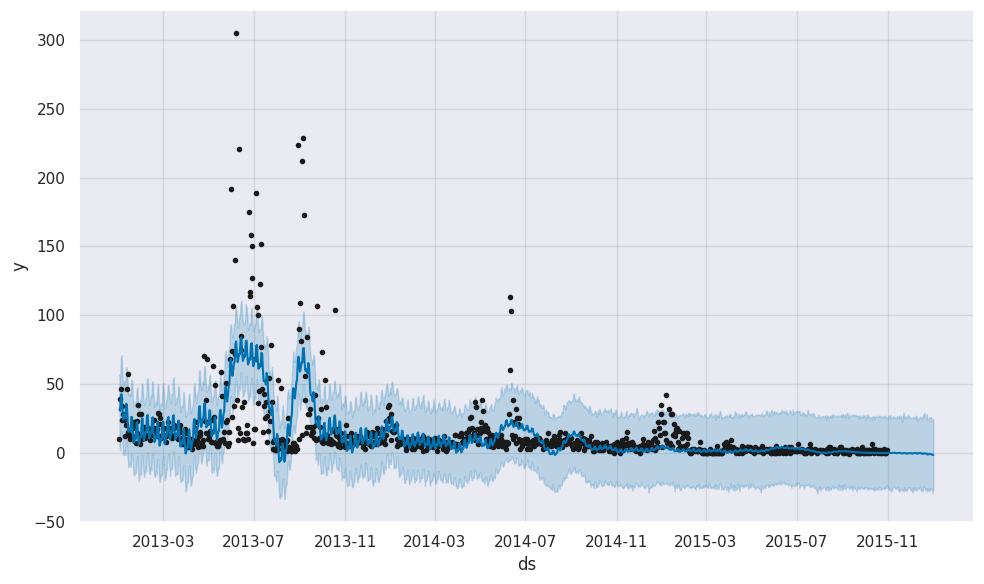

In [424]:
prophet_items_id_sales[2808]['model'].plot(prophet_items_id_sales[2808]['forecast']);

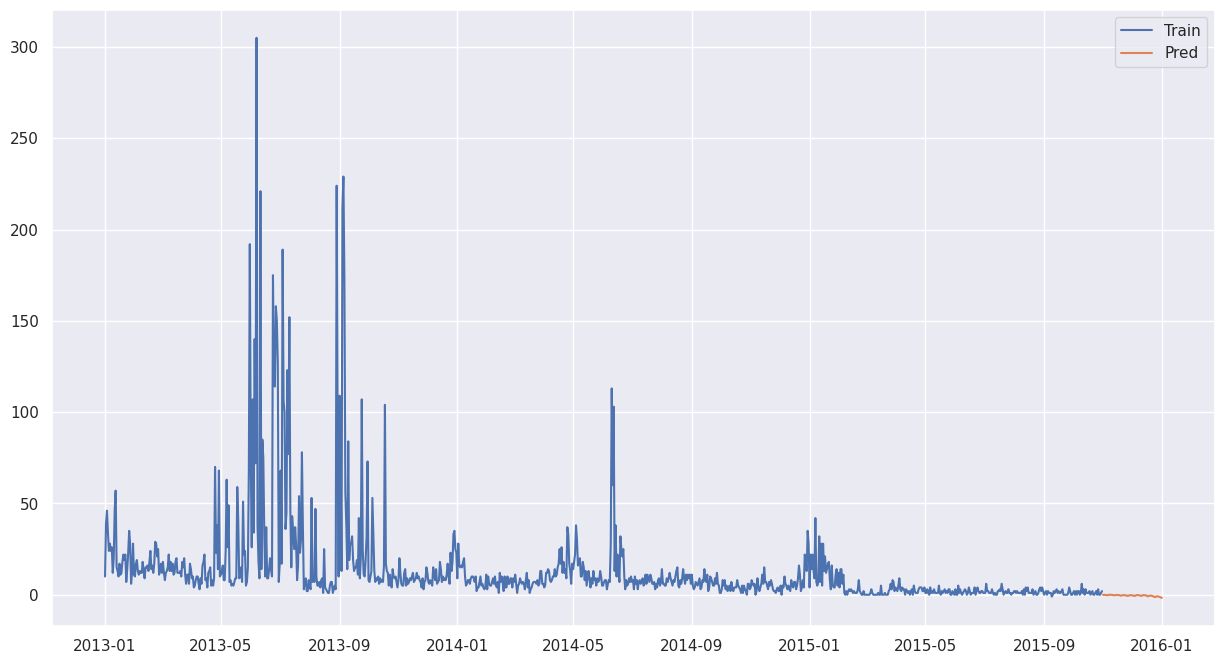

In [425]:
plot_forecast(prophet_items_id_sales[2808], test=False)

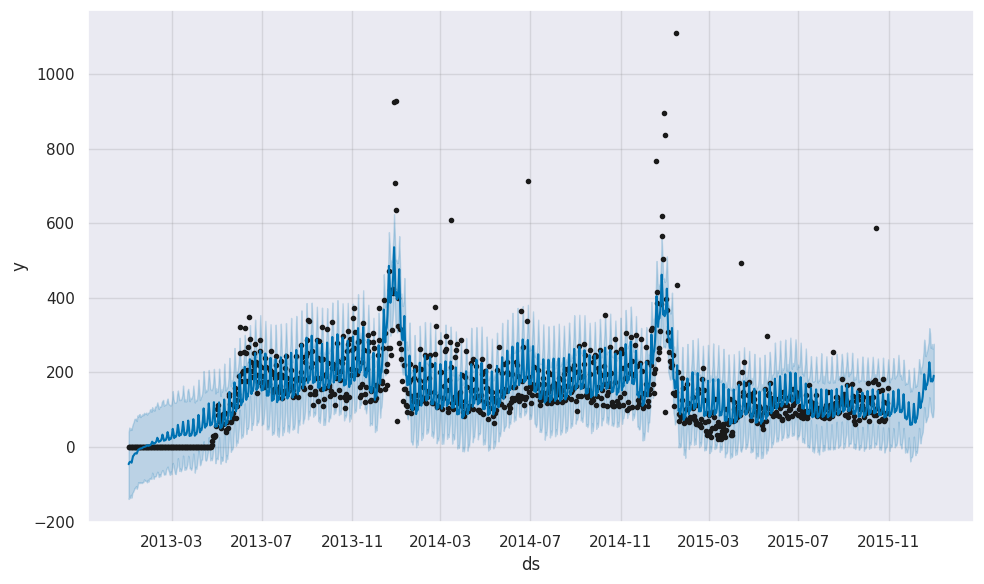

In [429]:
prophet_items_id_sales[20949]['model'].plot(prophet_items_id_sales[20949]['forecast']);

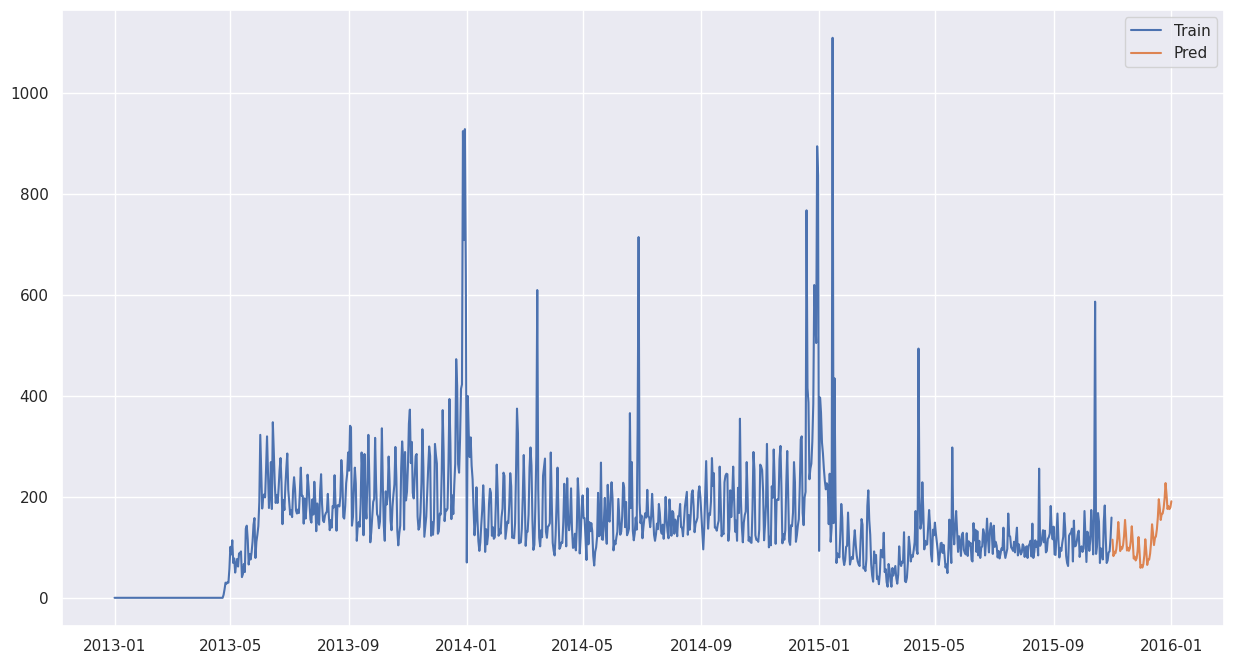

In [430]:
plot_forecast(prophet_items_id_sales[20949], test=False)

### Values

<font size="5"> Total Sales for next month, sun of all items </font>

#### Save the data (on raw_data) and model (on git) in json file

#### Plot Example

## Categories by Shop Prediction

### Sales

<font size="5"> Total Sales for next month, sun of all items </font>

#### Save the data (on raw_data) and model (on git) in json file

#### Plot Example

### Values

<font size="5"> Total Sales for next month, sun of all items </font>

#### Save the data (on raw_data) and model (on git) in json file

#### Plot Example

# Predictions
___

## For all Data Set, the sum of Shops and Category ids

In [101]:
pred_df = pd.DataFrame(
    {'all_shops':[all_shops_sales_pred, all_shops_values_pred],
     'shops_all_id':[all_shops_id_sales_pred, all_shops_id_values_pred],
     'cats_all_id':[all_cats_id_sales_pred, all_cats_id_values_pred]},
    index=['sales', 'values']
)
pred_df

all_shops  shops_all_id  cats_all_id
sales      2091.60       2376.62      2595.80
values  3225336.29    3395246.97   3577287.16

## Tables for predicted sales and values of individual Shops and Categories

In [102]:
pred_shops_id_sales_df = pd.DataFrame(shops_id_sales_pred, index=[0])
pred_shops_id_values_df = pd.DataFrame(shops_id_values_pred, index=[0])
pred_cats_id_sales_df = pd.DataFrame(cats_id_sales_pred, index=[0])
pred_cats_id_values_df = pd.DataFrame(cats_id_values_pred, index=[0])

In [103]:
pred_shops_id_sales_df

shop_id_0  shop_id_1  shop_id_2  shop_id_3  shop_id_4  shop_id_5  \
0       0.03       0.02       28.5      21.97      27.82       34.0   

   shop_id_6  shop_id_7  shop_id_8  shop_id_9  ...  shop_id_50  shop_id_51  \
0      54.26      42.67       -0.0      12.74  ...       26.66       11.48   

   shop_id_52  shop_id_53  shop_id_54  shop_id_55  shop_id_56  shop_id_57  \
0       29.88       34.32      -67.05      189.39       36.57       67.06   

   shop_id_58  shop_id_59  
0       42.55       34.72  

[1 rows x 60 columns]

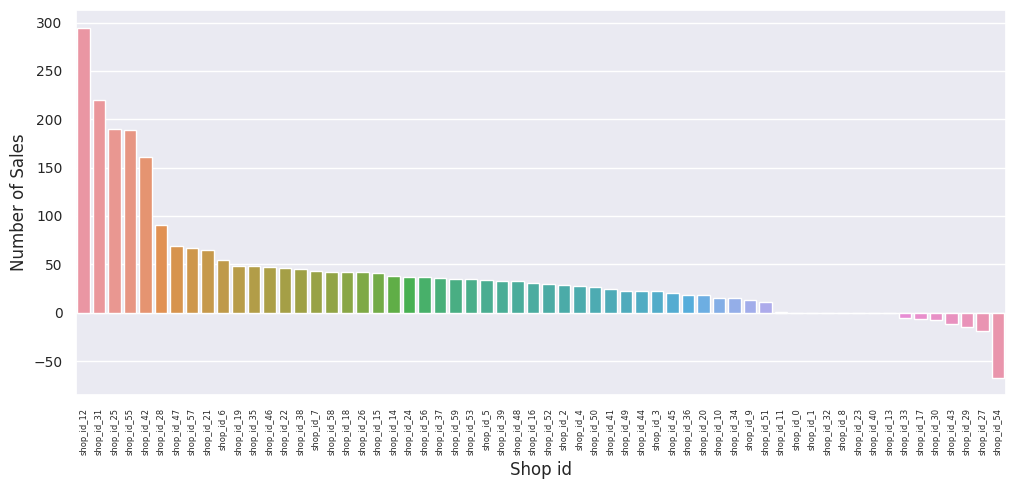

In [104]:
bar_plot_func(pred_shops_id_sales_df, "Shop id", "Number of Sales")

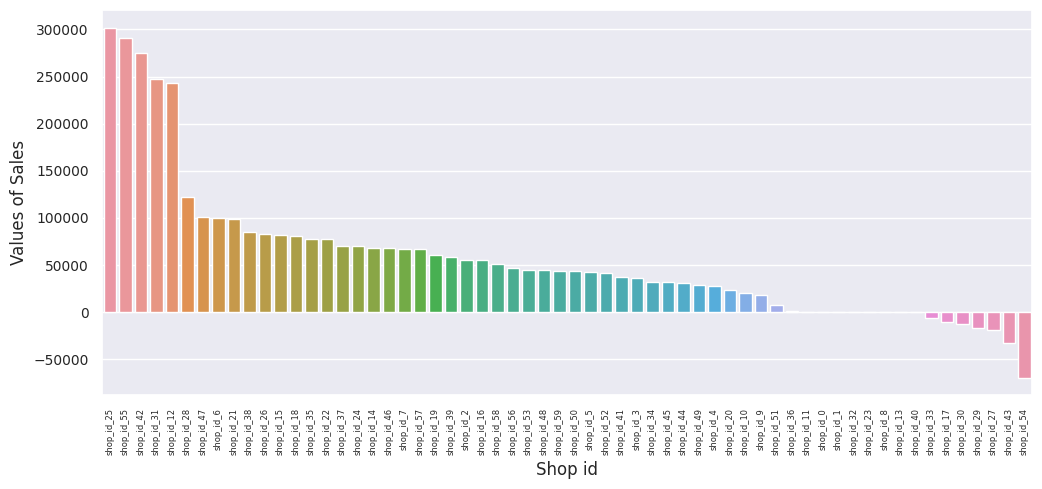

In [105]:
bar_plot_func(pred_shops_id_values_df, "Shop id", "Values of Sales")

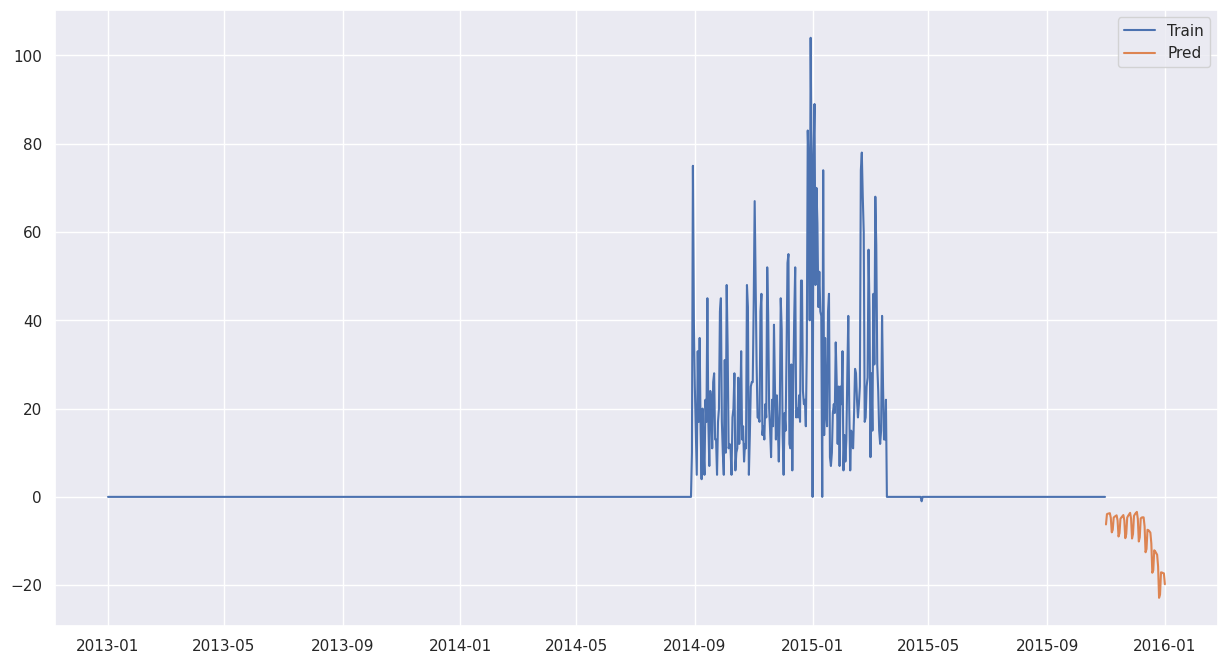

In [106]:
plot_forecast(prophet_shops_id_sales['shop_id_33'], test=False)

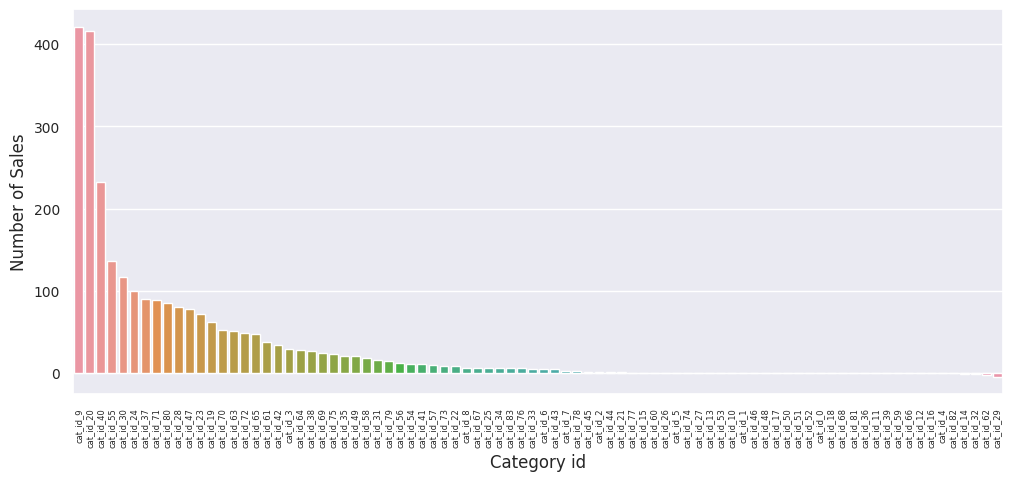

In [107]:
bar_plot_func(pred_cats_id_sales_df, "Category id", "Number of Sales")

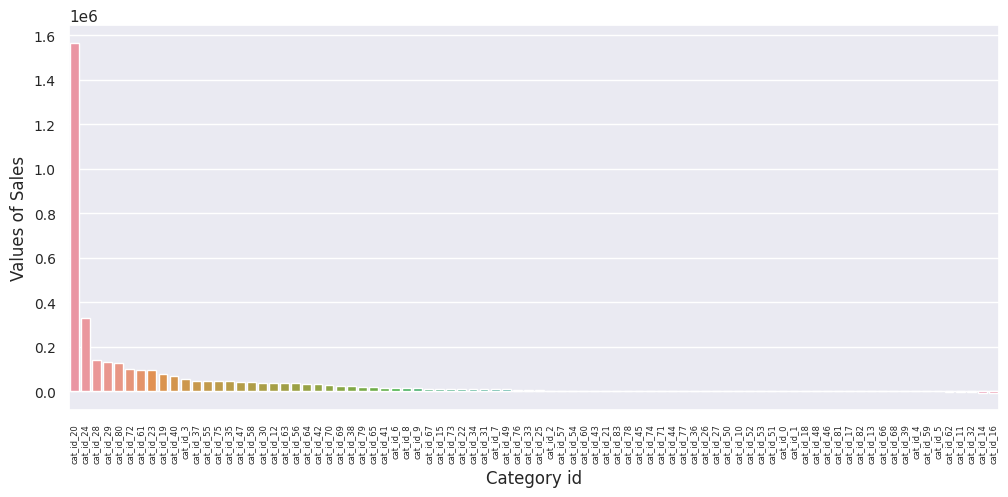

In [108]:
bar_plot_func(pred_cats_id_values_df, "Category id", "Values of Sales")

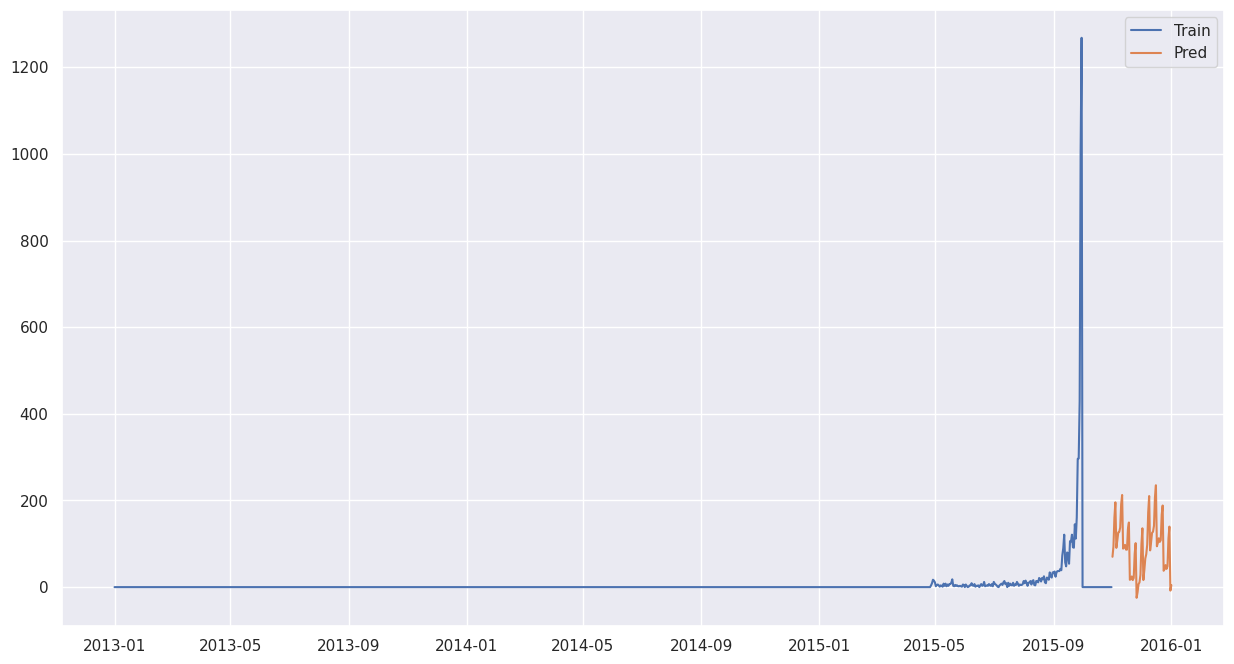

In [109]:
plot_forecast(prophet_cats_id_sales['cat_id_80'], test=False)

# Data Old and What?

## one

In [179]:
shops_cats_sales = pd.pivot_table(
    sales_df, values='item_cnt_day',
    index=['shop_id', 'cat_id'], columns=['date'],
    aggfunc=np.sum 
)
shops_cats_sales.fillna(0, inplace=True)
#shops_cats_sales.reset_index(inplace=True)

In [190]:
shops_cats_sales.T

shop_id      0                                                ...   59       \
cat_id       0    1    2    3    4    5    6    11   13   14  ...   69   70   
date                                                          ...             
2013-01-01  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2013-01-02  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2013-01-03  0.0  0.0  2.0  0.0  0.0  4.0  1.0  0.0  0.0  0.0  ... -2.0  1.0   
2013-01-04  0.0  0.0  6.0  1.0  0.0  2.0  4.0  2.0  0.0  0.0  ...  0.0  1.0   
2013-01-05  0.0  0.0  3.0  2.0  1.0  2.0  4.0  1.0  0.0  1.0  ...  0.0  2.0   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2015-10-27  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  3.0  1.0   
2015-10-28  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  1.0   
2015-10-29  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2015-10-30  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  1.0   
2015-10-31  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  1.0   

shop_id                                             
cat_id       71   72   73   75   77   79   80   83  
date                                                
2013-01-01  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2013-01-02  0.0  0.0  1.0  4.0  0.0  0.0  0.0  0.0  
2013-01-03  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  
2013-01-04  0.0  0.0  0.0  6.0  0.0  0.0  0.0  0.0  
2013-01-05  0.0  0.0  1.0  4.0  0.0  0.0  0.0  0.0  
...         ...  ...  ...  ...  ...  ...  ...  ...  
2015-10-27  1.0  0.0  0.0  2.0  0.0  0.0  0.0  1.0  
2015-10-28  2.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  
2015-10-29  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2015-10-30  0.0  1.0  0.0  1.0  0.0  1.0  0.0  0.0  
2015-10-31  1.0  2.0  1.0  1.0  0.0  1.0  0.0  0.0  

[1034 rows x 3271 columns]

In [186]:
shops_sales

shop_id_0  shop_id_1  shop_id_2  shop_id_3  shop_id_4  shop_id_5  \
date                                                                           
2013-01-01        NaN        NaN         24        NaN        NaN        NaN   
2013-01-02        NaN        NaN         76       64.0      166.0        NaN   
2013-01-03      203.0      204.0         96       43.0      142.0        NaN   
2013-01-04      352.0       39.0         80       44.0      132.0        NaN   
2013-01-05      292.0      200.0         72       29.0      116.0        NaN   
...               ...        ...        ...        ...        ...        ...   
2015-10-27        NaN        NaN          7       12.0       15.0       15.0   
2015-10-28        NaN        NaN         23        8.0       17.0       21.0   
2015-10-29        NaN        NaN         19       13.0       21.0       19.0   
2015-10-30        NaN        NaN         19       28.0       24.0       32.0   
2015-10-31        NaN        NaN         38       32.0       21.0       37.0   

            shop_id_6  shop_id_7  shop_id_8  shop_id_9  ...  shop_id_50  \
date                                                    ...               
2013-01-01        NaN         89       50.0        NaN  ...         NaN   
2013-01-02      173.0        208      138.0        NaN  ...       231.0   
2013-01-03      187.0        158      121.0        NaN  ...       236.0   
2013-01-04      187.0        117      106.0        NaN  ...       206.0   
2013-01-05      144.0        125       99.0        NaN  ...       155.0   
...               ...        ...        ...        ...  ...         ...   
2015-10-27       37.0         23        NaN        NaN  ...        19.0   
2015-10-28       49.0         22        NaN        NaN  ...        26.0   
2015-10-29       45.0         30        NaN        NaN  ...        22.0   
2015-10-30       55.0         48        NaN        NaN  ...        21.0   
2015-10-31       87.0         69        NaN        NaN  ...        58.0   

            shop_id_51  shop_id_52  shop_id_53  shop_id_54  shop_id_55  \
date                                                                     
2013-01-01       136.0         NaN         NaN       415.0         NaN   
2013-01-02       147.0       119.0       149.0       709.0         NaN   
2013-01-03       146.0       100.0       116.0       586.0         NaN   
2013-01-04       121.0       115.0       104.0       495.0         NaN   
2013-01-05        88.0        62.0       141.0       495.0         NaN   
...                ...         ...         ...         ...         ...   
2015-10-27         NaN        17.0        20.0         NaN        74.0   
2015-10-28         NaN         9.0        23.0         NaN        76.0   
2015-10-29         NaN        37.0        22.0         NaN        61.0   
2015-10-30         NaN        32.0        41.0         NaN        92.0   
2015-10-31         NaN        39.0        60.0         NaN       137.0   

            shop_id_56  shop_id_57  shop_id_58  shop_id_59  
date                                                        
2013-01-01         NaN         NaN         NaN         NaN  
2013-01-02       375.0         NaN         NaN       155.0  
2013-01-03       244.0         NaN         NaN       158.0  
2013-01-04       171.0         NaN         NaN        92.0  
2013-01-05       191.0         NaN         NaN       101.0  
...                ...         ...         ...         ...  
2015-10-27        31.0        56.0        50.0        34.0  
2015-10-28        15.0        66.0        27.0        14.0  
2015-10-29        24.0        64.0        37.0        14.0  
2015-10-30        35.0        56.0        45.0        30.0  
2015-10-31        67.0       121.0        82.0        56.0  

[1034 rows x 60 columns]

In [171]:
shops_items_sales = pd.pivot_table(
    sales_df, values='item_cnt_day',
    index=['shop_id', 'item_id'], columns=['date_block_num'],
    aggfunc=np.sum 
)
shops_items_sales.fillna(0, inplace=True)
#shops_items_sales.reset_index(inplace=True)

In [172]:
shops_items_sales

date_block_num    0     1    2    3    4    5    6    7    8    9   ...   24  \
shop_id item_id                                                     ...        
0       30       0.0  31.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        31       0.0  11.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        32       6.0  10.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        33       3.0   3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        35       1.0  14.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
...              ...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
59      22154    1.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        22155    0.0   0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0   
        22162    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        22164    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        22167    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0   

date_block_num    25   26   27   28   29   30   31   32   33  
shop_id item_id                                               
0       30       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        31       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        32       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        33       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        35       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...              ...  ...  ...  ...  ...  ...  ...  ...  ...  
59      22154    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        22155    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        22162    9.0  4.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  
        22164    2.0  1.0  2.0  0.0  0.0  1.0  0.0  0.0  0.0  
        22167    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[424124 rows x 34 columns]

In [ ]:
shops_sales_month['final_id'] = shops_sales_month['shop_id'].astype(str) + "-" + shops_sales_month['item_id'].astype(str)
shops_sales_month.set_index('final_id', inplace=True)
shops_sales_month.drop(columns=['shop_id', 'item_id'], inplace=True)
shops_sales_month = shops_sales_month.T

In [ ]:
shops_sales_month

In [ ]:
plot_cols = ['0-32', '0-49', '59-22144', '59-22167']
plot_features = shops_sales_month[plot_cols]
plot_features.index = shops_sales_month.index
plot_features.plot(subplots = True);

## two

In [ ]:
sales_df[sales_df['shop_id'] == 10].sort_values("date").groupby(by='date').sum('item_cnt_day')

In [ ]:
shop_sales_month =pd.DataFrame({"date_block_num": range(34)})
type(shop_sales_month)

In [ ]:
total_month_dict = {}
for id in range(shops_df.shape[0]):
    shop_id = f"shop_id_{id}"
    df = sales_df[sales_df['shop_id'] == id].groupby(by='date_block_num').sum('item_cnt_day')
    total_month_dict[shop_id] = df.shape[0]
    shop_sales_month[shop_id] = df.item_cnt_day
shop_sales_month.fillna(0, inplace=True)
shop_sales_month.drop(columns=['date_block_num'], inplace=True)

In [ ]:
shop_sales_month

In [ ]:
closed_shops = shop_sales_month.iloc[31:34]
closed_shops = pd.DataFrame(shop_sales_month.iloc[31:34].sum()).T
closed_shops

In [ ]:
pd.DataFrame(shop_sales_month.iloc[31:34].sum()).head(60)

In [ ]:
plt.plot(shop_sales_month.shop_id_0)
plt.plot(shop_sales_month.shop_id_1)
plt.plot(shop_sales_month.shop_id_8)
plt.plot(shop_sales_month.shop_id_9)

plt.plot(shop_sales_month.shop_id_11)
plt.plot(shop_sales_month.shop_id_13)
plt.plot(shop_sales_month.shop_id_17)
plt.plot(shop_sales_month.shop_id_20)
plt.plot(shop_sales_month.shop_id_23)
plt.plot(shop_sales_month.shop_id_27)

plt.plot(shop_sales_month.shop_id_29)
plt.plot(shop_sales_month.shop_id_30)
plt.plot(shop_sales_month.shop_id_32)
plt.plot(shop_sales_month.shop_id_33)
plt.plot(shop_sales_month.shop_id_40)
plt.plot(shop_sales_month.shop_id_27)


plt.plot(shop_sales_month.shop_id_43)
plt.plot(shop_sales_month.shop_id_51)
plt.plot(shop_sales_month.shop_id_54)
plt.plot(range(34))

In [ ]:
plt.plot(shop_sales_month.shop_id_27)
#plt.plot(shop_sales_month.shop_id_41)
#plt.plot(shop_sales_month.shop_id_42)
#plt.plot(shop_sales_month.shop_id_43)
#plt.plot(shop_sales_month.shop_id_44)
#plt.plot(shop_sales_month.shop_id_45)
#plt.plot(shop_sales_month.shop_id_46)

In [ ]:
sns.displot(total_month_dict, bins=34)
plt.xlim(1, 35, )

In [ ]:
total_month_dict

In [ ]:
open_shops